## Projet 7 - Implementation of a scoring model
# Notebook - Model comparison

# Context




# Data sources

The webpage containing all data and descriptions: <a href="https://www.kaggle.com/c/home-credit-default-risk/data" target="_blank">here</a>.

# Glossary

__- TP:__ True positives correspond to customers which are classified as they would default the repayment of their loan and they would as expected.<br>
__- FP:__ False positives correspond to customers which were guessed trustless to repay their loans whereas they would have to (Secondary case to avoid and minimize if possible).<br>
__- FN:__ False negatives correspond to customers which were guessed trustful to repay their loans whereas they will not (Worst case to absolutly minimize).<br>
__- TN:__ True negatives correspond to customers which are classified as they would not default the repayment of their loan and they don't as expected.

# I) Importation of the dataset into a pandas dataframe

## 1) Import all librairies and tools required to realize the project and set the first global variables

In [1]:
### Librairies and tools to import ###

# File system management.
import os.path

# Data manipulations.
import numpy as np
import pandas as pd

# Time measurment and datetime management.
import datetime as dt
#import time
from time import time

# Python random sampling.
from random import sample as py_rd_sp

# Warnings suppression.
import warnings
warnings.filterwarnings('ignore')

# Data visualizations.
from pprint import pprint
#from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings management.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Saving full data.
from numpy import set_printoptions


### Set default figure parameters for the whole notebook ###

# Default parameters for matplotlib's figures.
plt.rcParams['figure.figsize'] = [6,6]
plt.rcParams['figure.dpi'] = 200
#mpl.rcParams['axes.prop_cycle'] = cycler(color=['b', 'r', 'g'])
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

# Default parameters of seaborn's figures.
sns.set_style('white') # NB: Needs to be above sns.set_theme to properly attend custom_params.
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', palette='deep', rc=custom_params)


# Global file paths.
#EXPORTS_DIR_PATH = 'Exports'
EXPORTS_MODELS_DIR_PATH = r'Exports\Models\Tried'
IMPORTS_DIR_PATH = r'Exports\Preprocessed_data'

CSV_MODELS_FILE = 'models_info.csv'
PKL_MODELS_FILE = 'models_info.pkl'
#JSON_MODELS_FILE = 'models_info.json'
#DATASETS_DIR_PATH = r'D:\0Partage\MP-P2PNet\MP-Sync\MP-Sync_Pro\Info\OC_DS\Projet 7\Datasets' #os.path.join('D:', '0Partage', 'MP-P2PNet', 'MP-Sync', 'MP-Sync_Pro', 'Info', 'OC_DS', 'Projet 7', 'Datasets')

In [2]:
def display_EZ (x, max_rows = 100, max_cols = 100, max_colwidth = 100):
    
    """
    Description
    -----------
    Allows to display pandas dataframes with the number of rows and columns whished in an easy manner.
    
    Parameters
    ----------
    df: pandas.DataFrame()
        Dataframe to display.
    max_rows: int
        Maximum number of rows to display.
    max_cols: int
        Maximum number of columns to display.
    max_colwidth: int
        Maximum width of each column.
        
    """
    
    with pd.option_context('display.max_rows', max_rows, 'display.max_columns', max_cols, 'display.max_colwidth', max_colwidth):
        display(x)

In [3]:
def df_to_csv_full (df):
    
    # Set the numpy array number of items cutting threshold to a very high number and avoid the cut.
    set_printoptions(threshold=1e100, linewidth=1e100)
    
    # Save the df to a csv file.
    df.to_csv(os.path.join(EXPORTS_MODELS_DIR_PATH, CSV_MODELS_FILE))
    
    # Reset the numpy array number of items cutting threshold to default.
    set_printoptions(threshold=100, linewidth=25)

## 2) Importation of the preprocessed datasets

In [4]:
def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """

    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                # Can use unsigned int here too
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df

In [5]:
def find_int_cols (df):
      
    for col in df.columns:
        for item in df[col]:
            if item == int(item):
                if df[col].dtype != "int64":
                    df[col] = df[col].astype("int64")
            else:
                if df[col].dtype != "float64":
                    df[col] = df[col].astype("float64") 
                break
                
    return df

In [6]:
df_train = pd.read_csv(os.path.join(IMPORTS_DIR_PATH, 'preprocessed_data_train.csv'))
df_valid = pd.read_csv(os.path.join(IMPORTS_DIR_PATH, 'preprocessed_data_valid.csv'))
df_test = pd.read_csv(os.path.join(IMPORTS_DIR_PATH, 'preprocessed_data_test.csv'))
#df_new_customers = pd.read_csv(os.path.join(IMPORTS_DIR_PATH, 'preprocessed_data_new_customers.csv'))

In [7]:
del_features = ['SK_ID_CURR'] #, 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']

df_train = df_train.drop(del_features, axis=1)
df_valid = df_valid.drop(del_features, axis=1)
df_test = df_test.drop(del_features, axis=1)

In [8]:
%%time

df_train = find_int_cols(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Columns: 169 entries, NAME_CONTRACT_TYPE to TARGET
dtypes: float64(112), int64(57)
memory usage: 30.9 MB
CPU times: total: 3.7 s
Wall time: 3.73 s


In [9]:
df_train = reduce_memory(df_train)

Initial df memory usage is 30.94 MB for 169 columns
Final memory usage is: 8.74 MB - decreased by 71.7%


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Columns: 169 entries, NAME_CONTRACT_TYPE to TARGET
dtypes: float16(71), float32(41), int16(19), int8(38)
memory usage: 8.7 MB


## 3) Separation of the explicatives and the explicated

In [11]:
X_TRAIN = df_train.drop('TARGET', axis=1)
y_TRAIN = df_train['TARGET']

#X_VALID = df_valid.drop('TARGET', axis=1)
#y_VALID = df_valid['TARGET']

X_TEST = df_test.drop('TARGET', axis=1)
y_TEST = df_test['TARGET']

# II) Models

## 1) Importation of required libraries

In [12]:
# Files management (Save and load files).
import csv
import pickle

# Additional common libraries.
from numpy import argmax, argmin
import math

# sklearn tools ad libraries.
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, fbeta_score, confusion_matrix

# Make a sklearn job scorer.
from sklearn.metrics import make_scorer


### Beyesian hyperparmaters tuning ###

# Hyperopt modules.
from hyperopt import STATUS_OK # Check if the objective function returned a valid value (Mandatory).

# Methods for the domain space, algorithm optimization, save the trials history, bayesian optimization.
from hyperopt import hp, tpe, Trials, fmin

*NB: In order to calculate the best probability threshold the AUCROC is selected over the AUCPR since the first one focuses on the FP and FN balance (the 2 most important values to consider for this project) while the AUCPR focused exclusively on the positive (minority class) (=> FP) which does not take into account the most relevant value for this project (FN).*

## 2) Global variables

In [13]:
# Initialize the default cross validation method to use.
SKF_5 = StratifiedKFold(5, shuffle=True, random_state=0)

# True: Allows hyperprameter tuning, False: Get the results stored from the last hyperparmeters tuning.
HT = True

# Update the csv file containing the training information and scores of the model or not (True = update).
GET_CSV_FILE = True

# Set and initialize the main scorer used for the models comparisons.
MAIN_SCORER_TRAIN_LABEL = 'Job_score_train'
MAIN_SCORER_TEST_LABEL = 'Job_score_test'
MAIN_SCORER_VAL = 0

# Load/create and initialize the dataframe in which store all relevant models' information (best hyperparameters, scores...).
# NB: In case of the creation of the file data=np.full((1,len(l_COL_LABELS)), None) to force dtypes as objects
#     until one of the next added entries (rows) are full then, it will be removed. Otherwise, the np.nan values which will appear
#     within the first row will convert their columns' dtypes to float64 and prevent their replacement
#     by objects such as np.array.
l_COL_LABELS = ['Model_labels', 'Models',
                'yhat_train', 'yhat_test',
                'Best_proba_threshold_train', 'Best_proba_threshold_test',
                'Job_score_train', 'Job_score_test', 
                'AUROC_scores_train', 'AUROC_scores_test',
                'F-bêta_score_train', 'F-bêta_score_test',
                'Process_time_train (s)', 'Process_time_test (s)'
               ]

#l_COL_LABELS = ['Model_labels', 'Models',
#                'X_train_shape', 'X_test_shape',
#                'yhat_train', 'yhat_test',
#                'Best_proba_threshold_train', 'Best_proba_threshold_test',
#                'Job_score_train', 'Job_score_test', 
#                'AUROC_scores_train', 'AUROC_scores_test',
#                'F-bêta_score_train', 'F-bêta_score_test',
#                'Process_time_train (s)', 'Process_time_test (s)'
#               ]

if GET_CSV_FILE:
    try:
        df_MODELS = pd.read_pickle(os.path.join(EXPORTS_MODELS_DIR_PATH, PKL_MODELS_FILE))#.set_index('Model_labels')

    except:
        print("No csv models informations were found. A new one is created...")
        df_MODELS = pd.DataFrame(data=np.full((1,len(l_COL_LABELS)), None), columns=l_COL_LABELS).set_index('Model_labels')
        df_MODELS.to_pickle(os.path.join(EXPORTS_MODELS_DIR_PATH, PKL_MODELS_FILE))
        print('Done !')
    
else:
    print("Creation of a new csv file to store models informations...")
    df_MODELS = pd.DataFrame(data=np.full((1,len(l_COL_LABELS)), None), columns=l_COL_LABELS).set_index('Model_labels')
    df_MODELS.to_pickle(os.path.join(EXPORTS_MODELS_DIR_PATH, PKL_MODELS_FILE))
    print('Done !')  

display(df_MODELS.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, dummy_clf to lgbm_clf_opt
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Models                      5 non-null      object 
 1   yhat_train                  5 non-null      object 
 2   yhat_test                   5 non-null      object 
 3   Best_proba_threshold_train  5 non-null      float64
 4   Best_proba_threshold_test   5 non-null      object 
 5   Job_score_train             5 non-null      float64
 6   Job_score_test              5 non-null      object 
 7   AUROC_scores_train          5 non-null      float64
 8   AUROC_scores_test           5 non-null      object 
 9   F-bêta_score_train          5 non-null      float64
 10  F-bêta_score_test           5 non-null      object 
 11  Process_time_train (s)      5 non-null      float64
 12  Process_time_test (s)       5 non-null      object 
dtypes: float64(5), object(8)


None

In [14]:
df_MODELS

Models   
Model_labels                                                      
dummy_clf                DummyClassifier(strategy='stratified')  \
logi_reg_opt  LogisticRegression(C=100.0, class_weight='bala...   
rf_clf_opt    (DecisionTreeClassifier(max_depth=10, max_feat...   
xgb_clf_opt   XGBClassifier(base_score=None, booster=None, c...   
lgbm_clf_opt  LGBMClassifier(class_weight='balanced', colsam...   

                                                     yhat_train   
Model_labels                                                      
dummy_clf     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.5950216861017936, 0.5400718415302808, 0.430...   
rf_clf_opt    [0.5443689719737853, 0.6585302236646584, 0.177...   
xgb_clf_opt   [0.5688134, 0.62018585, 0.15535076, 0.42749348...   
lgbm_clf_opt  [0.6142795453522419, 0.6490163088635007, 0.246...   

                                                      yhat_test   
Model_labels                                                      
dummy_clf     [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.34288296588972866, 0.4585440415379346, 0.56...   
rf_clf_opt    [0.40621306915551864, 0.32463278231053183, 0.1...   
xgb_clf_opt   [0.3637119, 0.47850734, 0.07989965, 0.32197857...   
lgbm_clf_opt  [0.5517143544597476, 0.38818625549996316, 0.16...   

              Best_proba_threshold_train Best_proba_threshold_test   
Model_labels                                                         
dummy_clf                          1.000                       1.0  \
logi_reg_opt                       0.475                     0.475   
rf_clf_opt                         0.400                      0.31   
xgb_clf_opt                        0.475                     0.465   
lgbm_clf_opt                       0.505                     0.485   

              Job_score_train Job_score_test  AUROC_scores_train   
Model_labels                                                       
dummy_clf            0.534591       0.534884            0.499999  \
logi_reg_opt         0.587815       0.581008            0.618610   
rf_clf_opt           0.668959       0.635465            0.727212   
xgb_clf_opt          0.684892         0.6625            0.741560   
lgbm_clf_opt         0.681817       0.651357            0.742423   

             AUROC_scores_test  F-bêta_score_train F-bêta_score_test   
Model_labels                                                           
dummy_clf             0.494565            0.078063          0.066694  \
logi_reg_opt          0.601764            0.897919          0.897778   
rf_clf_opt            0.698339            0.897898          0.900479   
xgb_clf_opt           0.706817            0.898201          0.897944   
lgbm_clf_opt          0.702991            0.898531          0.898577   

              Process_time_train (s) Process_time_test (s)  
Model_labels                                                
dummy_clf                   0.110721              0.019011  
logi_reg_opt                3.038564              0.370336  
rf_clf_opt                  7.106856              1.710559  
xgb_clf_opt                 3.163377              1.121018  
lgbm_clf_opt                1.303183              0.516469

## 3) Functions 

### a) Model fitting and predictions

In [15]:
def model_fit_predict (model, X=X_TRAIN, y=y_TRAIN, cv=SKF_5):
    
    # Fit and predict probabilities by cross validation.
    if cv != 0:
        t0 = time()
        y_pred_proba_NP = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        process_time = time() - t0

    # Fit and predict over the test set (no cv).
    else:
        t0 = time()
        model.fit(X, y)
        y_pred_proba_NP = model.predict_proba(X)
        process_time = time() - t0
    
    return y_pred_proba_NP, process_time

In [16]:
def get_y_pred_list (y_pred_proba_P, l_proba_thrs = np.linspace(0, 1, num=100)):
    
    # Classify the customers of the sample for each probability threshold.
    l_y_pred = []
    for proba_thr in l_proba_thrs:

        y_pred = []
        for proba in y_pred_proba_P:
            if proba > proba_thr:
                y_pred.append(1)
            else:
                y_pred.append(0)
        
        l_y_pred.append(y_pred)
                
    return l_y_pred

In [17]:
def get_tp_fp_fn_tn_lists (y_true, l_y_pred):

    l_tp = []
    l_fp = []
    l_fn = []
    l_tn = []
    for y_pred in l_y_pred:
        #cm = confusion_matrix(y_true, y_pred)
        #l_tn.append(cm[0][0])
        #l_fp.append(cm[0][1])
        #l_fn.append(cm[1][0])
        #l_tp.append(cm[1][1])
        #display(y_true[y_true == 1])
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        l_tp.append(tp)
        l_fp.append(fp)
        l_fn.append(fn)
        l_tn.append(tn)

    
    return l_tp, l_fp, l_fn, l_tn

### b) Optimization of the probability threshold

In [18]:
def opt_proba_thr (np_tp, np_fp, np_fn, np_tn, l_proba_thrs, fn_cost_coeff = 10):     
        
    ### Calculation of the best probability threshold.
    
    # Method 1 (Less accurate at low number of thresholds tried): Get the index of the closest FP/FN ratio of 1.
    #J = np_fp / (fn_cost_coeff * np_fn)
    #j_opt = 0
    #for idx, j in enumerate(J):
    #    if (j < 1 and j > j_opt) or (j > 1 and j < j_opt):
    #        j_opt = j
    #        J_opt_idx = idx
    #print("Corresponding optimal ratio found:", J[J_opt_idx])
    
    # Method 2 (More accurate at low number of thresholds tried):
    # NB: As it had been seen within the global EDA notebook, there is 1 FN for 10 FP.
    #     Our manager suggested that we should consider that 1 FN cost ~10 times more then 1 FP.
    #     => No need to add a coefficient in front of FN to add more weight since it is already
    #        taken into account within the classification balancement for the 2nd method.
    #        => fn_cost_coeff = 10 --> 1
    
    tpr = np_tp / (np_tp + fn_cost_coeff/fn_cost_coeff * np_fn)
    fpr = np_fp / (np_fp + np_tn)
    J = tpr - fpr
    J_opt_idx = argmax(J)
    
    # Method 3:
    #np_fp_hypothesis = np_fp + fn_cost_coeff * np_fn
    #J_opt_idx = argmin(np_fp_hypothesis)
    
    # Get the optimal probability threshold.
    best_thr = l_proba_thrs[J_opt_idx]

    # Print scores.
    #print('Best Threshold: %.3f' % best_thr)
    #print('Number of FP =', np_fp[J_opt_idx])
    #print('Number of FN =', np_fn[J_opt_idx], '~ FP =', 10 * np_fn[J_opt_idx])
    #print('Equivalent number of FP =', np_fp_hypothesis[J_opt_idx])
    
    return best_thr, J_opt_idx

In [19]:
def figure_density (y_true, y_pred_proba_P, best_thr):
    
    # Find and show the optimal probability threshold on a figure.
    
    # Find the best threshold value graphically.
    y_true_P = y_true[y_true == 1]
    y_true_N = y_true[y_true == 0]

    # Plot the probability density approximation of the TN.
    #plt.hist(y_pred_proba_P[y_true_N.index], bins=100, density=True)
    kde_N = sns.kdeplot(y_pred_proba_P[y_true_N.index], fill=True, alpha=0.5, edgecolor='k') #multiple="stack"
    
    # Plot the probability density approximation of the FN.
    #plt.hist(y_pred_proba_P[y_true_P.index], bins=100, density=True)
    sns.kdeplot(y_pred_proba_P[y_true_P.index], fill=True, alpha=0.5, edgecolor='k')

    # Plot a line at the best threshold found.
    plt.vlines(best_thr, ymin=0, ymax=max(kde_N.get_yticks()), colors='k', linestyles='--')
    
    # Set other figures' parameters.
    plt.title("Distribution of the probability a customer default")
    plt.xlabel("Probability thresholds")
    plt.legend(["Regular customers", "Default customers"])
    
    # Draw the figure.
    #plt.show()

In [20]:
def figure_sum_fp_coeff_fn (np_fp, np_fn, l_proba_thrs, best_thr, fn_cost_coeff = 10):
    
    # Apply the cost hypothesis and convert FN to its supposed corresponding number of FP.
    np_fp_hypothesis = np_fp + fn_cost_coeff * np_fn
    
    # Plot the corresponding curve.
    plt.plot(l_proba_thrs, np_fp_hypothesis)
     
    # Plot a line at the best threshold found.
    plt.vlines(best_thr, ymin=0, ymax=max(np_fp_hypothesis), colors='k', linestyles='--')
    
    # Set other figures' parameters.
    plt.title("Total number of corresponding FP according to probability thresholds")
    plt.xlabel("Probability thresholds")
    plt.ylabel("Total false positives")
    
    # Draw the figure.
    #plt.show()

### c) ROC-AUC

In [21]:
def figure_roc (y_true, l_yhats, l_model_labels):
    
    idx = 0
    for idx in range(len(l_model_labels)):
        model_label = l_model_labels[idx]
        yhat = l_yhats[idx]
            
        # Calculate inputs for the roc curve.
        fpr, tpr, thresholds = roc_curve(y_true, yhat)
        
        # Calculate the corresponding AUC.
        auroc = roc_auc_score(y_true, yhat)
    
        # Plot the roc curves.
        plt.plot(fpr, tpr, marker='.', markersize=2, label=model_label + " (AUC = %.3f)" % auroc)
        
        # Iterate the index value for the next loop.
        idx += 1
    
    # Plot the no skill roc curve (the diagonal line).
    plt.plot([0, 1], [0, 1], linestyle='--', label='No skill (AUC = 0.5)', color='k', alpha=0.75)
    
    # Set axis labels and the title.
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC")
    
    # Show the legend.
    plt.legend()

### d) F-bêta score

In [22]:
def get_fbeta_score (l_proba_thrs, l_fbeta, beta, best_thr, best_thr_idx):
       
    # Get the optimal F-bêta score.
    print('F-Bêta score of the optimal threshold found = %.3f' % l_fbeta[best_thr_idx])
    print('Highest F-Bêta score = %.3f' % max(l_fbeta))
    
    return max(l_fbeta)

In [23]:
def figure_fbeta_score (l_proba_thrs, l_fbeta, best_thr):
    
    # Plot the graph.
    plt.plot(l_proba_thrs, l_fbeta)
    
    # Plot a line at the best threshold found.
    plt.vlines(best_thr, ymin=0, ymax=max(l_fbeta), colors='k', linestyles='--')
     
    # Set other figures' parameters.
    plt.title('F-bêta score = f(Probability thresholds)')
    plt.xlabel('Probability thresholds')
    plt.ylabel('F-bêta score')

### e) Job score

In [24]:
def gain_norm (y_true, y_pred, fn_value=-10, fp_value=0, tp_value=0, tn_value=1):


    # Matrice de Confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # gain total
    g = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    # gain maximum
    g_max = (fp + tn)*tn_value + (fn + tp)*tp_value
    # gain minimum
    g_min = (fp + tn)*fp_value + (fn + tp)*fn_value
    # gain normalisé
    g_norm = (g - g_min)/(g_max - g_min)

    return g_norm

In [25]:
def g_norm_scorer_fct (y_true, y_pred_proba_P, verbose = True):
    
    # Set the probability threshold range to try.
    l_proba_thrs = np.linspace(0, 1, num=100)
    
    # Get all set of predictions for each threshold.
    l_y_pred = get_y_pred_list(y_pred_proba_P)
    
    # Get the confusion matrix results for each set of predictions.
    np_tp, np_fp, np_fn, np_tn = np.array(get_tp_fp_fn_tn_lists(y_true, l_y_pred))
    
    # Get the best threshold and its corresponding index with the list of the predictions sets.
    best_thr, idx = opt_proba_thr(np_tp, np_fp, np_fn, np_tn, l_proba_thrs, fn_cost_coeff = 10)
    
    # Select the prediction set corresponding to the best threshold found.
    y_pred = l_y_pred[idx+1]
    
    # Calculate the normalized gain.
    g_norm = gain_norm(y_true, y_pred, fn_value=-10, fp_value=0, tp_value=0, tn_value=1)
    
    if verbose:
        print('Best probability threshold:', best_thr)
    
    return g_norm

# Make the function as a new scorer for sklearn.
g_norm_scorer = make_scorer(g_norm_scorer_fct, verbose=True, needs_proba=True)

In [26]:
#skf = StratifiedKFold(5, shuffle=True, random_state=0)
#test = cross_val_score(logi_reg, X_TRAIN, y_TRAIN, cv=skf, scoring=g_norm_scorer)

#np.mean(test)

### f) Hyperparameter tuning

In [27]:
def hyper_tune_rand_grid (model, X, y, para_grid, score, cv, score_label = 'score',
                          n_iter = 100, grid_loop = 1, range_precision = None, rand_state = 0, verbose = 0):
    
    """
    Description
    -----------
    Tune the chosen hyperapameters of the model by checking a random number of combinations with the RandomizedSearchCV() method.
    This function tunes the hyperparameters by taking the best combination among the best one found in each loop run.
    
    Parameters
    ----------
    model: sklearn model
        Model to test.
    X: pandas.Dataframe()
        Dataframe of the explicatives.
    y: pandas.Dataframe()
        Dataframe of the explicated.
    n_folds: int
        Split parameter of the KFold function.
    para_grid: dictionary
        Parameters of the model to tune.
    n_iter: int
        Number of combinations of hyperparameters within which the RandomizedSearchCV will pick the best.
    grid_loop:
        Number of loop run.
    range_precision: int
        Number of decimals to round to.
    int_para_names: list of strings
        Hyperparameters which accept only integers.
    bool_para_names: list of strings
        Hyperparameters which accept only booleans.
    rand_state: int
        random_state parameter in order to fix the randomness of the runs.

    Return: sklearn.RandomizedSearchCV()
    ------
    Returns the fitted randomized model grid.
        
    """      
    
    def show ():
        
        """
        Description
        -----------
        Show relevant information at the end of the process.
        
        """  
        
        # Fit the grid model.
        model_grid.fit(X, y)
        
        # Display the best hyperparameter.
        print("\nBest estimator found:\n", model_grid.best_estimator_)
        print("\nBest score found:\n", score_label, '=', round(model_grid.best_score_, 3))
        print("\nBest hyperparameters found:\n", model_grid.best_params_)  

        
    # Set the KFold cross validation with the selected n_folds.
    #skf = StratifiedKFold(n_folds, shuffle=True, random_state=0)

    # Create a dictionary with all parameters to test as keys and empty lists as values.
    best_para_stored = para_grid.copy()
    for key in best_para_stored.keys():
        best_para_stored[key] = []
    
    for i in range(grid_loop):
               
        # Random search of parameters, use all available cores.
        model_grid = RandomizedSearchCV(estimator=model, param_distributions=para_grid, cv=cv, scoring=score,
                                        n_iter=n_iter, refit=True, n_jobs=-1, random_state=rand_state, verbose=verbose)
         
        # Fit the random grid.
        # NB: Step needed to be able to get the "best_params_" method.
        model_grid.fit(X, y)#.to_numpy().ravel())

        # Get the best parameters values in a dictionary.
        best_para = model_grid.best_params_
        
        # Loop to store the best parameter got in this loop run, in order to make the average at the end of all runs.
        for key in best_para_stored.keys():
            
            # Get the best value for the "key" parameter.
            if range_precision != None:
                best_para_value = round(best_para.get(key), range_precision)
            else:
                best_para_value = best_para.get(key)
            
            # Store this value in the dictionary set at the beginning of the function ("best_para_stored").
            best_para_stored[key].append(best_para_value)
            
            # Remove duplicates.
            best_para_stored[key] = list(set(best_para_stored[key]))
    

    # Replace the initial parameters with the best ones found.
    para_grid = best_para_stored
    
    # Find the best parameter among the best found.
    model_grid = GridSearchCV(estimator=model, param_grid=para_grid, cv=cv, scoring=score, n_jobs=-1, verbose=verbose)
    
    # Show results.
    show()
        
    return model_grid

In [28]:
def hyper_tune_bayes (model,
                      search_space,
                      model_label,
                      cv,
                      action = 0,
                      max_eval = 5,
                      eval_metric = gain_norm, # Mesure d'évaluation
                      eval_metric_label = 'g_norm',
                      X = X_TRAIN,
                      y = y_TRAIN,
                     ):

    
    ### Configuration ###

    # Set global variabls.
    global ITERATION
    
    # Set save file path.
    history_dir_path = os.path.join(r'Exports\Models\Selected\Hyperparams_tuning_history')
    csv_file_name = model_label + "_" + eval_metric_label + "_trials.csv"
    p_file_name = model_label + "_" + eval_metric_label + "_trials.pkl"
    
    
    #history_json_file_path = os.path.join(r'Exports\Models\Hyperparams_tuning_history',
    #                                 model_label + "_" + eval_metric_label + '_trials.json')
    
    
    # 1. Definition of the objective function (=> calculation of the loss score).
    def objective (hyperparams_set):
        
        # Count each function call as an iteration.
        global ITERATION    
        ITERATION += 1

        # On s'assure que les paramètres soient au bon format
        #for param_label in ['num_leaves','max_depth','n_estimators']:
        #    params[param_label] = int(params[param_label])

        ### Initializes a new set of model's hyperparameters values.
        #model_hyperparams = {'n_estimators': int(params['n_estimators']), 
        #                     'class_weight': params['class_weight'],
        #                     'max_depth': int(params['max_depth']), 
        #                     'learning_rate': params['learning_rate'],
        #                     'subsample': params['subsample'],
        #                     'colsample_bytree': params['colsample_bytree'],
        #                     'num_leaves': int(params['num_leaves']),
        #                     'reg_alpha': params['reg_alpha'],
        #                     'reg_lambda': params['reg_lambda']
        #                    }
        
        
        
        # Get the classification probability threshold to try (chosen the algorithm).
        proba_thr = hyperparams_set['proba_thr']
        
        # Delete the custom probability "hyperparmeter" as it does not belong to the model hyperparameters.
        del hyperparams_set['proba_thr']
        
        # Set the new model's hyperparameters values to try.
        model.set_params(**hyperparams_set)

        # Get the time before the model training and predictions processes.
        t0 = time()
        
        
        #if method_ == 1:
        # Get the positive probabilities over all validation folds.
        y_proba_P_cv = cross_val_predict(model, X, y, method='predict_proba', cv=cv)[:, 1]

        # If positive probability > probility threshold => prediction = 1
        # NB: "(y_proba_P_cv > proba_thr)" returns a boolean np.array() and "* 1" converts booleans as True = 1 or False = 0.
        y_pred = (y_proba_P_cv > proba_thr) * 1
        #y_pred = np.array(y_pred > 0) * 1
        
        #elif method_ == 2:
        #    y_pred = cross_val_predict(model,
        #                               x_train,
        #                               y_train,
        #                               method='predict',
        #                               cv=skf)
            
        # Get the score value of the chosen metric.
        score = eval_metric(y, y_pred)
            
        # Calculate the corresponding loss (value to minimize).
        loss = 1 - score

        # Calculate the processing time.
        run_time = round((time() - t0), 2)
                
            
        # Save the trials gotten at this iteration.
        with open(os.path.join(history_dir_path, csv_file_name), 'a') as history_file:
            csv_file_writer = csv.writer(history_file)
            csv_file_writer.writerow([ITERATION, loss, hyperparams_set, proba_thr, run_time])
            history_file.close()
        
        #with open(os.path.join(history_dir_path, p_file_name), 'a') as history_file:
            #json_file_writer = json.writer(history_file)
            #history_file.write(json.dumps({'loss': loss, 'status': STATUS_OK}))
            #history_file.close()
        
        return {'loss': loss, 'status': STATUS_OK} #'hyperparams': hyperparams_set, 'proba_thr': proba_thr, 'iter': ITERATION, 'run_time': run_time,

    
    def process ():

        best_hyperparams = fmin(fn = objective,
                                space = search_space,
                                algo = tpe.suggest,
                                max_evals = max_eval,
                                trials = trials,
                #               rstate = np.random.RandomState(rs_)
                               )

        # Save the trials' history to continue the hyperparameter tuning if required later on.
        #history_file = pd.read_csv(os.path.join(history_dir_path, csv_file_name))
        #json.dump(trials, open(os.path.join(history_dir_path, p_file_name)), indent=4)
        pickle.dump(trials, open(os.path.join(history_dir_path, p_file_name), "wb"))
    
    
    # 2. Dictionary of hyperpameters (Domain space).
    


    
    # 3. Optimization algorithme (Substitution function).
    tpe_algorithm = tpe.suggest
    
    
    # 4. Process and save trials.
    
    if action == 0:
    
        # To save trials save trials.
        trials = Trials()

        # Create and open the file into save the history of the hyperparmeter tuning.
        with open(os.path.join(history_dir_path, csv_file_name), 'w') as history_file:
            
            csv_file_writer = csv.writer(history_file)

            # Create the header of the file then close it.
            csv_file_writer.writerow(['iter', 'loss', 'tuned_hyperparams', 'proba_thr', 'run_time'])
            history_file.close()
        
        # Create and open the file into save the history of the hyperparmeter tuning.
        with open(os.path.join(history_dir_path, p_file_name), 'w') as history_file:
            history_file.close()
        
        
        #with open(os.path.join(history_dir_path, p_file_name), 'w') as  history_file:
        #    history_file.close()
                      
            
        #with open(_model + ".hyperopt", "wb") as f:
        #    pickle.dump(trials, f)


        ### Processing ###

        #if eval_metric == gain_norm:
        #    metric_ = 'GainNorm'
        #elif eval_metric == roc_auc_score:
        #    metric_ = 'RocAuc'
        #elif eval_metric == f1_score:
        #    metric_ = 'F1Sco'
        
        #global ITERATION
        ITERATION = 0
        
        process()

    elif action == 1:
        
        # Save the trial results
        #with open('trials.json', 'w') as f:
           # f.write(json.dumps(trials_dict))

        trials = pickle.load(open(os.path.join(history_dir_path, p_file_name), "rb"))
        #trials = json.load(open(os.path.join(history_dir_path, p_file_name)))
        df_history = pd.read_csv(os.path.join(history_dir_path, csv_file_name))

        #trials = pickle.load(open("my_model.hyperopt", "rb"))x
        print("Found saved Trials! Loading...")
        add_n_eval = max_eval
        max_eval = len(trials.trials) + add_n_eval
        print("Running from the {}th trial to {} trials (=> +{} trials)".format(len(trials.trials), max_eval, add_n_eval))
   
        ITERATION = len(df_history)
        
        process()

    df_history = pd.read_csv(os.path.join(history_dir_path, csv_file_name)).sort_values(by='loss')

    return df_history

### g) Model peformance evaluation

In [29]:
def evaluate (y_pred_proba_P, y_true = y_TEST, fig = (1,1,1,1), l_model_labels = ['Model']):
      
    global MAIN_SCORER_VAL
    
    ### Calculate necessary variables.
    
    # List of the probability thresholds to try.
    l_proba_thrs = np.linspace(0, 1, num=201)
    
    # Get the predictions corresponding to each probability thresholds tried.
    l_y_pred = get_y_pred_list(y_pred_proba_P, l_proba_thrs)
    
    # Get the corresponding TP, FP, FN and TN for each probability thresholds tried.
    np_tp, np_fp, np_fn, np_tn = np.array(get_tp_fp_fn_tn_lists(y_true, l_y_pred))
    
    # FN cost coefficient (FN ~ 10 FP).
    fn_cost_coeff = 10
    
    # Display figures configuration.
    n_fig = fig.count(1)
    
    if n_fig != 0:
        plt.figure(figsize=(12,12), dpi=300)
        p = 0
        if n_fig == 1:
            l = 1; c = 1
        elif n_fig == 2:
            l = 1; c = 2
        elif n_fig >= 3:
            l = 2; c = 2  
    
    
    ### Calculate the optimal probability threshold.
    
    # Calculate the optimal threshold.
    model_best_thr, best_thr_idx = opt_proba_thr(np_tp, np_fp, np_fn, np_tn, l_proba_thrs)    
    
    # Plot figures.
    if fig[0]:
        p += 1 
        plt.subplot(l,c,p)
        figure_density(y_true, y_pred_proba_P, model_best_thr)
    
    if fig[1]:
        p += 1 
        plt.subplot(l,c,p)
        figure_sum_fp_coeff_fn(np_fp, np_fn, l_proba_thrs, model_best_thr, fn_cost_coeff)
    
    
    ### Calculate scores.
    
    # ROC AUC score.
    roc_auc_s = roc_auc_score(y_true, y_pred_proba_P)
    print('\nROC-AUC = %f' % roc_auc_s) #%.3f
    
    # Plot figure.
    if fig[2]:
        p += 1 
        plt.subplot(l,c,p)
        figure_roc(y_true, [y_pred_proba_P], l_model_labels)
    
    
    # F-bêta score.
    # NB: Square beta = cost FN / cost FP = 10
    square_beta = 100
    beta = round(math.sqrt(square_beta), 2)
      
    # Calculate the F-bêta score for each probability thresholds tried.
    l_fbeta = []
    for y_pred in l_y_pred:
        fbeta = fbeta_score(y_true, y_pred, beta=beta)
        l_fbeta.append(fbeta)
    fbeta = get_fbeta_score(l_proba_thrs, l_fbeta, beta, model_best_thr, best_thr_idx)

    # Plot figure.
    if fig[3]:
        p += 1 
        plt.subplot(l,c,p)
        figure_fbeta_score(l_proba_thrs, l_fbeta, model_best_thr)
    
    
    # Job score.
    g_norm = gain_norm(y_true, l_y_pred[best_thr_idx])
    MAIN_SCORER_VAL = g_norm
    print("Job score: %.3f" % g_norm)

    
    print("\n" + "-" * 100 + "\n")
    # Draw figures.
    if fig != (0,0,0,0):
        plt.show() 
        
    return model_best_thr, g_norm, roc_auc_s, fbeta

In [30]:
def evaluate_cv (model, X = X_TRAIN, y = y_TRAIN, l_scores = ['roc_auc', 'precision', 'recall'], cv = 5):
    
    cv_folds_results = cross_validate(model, X, y, cv=cv, scoring=l_scores, return_train_score=True)
    
    display(cv_folds_results)
    
    cv_mean_results = {}
    for key, value in cv_folds_results.items():
        cv_mean_results[key] = np.mean(value) #sum(folds_scores) / float(len(folds_scores))
    
    display(cv_mean_results)

### h) Table to store all models' relevant values along the notebook

In [31]:
def summarizing_table (df, l_vars, eval_dataset):
    
    ### Variables unpacking ###
    model_label_key, model_key, \
    yhat_train_key, yhat_test_key, \
    best_thr_train_key, best_thr_test_key, \
    g_norm_train_key, g_norm_test_key, \
    rocauc_train_key, rocauc_test_key, \
    fbeta_train_key, fbeta_test_key, \
    process_time_train_key, process_time_test_key = l_COL_LABELS
    
    model_label, model, yhat, best_thr, g_norm, rocauc, fbeta, process_time = l_vars

    
    ### Select if the values corresponds to the validation set or the test set ###
    if eval_dataset == 'valid_set':
        dict_val = {yhat_train_key: yhat,
                    best_thr_train_key: best_thr,
                    g_norm_train_key: g_norm,
                    rocauc_train_key: rocauc,
                    fbeta_train_key: fbeta,
                    process_time_train_key: process_time
                   }

    else: # test_set
        dict_val = {yhat_test_key: yhat,
                    best_thr_test_key: best_thr,
                    g_norm_test_key: g_norm,
                    rocauc_test_key: rocauc,
                    fbeta_test_key: fbeta,
                    process_time_test_key: process_time
                   }
    
    dict_model = {model_label_key: model_label, model_key: model}
    

    ### Create or update the right line in the dataframe ###
    # NB: In python > 3.9 it is possible to merge dictionaries with "|" (the last dictionary takes the priority in conflicts).
    
    # Create a new row if it does not exist.
    if model_label not in df.index:
        print("Creating new entry...")
        df.loc[model_label] = dict_model | dict_val #[None] * df.shape[1]
        print("Done!")
        
    # Update the row.
    else:
        print("Updating entry...")
        df.loc[model_label] = df.loc[model_label].to_dict() | dict_model | dict_val 
        print("Done!")

    return df

In [32]:
def update_sum_table (df, l_vars, get_csv_file, eval_dataset, force_update = False):

    # Update the csv file if the main score is higher.
    if get_csv_file:
        
        # Reload the csv file in a df (created or already loaded at the beginning of the notebook).
        df = pd.read_pickle(os.path.join(EXPORTS_MODELS_DIR_PATH, PKL_MODELS_FILE))#.set_index('Model_labels')
        
        # Remove the initializing row (first row of filled with None) if one of the added rows are already full.    
        if df.index[0] == None:
            i = 0
            for i in range(df.shape[0]):
                if sum(df.iloc[i].isna()) == 0:
                    df.dropna(how='all', inplace=True) # Drop the now useless first row.
                    #df = df.convert_dtypes() # Infere all dtypes to according to the data type under each column.
                    break
        
        # Check if the measures are from the test set or the train set.
        if eval_dataset == 'valid_set':
            main_scorer_label = MAIN_SCORER_TRAIN_LABEL
        else:
            main_scorer_label = MAIN_SCORER_TEST_LABEL
        
        # Check if the model_label entry is in the df.
        model_label = l_vars[0]        

        if model_label not in df_MODELS.index:
            df = summarizing_table(df, l_vars, eval_dataset)
            #df_to_csv_full(df)
            df.to_pickle(os.path.join(EXPORTS_MODELS_DIR_PATH, PKL_MODELS_FILE))
            print('The new informations have been saved in a new row.')
        
        # Check if the score is inferior from the one already stored in the csv file.
        elif df.loc[model_label, main_scorer_label] < MAIN_SCORER_VAL or pd.isnull(df.loc[model_label, main_scorer_label]) or force_update:
            df = summarizing_table(df, l_vars, eval_dataset)
            #df_to_csv_full(df)
            df.to_pickle(os.path.join(EXPORTS_MODELS_DIR_PATH, PKL_MODELS_FILE))
            print('The row have been updated.')
        
        # Don't update if the new score is below the one in the csv file.
        else:
            print('The new score is inferior to the one already saved.')
            print('Dataframe not saved.')

            
    # Do not update the csv file (set by user).
    else: 
        df = summarizing_table(df, l_vars, eval_dataset)

    return df

## 3) Cost-sensitive solutions

### a) Baseline model: Dummy classifier

#### i. Libraries importation

In [33]:
from sklearn.dummy import DummyClassifier

In [34]:
# Initiliaze the baseline model with its default values.
dummy_clf = DummyClassifier(strategy="stratified")

#### ii. No optimization

sklearn cross val score = 0.5008291443331481

ROC-AUC = 0.500745
F-Bêta score of the optimal threshold found = 0.080
Highest F-Bêta score = 0.080
Job score: 0.530

----------------------------------------------------------------------------------------------------



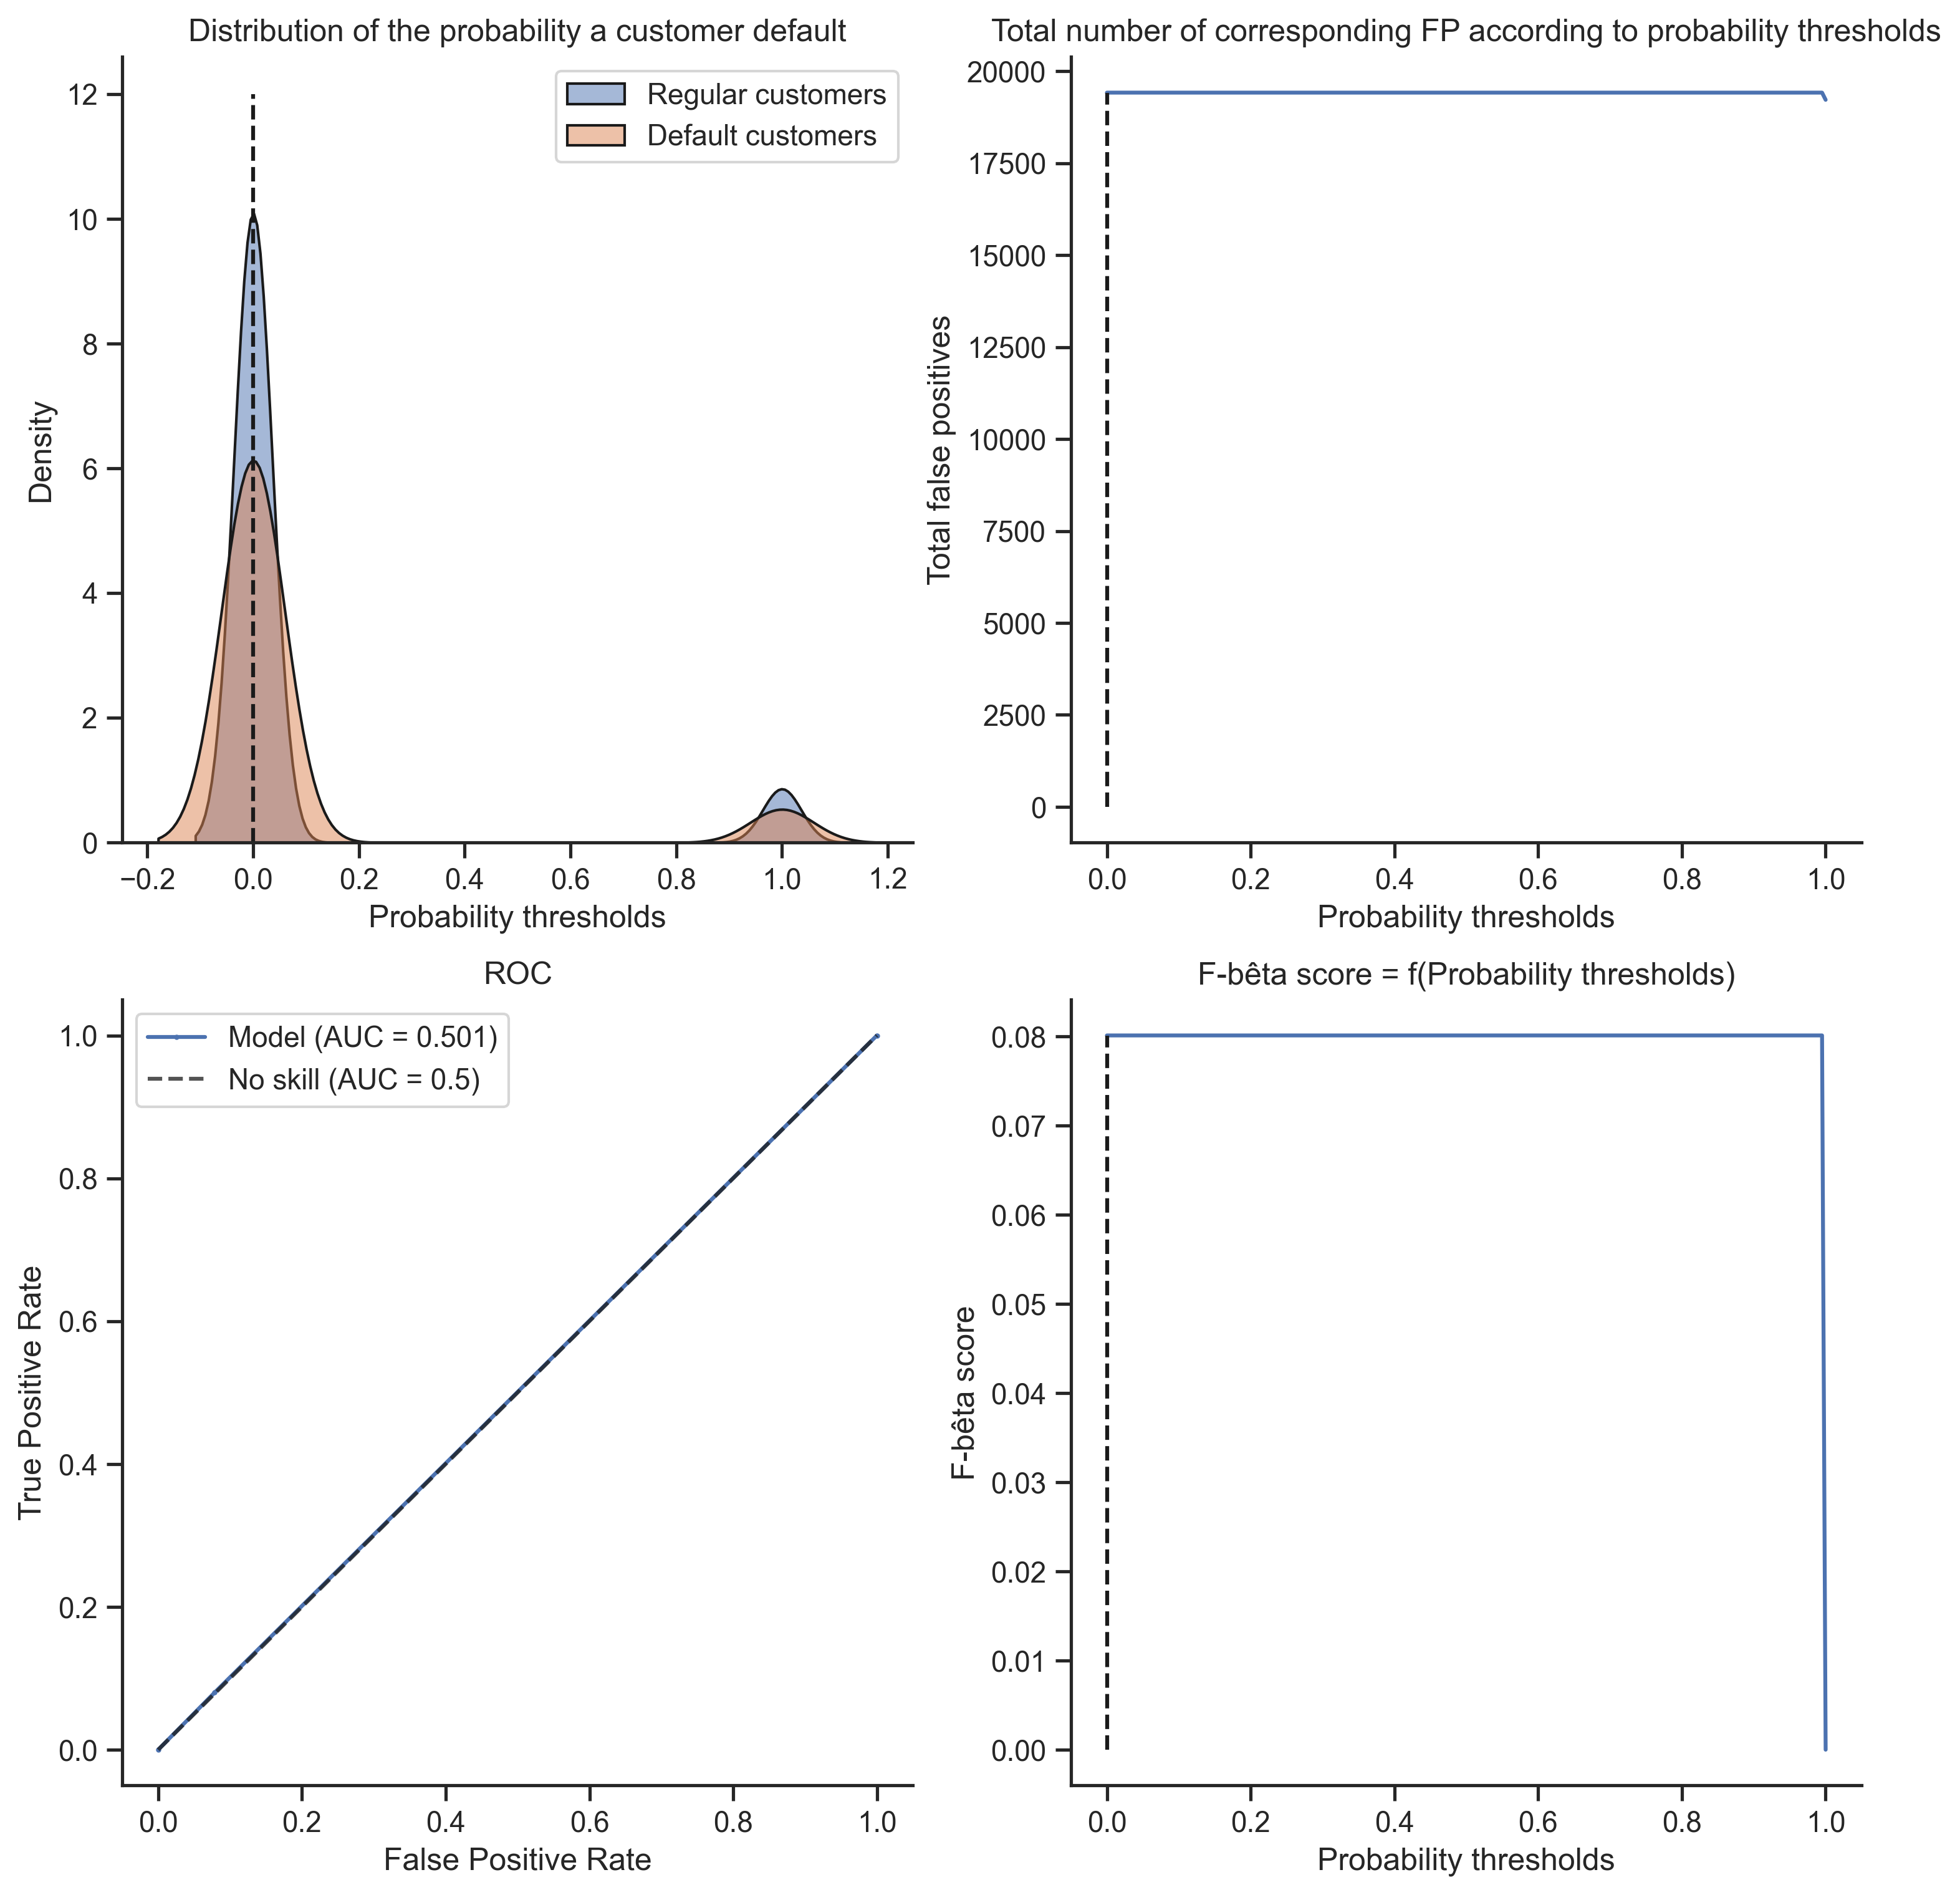


----------------------------------------------------------------------------------------------------

The new score is inferior to the one already saved.
Dataframe not saved.


Models   
Model_labels                                                      
dummy_clf                DummyClassifier(strategy='stratified')  \
logi_reg_opt  LogisticRegression(C=100.0, class_weight='bala...   
rf_clf_opt    (DecisionTreeClassifier(max_depth=10, max_feat...   
xgb_clf_opt   XGBClassifier(base_score=None, booster=None, c...   
lgbm_clf_opt  LGBMClassifier(class_weight='balanced', colsam...   

                                                     yhat_train   
Model_labels                                                      
dummy_clf     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.5950216861017936, 0.5400718415302808, 0.430...   
rf_clf_opt    [0.5443689719737853, 0.6585302236646584, 0.177...   
xgb_clf_opt   [0.5688134, 0.62018585, 0.15535076, 0.42749348...   
lgbm_clf_opt  [0.6142795453522419, 0.6490163088635007, 0.246...   

                                                      yhat_test   
Model_labels                                                      
dummy_clf     [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.34288296588972866, 0.4585440415379346, 0.56...   
rf_clf_opt    [0.40621306915551864, 0.32463278231053183, 0.1...   
xgb_clf_opt   [0.3637119, 0.47850734, 0.07989965, 0.32197857...   
lgbm_clf_opt  [0.5517143544597476, 0.38818625549996316, 0.16...   

              Best_proba_threshold_train Best_proba_threshold_test   
Model_labels                                                         
dummy_clf                          1.000                       1.0  \
logi_reg_opt                       0.475                     0.475   
rf_clf_opt                         0.400                      0.31   
xgb_clf_opt                        0.475                     0.465   
lgbm_clf_opt                       0.505                     0.485   

              Job_score_train Job_score_test  AUROC_scores_train   
Model_labels                                                       
dummy_clf            0.534591       0.534884            0.499999  \
logi_reg_opt         0.587815       0.581008            0.618610   
rf_clf_opt           0.668959       0.635465            0.727212   
xgb_clf_opt          0.684892         0.6625            0.741560   
lgbm_clf_opt         0.681817       0.651357            0.742423   

             AUROC_scores_test  F-bêta_score_train F-bêta_score_test   
Model_labels                                                           
dummy_clf             0.494565            0.078063          0.066694  \
logi_reg_opt          0.601764            0.897919          0.897778   
rf_clf_opt            0.698339            0.897898          0.900479   
xgb_clf_opt           0.706817            0.898201          0.897944   
lgbm_clf_opt          0.702991            0.898531          0.898577   

              Process_time_train (s) Process_time_test (s)  
Model_labels                                                
dummy_clf                   0.110721              0.019011  
logi_reg_opt                3.038564              0.370336  
rf_clf_opt                  7.106856              1.710559  
xgb_clf_opt                 3.163377              1.121018  
lgbm_clf_opt                1.303183              0.516469

CPU times: total: 9.28 s
Wall time: 7.77 s


In [35]:
%%time

# Initialize local variables.
model = dummy_clf
model_label = 'dummy_clf'
eval_dataset = 'valid_set'
get_csv_file = GET_CSV_FILE


# Train the model and get its predictions probabilities.
y_pred_proba_NP, process_time = model_fit_predict(model)

print('sklearn cross val score =', np.mean(cross_val_score(model, X_TRAIN, y_TRAIN, scoring='roc_auc', cv=SKF_5, n_jobs=-1)))

# Evaluate the model.
best_thr, g_norm, rocauc, fbeta = evaluate(y_pred_proba_NP[:,1], y_true=y_TRAIN)


# Store the relevant values in the model storage dataframe.
l_vars = [model_label, model, y_pred_proba_NP[:,1], best_thr, g_norm, rocauc, fbeta, process_time]

# Update the csv file if the main score is higher and the user allowed it.
print("\n" + "-" * 100 + "\n")
df_MODELS = update_sum_table(df_MODELS, l_vars, get_csv_file, eval_dataset)
                        
# Show the table.
display(df_MODELS)

#### iii. Generalization over the testset


ROC-AUC = 0.497600
F-Bêta score of the optimal threshold found = 0.000
Highest F-Bêta score = 0.077
Job score: 0.535

----------------------------------------------------------------------------------------------------



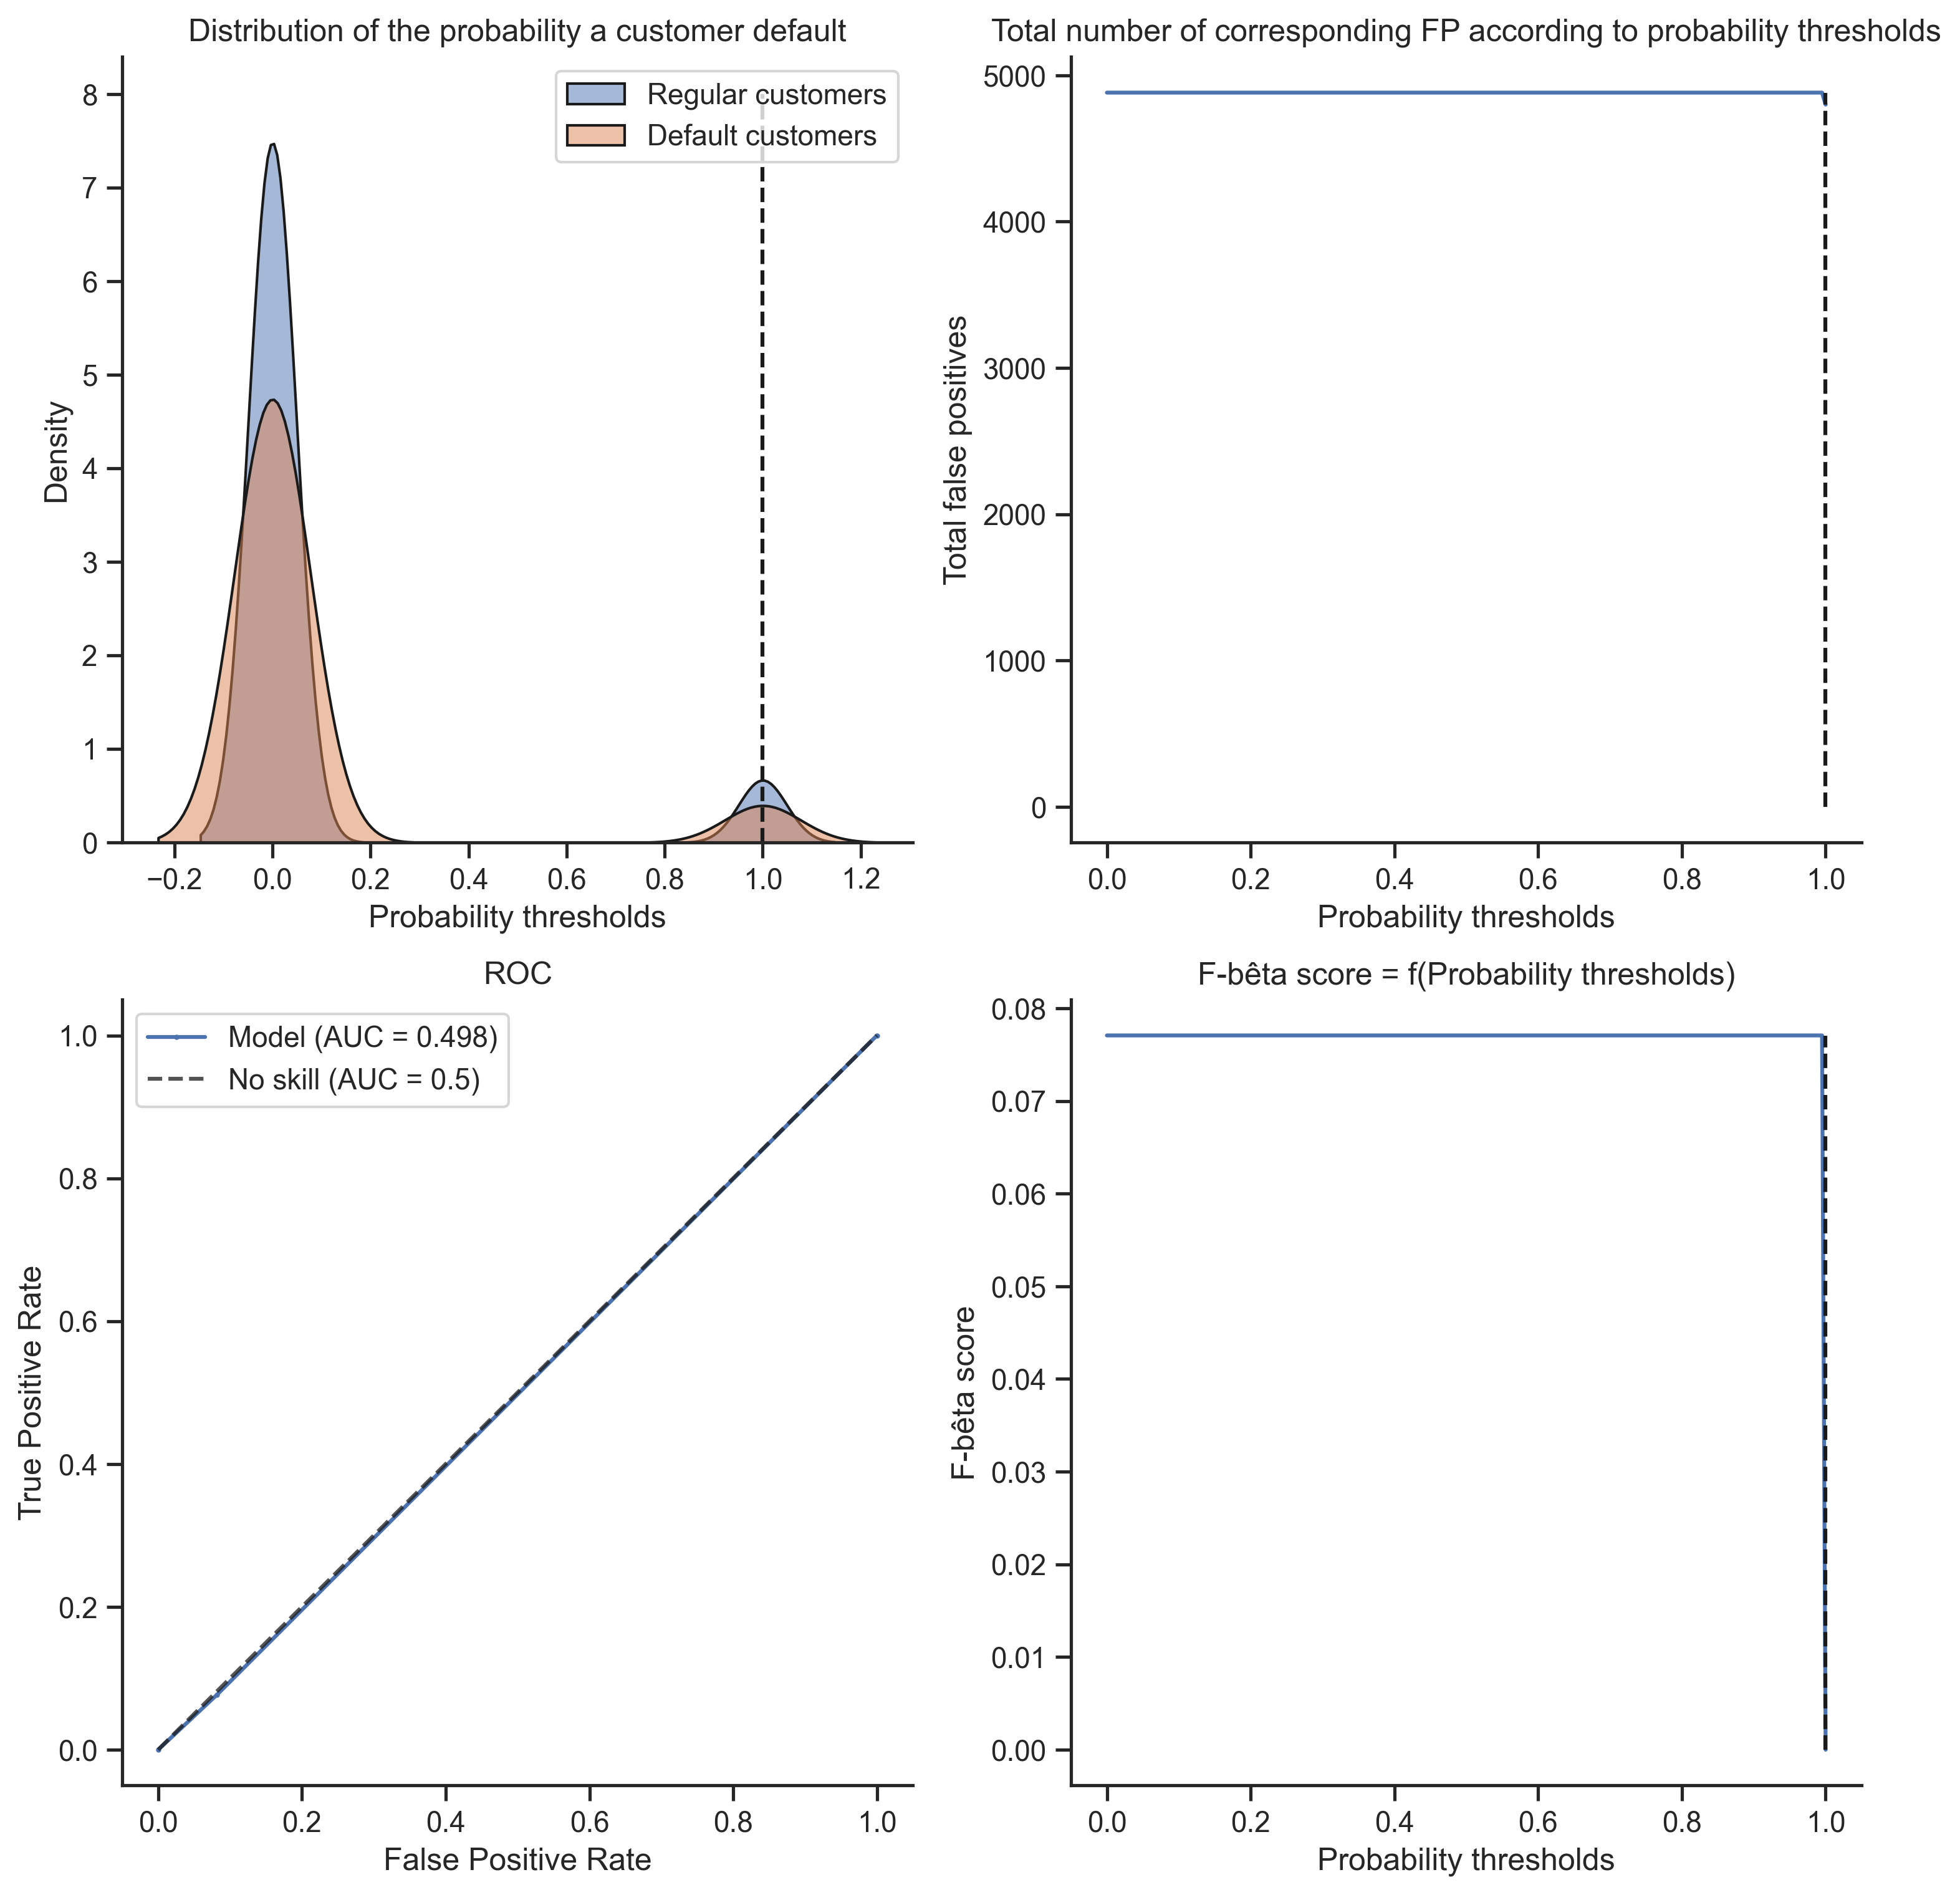


----------------------------------------------------------------------------------------------------

The new score is inferior to the one already saved.
Dataframe not saved.


Models   
Model_labels                                                      
dummy_clf                DummyClassifier(strategy='stratified')  \
logi_reg_opt  LogisticRegression(C=100.0, class_weight='bala...   
rf_clf_opt    (DecisionTreeClassifier(max_depth=10, max_feat...   
xgb_clf_opt   XGBClassifier(base_score=None, booster=None, c...   
lgbm_clf_opt  LGBMClassifier(class_weight='balanced', colsam...   

                                                     yhat_train   
Model_labels                                                      
dummy_clf     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.5950216861017936, 0.5400718415302808, 0.430...   
rf_clf_opt    [0.5443689719737853, 0.6585302236646584, 0.177...   
xgb_clf_opt   [0.5688134, 0.62018585, 0.15535076, 0.42749348...   
lgbm_clf_opt  [0.6142795453522419, 0.6490163088635007, 0.246...   

                                                      yhat_test   
Model_labels                                                      
dummy_clf     [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.34288296588972866, 0.4585440415379346, 0.56...   
rf_clf_opt    [0.40621306915551864, 0.32463278231053183, 0.1...   
xgb_clf_opt   [0.3637119, 0.47850734, 0.07989965, 0.32197857...   
lgbm_clf_opt  [0.5517143544597476, 0.38818625549996316, 0.16...   

              Best_proba_threshold_train Best_proba_threshold_test   
Model_labels                                                         
dummy_clf                          1.000                       1.0  \
logi_reg_opt                       0.475                     0.475   
rf_clf_opt                         0.400                      0.31   
xgb_clf_opt                        0.475                     0.465   
lgbm_clf_opt                       0.505                     0.485   

              Job_score_train Job_score_test  AUROC_scores_train   
Model_labels                                                       
dummy_clf            0.534591       0.534884            0.499999  \
logi_reg_opt         0.587815       0.581008            0.618610   
rf_clf_opt           0.668959       0.635465            0.727212   
xgb_clf_opt          0.684892         0.6625            0.741560   
lgbm_clf_opt         0.681817       0.651357            0.742423   

             AUROC_scores_test  F-bêta_score_train F-bêta_score_test   
Model_labels                                                           
dummy_clf             0.494565            0.078063          0.066694  \
logi_reg_opt          0.601764            0.897919          0.897778   
rf_clf_opt            0.698339            0.897898          0.900479   
xgb_clf_opt           0.706817            0.898201          0.897944   
lgbm_clf_opt          0.702991            0.898531          0.898577   

              Process_time_train (s) Process_time_test (s)  
Model_labels                                                
dummy_clf                   0.110721              0.019011  
logi_reg_opt                3.038564              0.370336  
rf_clf_opt                  7.106856              1.710559  
xgb_clf_opt                 3.163377              1.121018  
lgbm_clf_opt                1.303183              0.516469

CPU times: total: 5.59 s
Wall time: 2.97 s


In [36]:
%%time

# Initialize local variables.
model = dummy_clf
model_label = 'dummy_clf'
eval_dataset = 'test_set'
get_csv_file = GET_CSV_FILE


# Train the model and get its predictions probabilities.
y_pred_proba_NP, process_time = model_fit_predict(model, X=X_TEST, y=y_TEST)


#print('sklearn score =', model.score(X_TEST, y_TEST, scoring='roc_auc', cv=SKF_5, n_jobs=-1))

# Evaluate the model.
best_thr, g_norm, rocauc, fbeta = evaluate(y_pred_proba_NP[:,1], y_true=y_TEST)


# Store the relevant values in the model storage dataframe.
l_vars = [model_label, model, y_pred_proba_NP[:,1], best_thr, g_norm, rocauc, fbeta, process_time]

# Update the csv file if the main score is higher and the user allowed it.
print("\n" + "-" * 100 + "\n")
df_MODELS = update_sum_table(df_MODELS, l_vars, get_csv_file, eval_dataset)
                        
# Show the table.
display(df_MODELS)

### b) Logistic regressor

#### i. Hyperparameters tuning

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
# Initiliaze the model with its default values.
logi_reg = LogisticRegression(class_weight='balanced')

In [39]:
# Get the list of the model's hyperparameters.
pprint(logi_reg.get_params(), compact=True)

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [40]:
# Set the value's ranges to try for the selected hypermarameters to tune.
C = [x for x in np.logspace(start=-5, stop=2, num=8)]

# Create the hypermeters dictionary.
para_grid = {'C': C}

# Show the hyperparameters list and their associated range of values to try.
print("Hyperameters tuning ranges:")
print(para_grid)

Hyperameters tuning ranges:
{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}


In [41]:
%%time

# True: Tune hyperparameters, False: Get the last tuned results stored.
tune = HT

# Tune the hyperparameters of the model.
if tune:
    model_grid = hyper_tune_rand_grid(logi_reg, X_TRAIN, y_TRAIN, para_grid, g_norm_scorer, SKF_5,
                                      n_iter=5, grid_loop=1, range_precision=None, rand_state=0, verbose=3)

    # Get the model set with the best hyperparameters found.
    logi_reg_opt = model_grid.best_estimator_

# Load the last values calculated for the hyperparameters.
else:
    df_MODELS = pd.read_pickle(os.path.join(EXPORTS_MODELS_DIR_PATH, PKL_MODELS_FILE))#.set_index('Model_labels')
    logi_reg_opt = df_MODELS.loc['Logi_reg_opt', 'Models']
    
print()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best estimator found:
 LogisticRegression(C=100.0, class_weight='balanced')

Best score found:
 score = 0.596

Best hyperparameters found:
 {'C': 100.0}

CPU times: total: 2.64 s
Wall time: 9.15 s


In [42]:
### Beysian optimization ###

# Set the KFold cross validation with the selected n_folds.
#skf = StratifiedKFold(5, shuffle=True, random_state=0)
#search_space = {'C': hp.loguniform('C', math.log10(0.00001), math.log10(1.0)),
#                'proba_thr': hp.quniform('proba_thr', 0.0, 1.0, 0.01)}


#test = hyper_tune_bayes(logi_reg, search_space, model_label='lr', cv=skf,
#                        max_eval=3, action=1)# eval_metric=roc_auc_score, eval_metric_label='auroc' )

#### ii. Evalutation of the optimized model performances

sklearn cross val score = 0.6189226610078267

ROC-AUC = 0.618610
F-Bêta score of the optimal threshold found = 0.626
Highest F-Bêta score = 0.898
Job score: 0.588

----------------------------------------------------------------------------------------------------



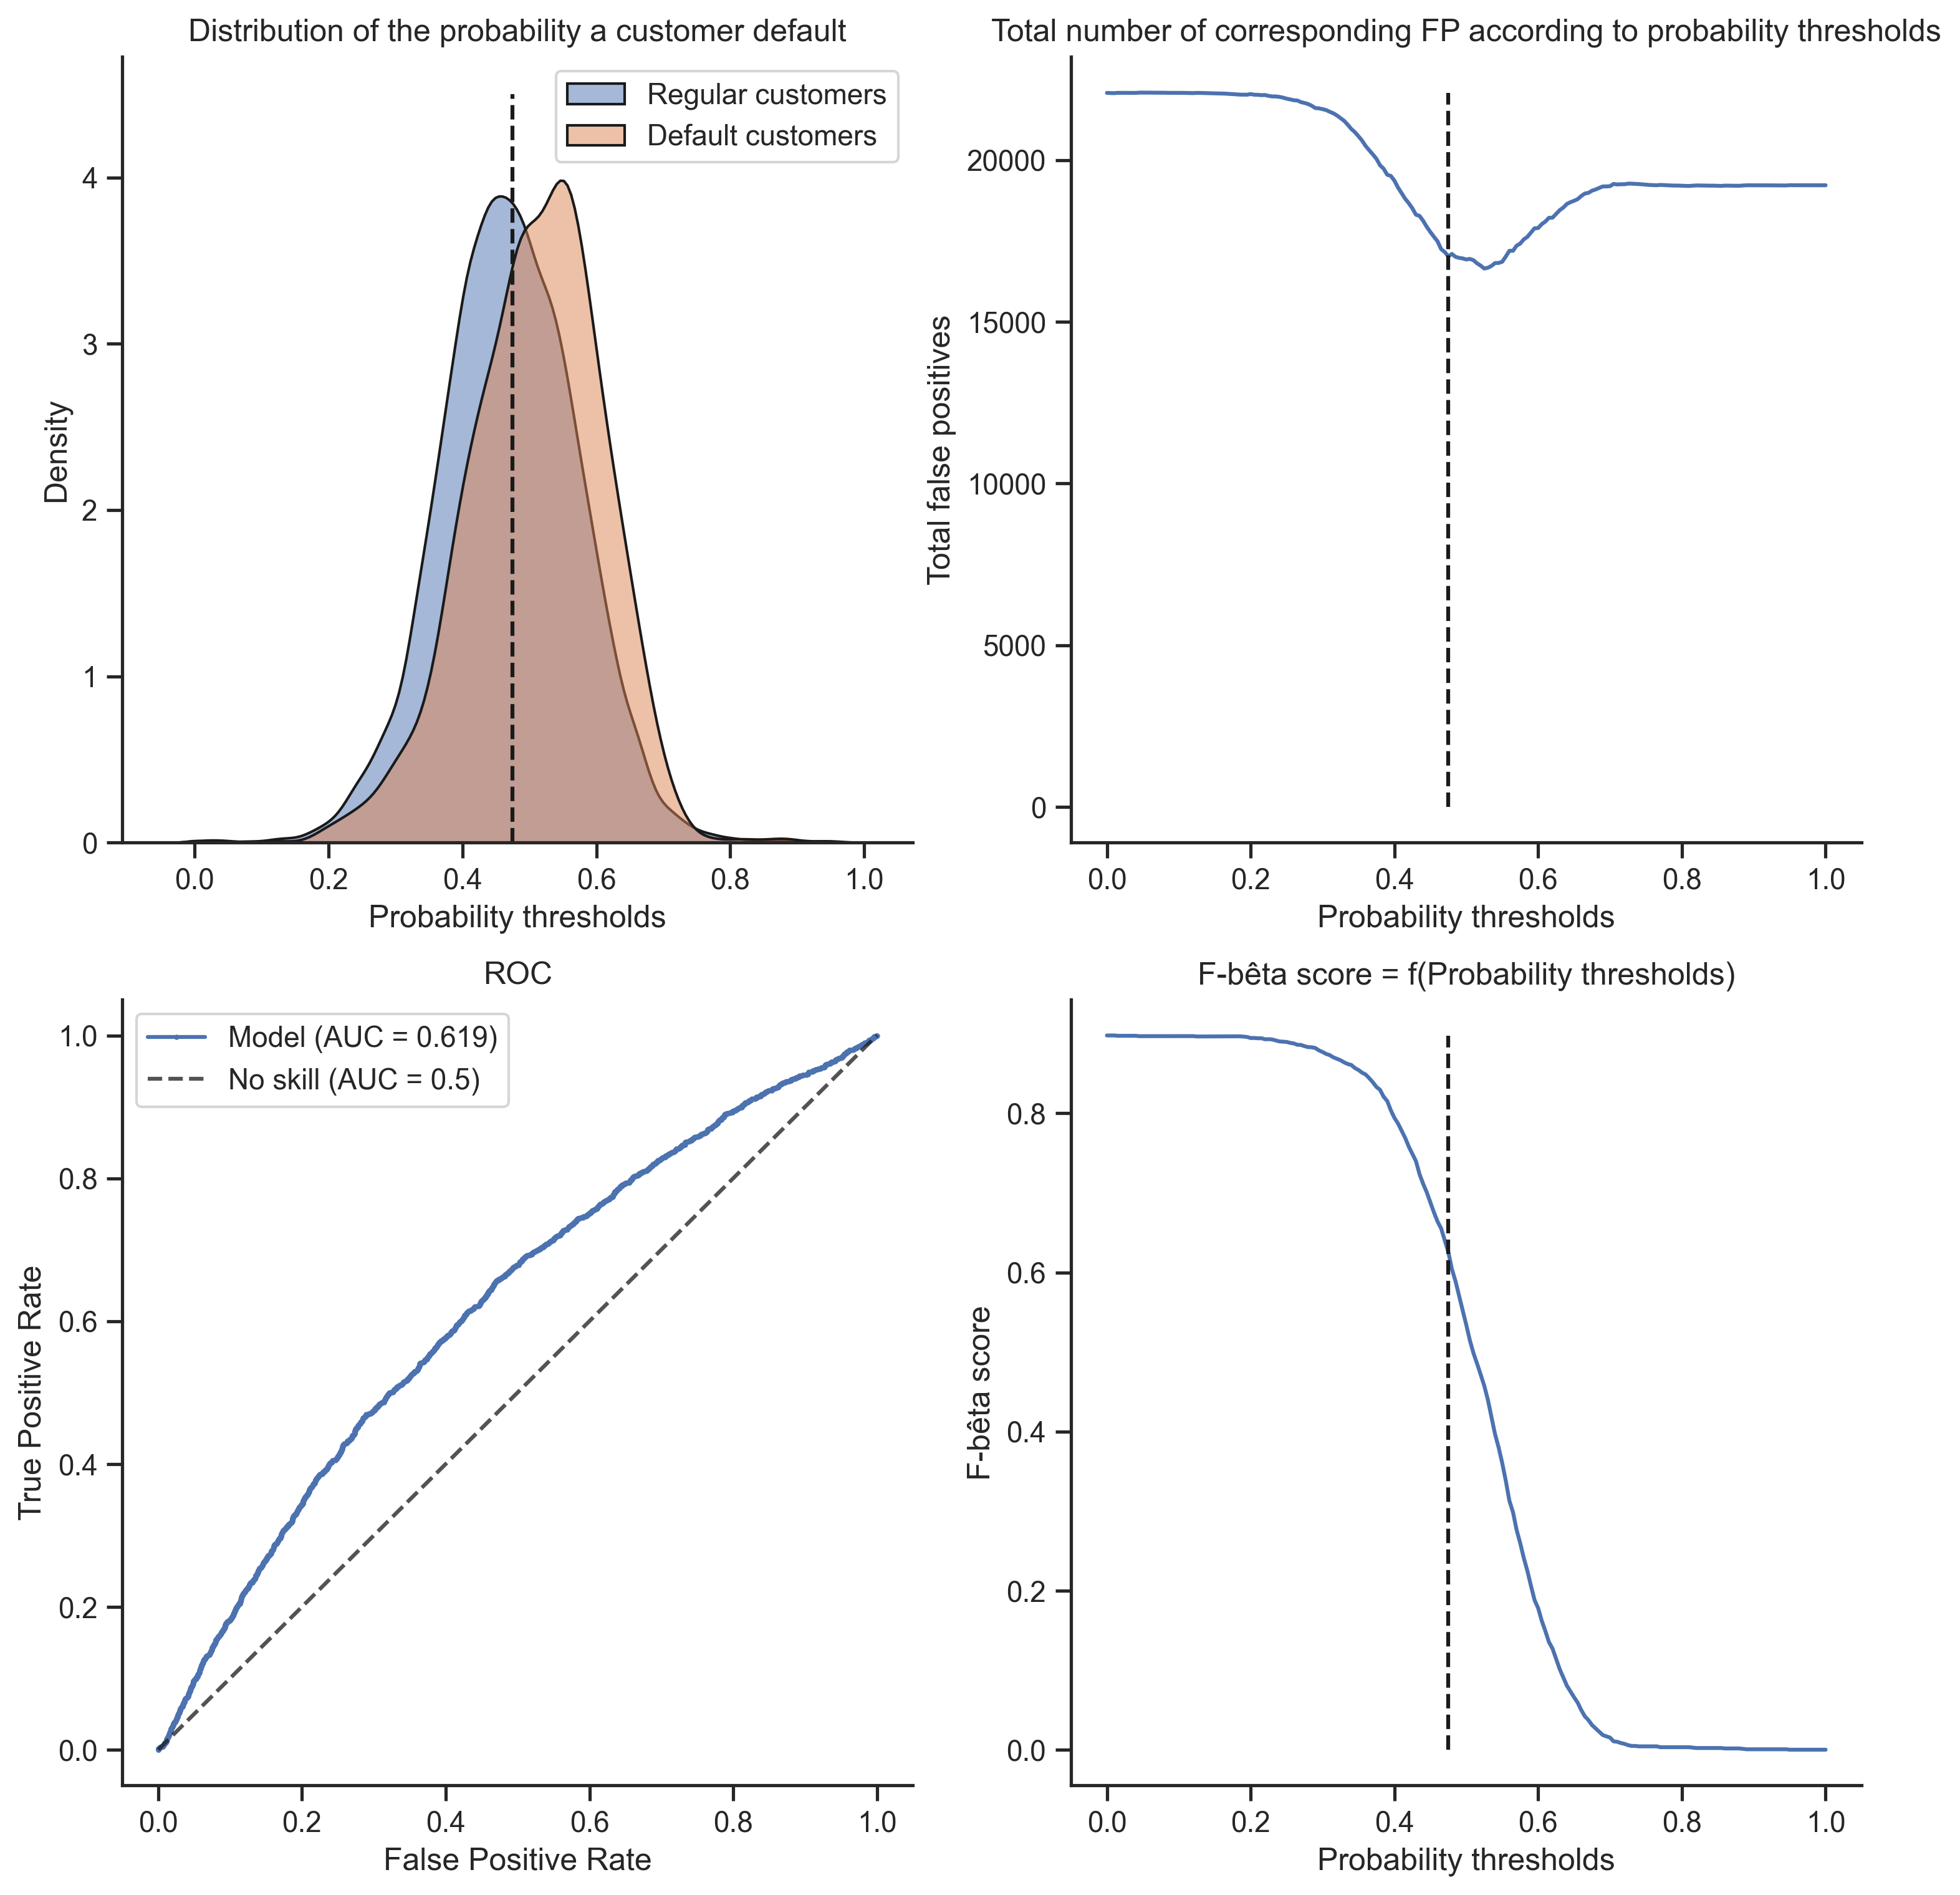


----------------------------------------------------------------------------------------------------

Updating entry...
Done!
The row have been updated.


Models   
Model_labels                                                      
dummy_clf                DummyClassifier(strategy='stratified')  \
logi_reg_opt  LogisticRegression(C=100.0, class_weight='bala...   
rf_clf_opt    (DecisionTreeClassifier(max_depth=10, max_feat...   
xgb_clf_opt   XGBClassifier(base_score=None, booster=None, c...   
lgbm_clf_opt  LGBMClassifier(class_weight='balanced', colsam...   

                                                     yhat_train   
Model_labels                                                      
dummy_clf     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.5950216861017936, 0.5400718415302808, 0.430...   
rf_clf_opt    [0.5443689719737853, 0.6585302236646584, 0.177...   
xgb_clf_opt   [0.5688134, 0.62018585, 0.15535076, 0.42749348...   
lgbm_clf_opt  [0.6142795453522419, 0.6490163088635007, 0.246...   

                                                      yhat_test   
Model_labels                                                      
dummy_clf     [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.34288296588972866, 0.4585440415379346, 0.56...   
rf_clf_opt    [0.40621306915551864, 0.32463278231053183, 0.1...   
xgb_clf_opt   [0.3637119, 0.47850734, 0.07989965, 0.32197857...   
lgbm_clf_opt  [0.5517143544597476, 0.38818625549996316, 0.16...   

              Best_proba_threshold_train Best_proba_threshold_test   
Model_labels                                                         
dummy_clf                          1.000                       1.0  \
logi_reg_opt                       0.475                     0.475   
rf_clf_opt                         0.400                      0.31   
xgb_clf_opt                        0.475                     0.465   
lgbm_clf_opt                       0.505                     0.485   

              Job_score_train Job_score_test  AUROC_scores_train   
Model_labels                                                       
dummy_clf            0.534591       0.534884            0.499999  \
logi_reg_opt         0.587815       0.581008            0.618610   
rf_clf_opt           0.668959       0.635465            0.727212   
xgb_clf_opt          0.684892         0.6625            0.741560   
lgbm_clf_opt         0.681817       0.651357            0.742423   

             AUROC_scores_test  F-bêta_score_train F-bêta_score_test   
Model_labels                                                           
dummy_clf             0.494565            0.078063          0.066694  \
logi_reg_opt          0.601764            0.897919          0.897778   
rf_clf_opt            0.698339            0.897898          0.900479   
xgb_clf_opt           0.706817            0.898201          0.897944   
lgbm_clf_opt          0.702991            0.898531          0.898577   

              Process_time_train (s) Process_time_test (s)  
Model_labels                                                
dummy_clf                   0.110721              0.019011  
logi_reg_opt                2.928672              0.370336  
rf_clf_opt                  7.106856              1.710559  
xgb_clf_opt                 3.163377              1.121018  
lgbm_clf_opt                1.303183              0.516469

CPU times: total: 11.4 s
Wall time: 9.52 s


In [43]:
%%time

# Initialize local variables.
model = logi_reg_opt
model_label = 'logi_reg_opt'
eval_dataset = 'valid_set'
get_csv_file = GET_CSV_FILE


# Train the model and get its predictions probabilities.
y_pred_proba_NP, process_time = model_fit_predict(model)


print('sklearn cross val score =', np.mean(cross_val_score(model, X_TRAIN, y_TRAIN, scoring='roc_auc', cv=SKF_5, n_jobs=-1)))

# Evaluate the model.
best_thr, g_norm, rocauc, fbeta = evaluate(y_pred_proba_NP[:,1], y_true=y_TRAIN)


# Store the relevant values in the model storage dataframe.
l_vars = [model_label, model, y_pred_proba_NP[:,1], best_thr, g_norm, rocauc, fbeta, process_time]

# Update the csv file if the main score is higher and the user allowed it.
print("\n" + "-" * 100 + "\n")
df_MODELS = update_sum_table(df_MODELS, l_vars, get_csv_file, eval_dataset, force_update=True)
                        
# Show the table.
display(df_MODELS)

#### iii. Generalization over the test set


ROC-AUC = 0.601764
F-Bêta score of the optimal threshold found = 0.626
Highest F-Bêta score = 0.898
Job score: 0.581

----------------------------------------------------------------------------------------------------



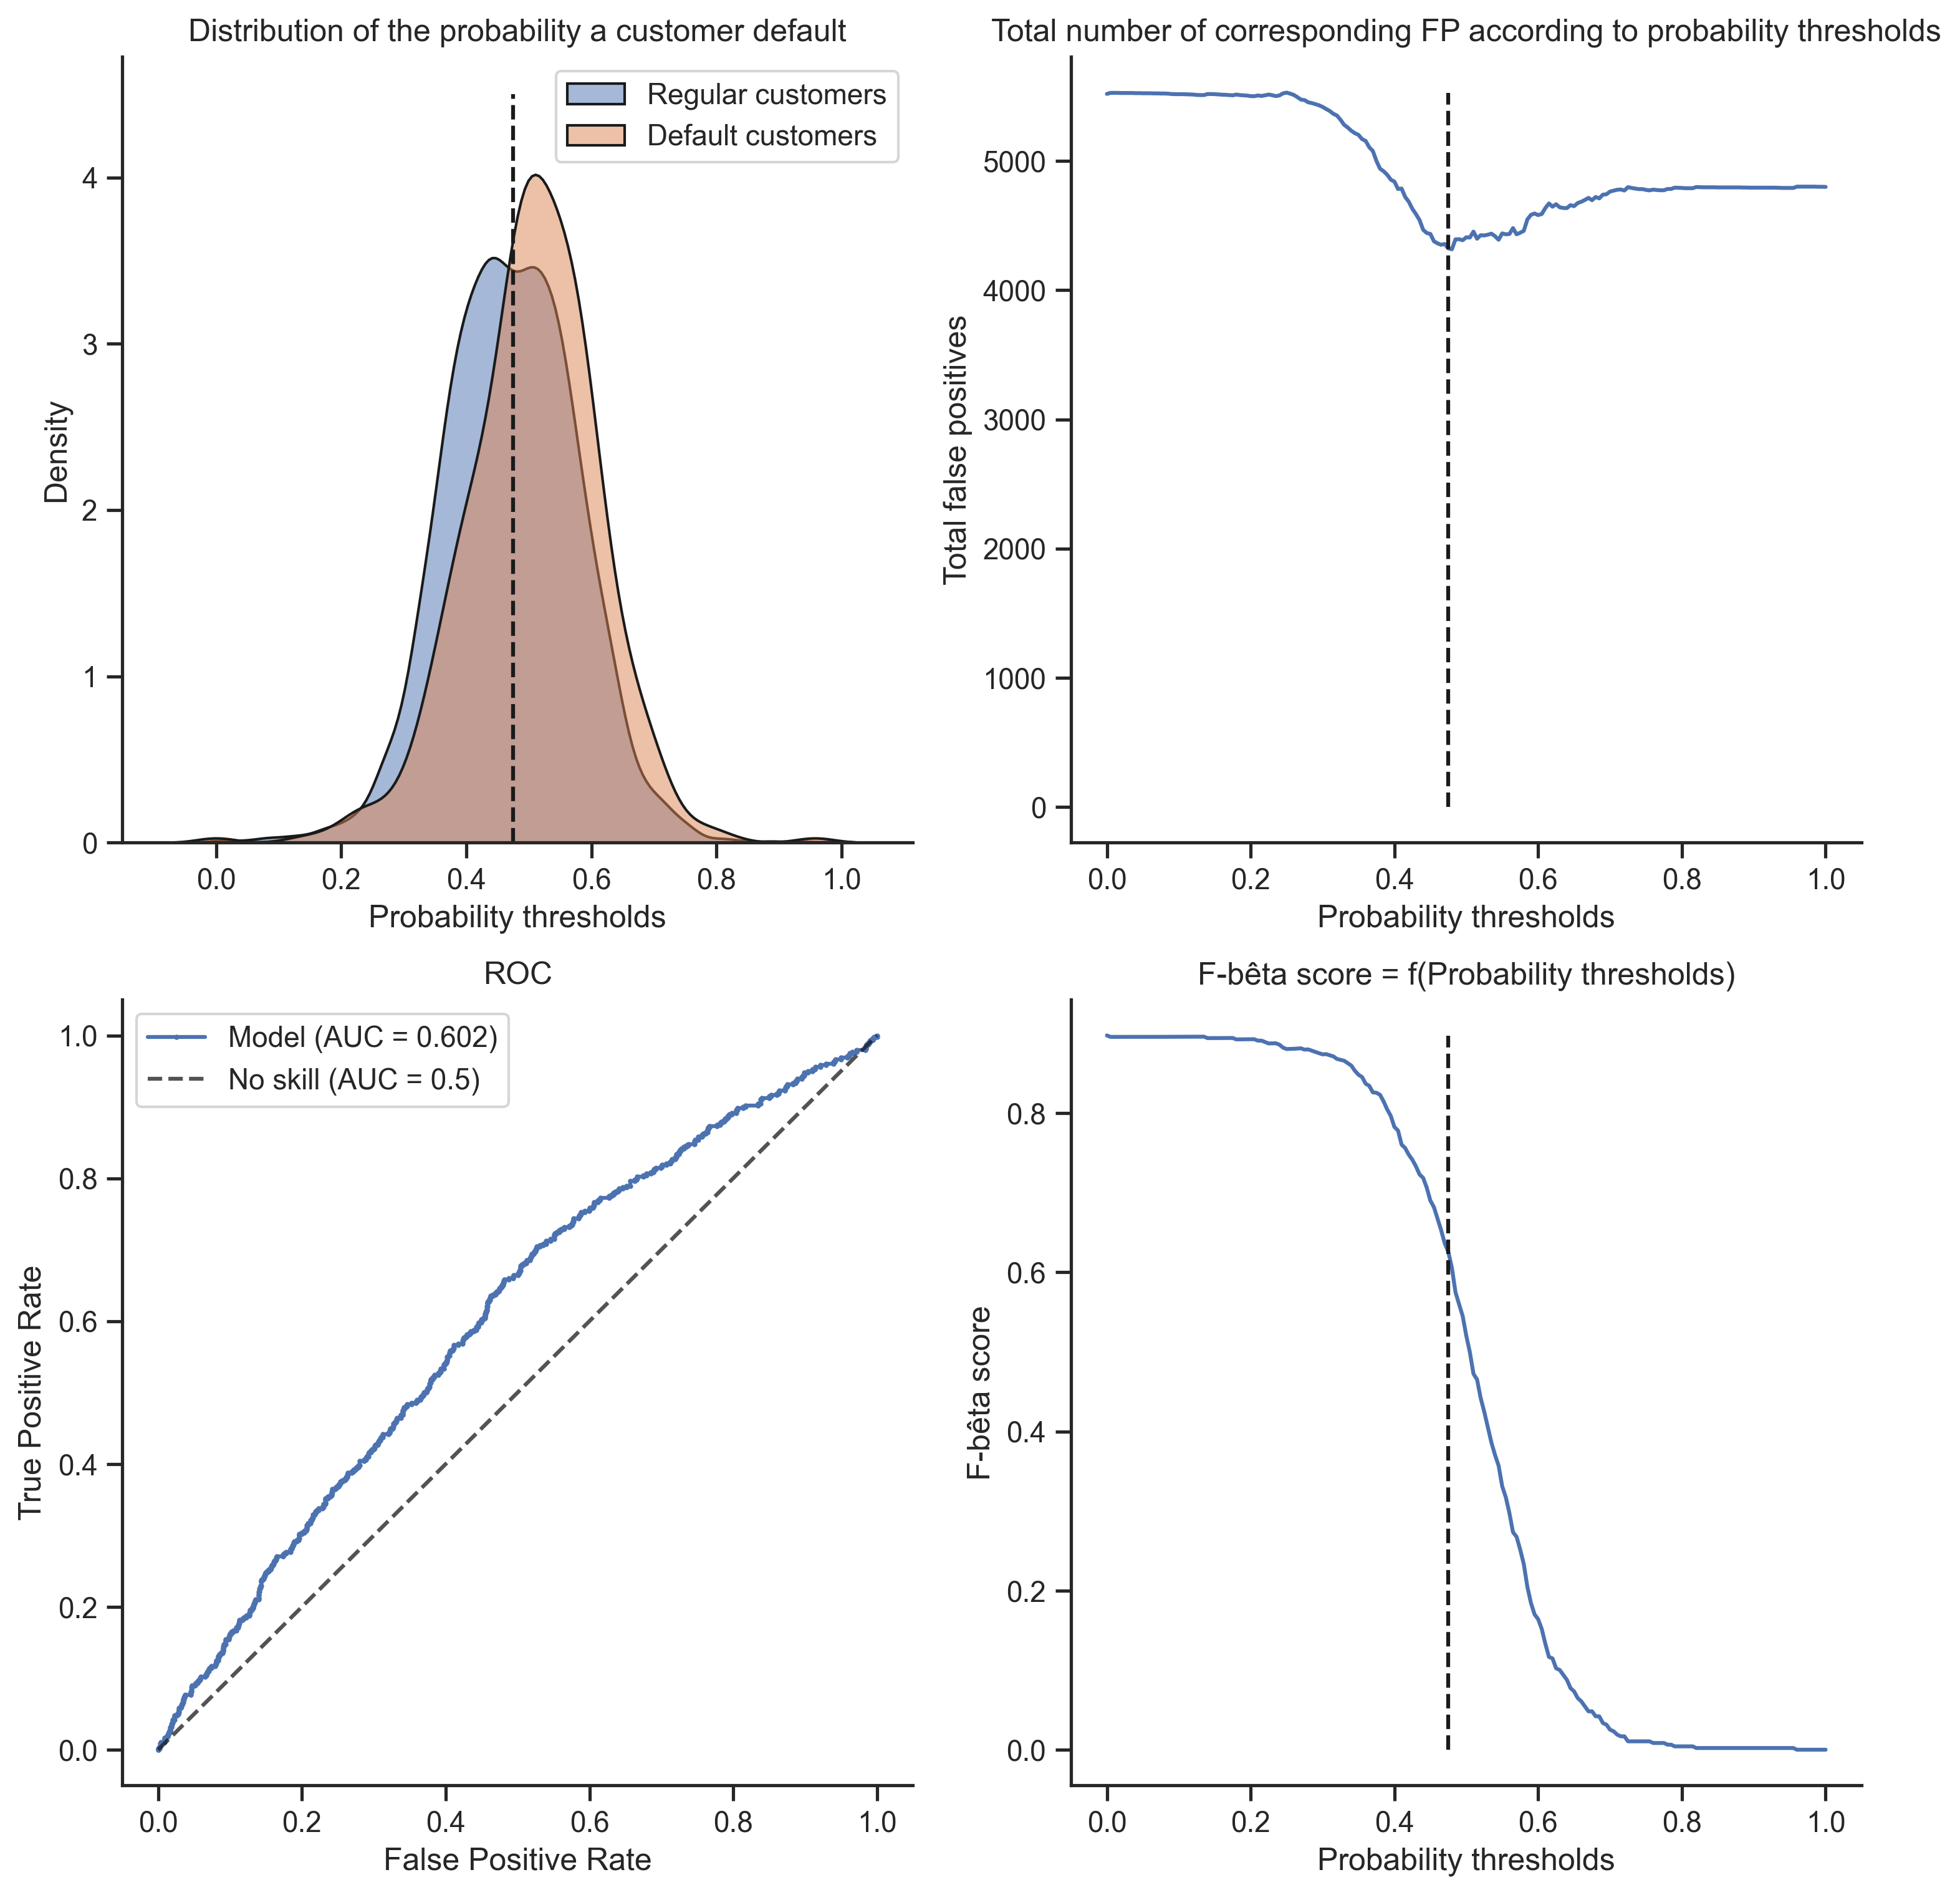


----------------------------------------------------------------------------------------------------

Updating entry...
Done!
The row have been updated.


Models   
Model_labels                                                      
dummy_clf                DummyClassifier(strategy='stratified')  \
logi_reg_opt  LogisticRegression(C=100.0, class_weight='bala...   
rf_clf_opt    (DecisionTreeClassifier(max_depth=10, max_feat...   
xgb_clf_opt   XGBClassifier(base_score=None, booster=None, c...   
lgbm_clf_opt  LGBMClassifier(class_weight='balanced', colsam...   

                                                     yhat_train   
Model_labels                                                      
dummy_clf     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.5950216861017936, 0.5400718415302808, 0.430...   
rf_clf_opt    [0.5443689719737853, 0.6585302236646584, 0.177...   
xgb_clf_opt   [0.5688134, 0.62018585, 0.15535076, 0.42749348...   
lgbm_clf_opt  [0.6142795453522419, 0.6490163088635007, 0.246...   

                                                      yhat_test   
Model_labels                                                      
dummy_clf     [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.34288296588972866, 0.4585440415379346, 0.56...   
rf_clf_opt    [0.40621306915551864, 0.32463278231053183, 0.1...   
xgb_clf_opt   [0.3637119, 0.47850734, 0.07989965, 0.32197857...   
lgbm_clf_opt  [0.5517143544597476, 0.38818625549996316, 0.16...   

              Best_proba_threshold_train Best_proba_threshold_test   
Model_labels                                                         
dummy_clf                          1.000                       1.0  \
logi_reg_opt                       0.475                     0.475   
rf_clf_opt                         0.400                      0.31   
xgb_clf_opt                        0.475                     0.465   
lgbm_clf_opt                       0.505                     0.485   

              Job_score_train Job_score_test  AUROC_scores_train   
Model_labels                                                       
dummy_clf            0.534591       0.534884            0.499999  \
logi_reg_opt         0.587815       0.581008            0.618610   
rf_clf_opt           0.668959       0.635465            0.727212   
xgb_clf_opt          0.684892         0.6625            0.741560   
lgbm_clf_opt         0.681817       0.651357            0.742423   

             AUROC_scores_test  F-bêta_score_train F-bêta_score_test   
Model_labels                                                           
dummy_clf             0.494565            0.078063          0.066694  \
logi_reg_opt          0.601764            0.897919          0.897778   
rf_clf_opt            0.698339            0.897898          0.900479   
xgb_clf_opt           0.706817            0.898201          0.897944   
lgbm_clf_opt          0.702991            0.898531          0.898577   

              Process_time_train (s) Process_time_test (s)  
Model_labels                                                
dummy_clf                   0.110721              0.019011  
logi_reg_opt                2.928672              0.345314  
rf_clf_opt                  7.106856              1.710559  
xgb_clf_opt                 3.163377              1.121018  
lgbm_clf_opt                1.303183              0.516469

CPU times: total: 6.17 s
Wall time: 3.3 s


In [44]:
%%time

# Initialize local variables.
model = logi_reg_opt
model_label = 'logi_reg_opt'
eval_dataset = 'test_set'
get_csv_file = GET_CSV_FILE


# Train the model and get its predictions probabilities.
y_pred_proba_NP, process_time = model_fit_predict(model, X=X_TEST, y=y_TEST)


#print('sklearn score =', model.score(X_TEST, y_TEST, scoring='roc_auc', cv=SKF_5, n_jobs=-1))

# Evaluate the model.
best_thr, g_norm, rocauc, fbeta = evaluate(y_pred_proba_NP[:,1], y_true=y_TEST)


# Store the relevant values in the model storage dataframe.
l_vars = [model_label, model, y_pred_proba_NP[:,1], best_thr, g_norm, rocauc, fbeta, process_time]


# Update the csv file if the main score is higher and the user allowed it.
print("\n" + "-" * 100 + "\n")
df_MODELS = update_sum_table(df_MODELS, l_vars, get_csv_file, eval_dataset, force_update=True)
                        
# Show the table.
display(df_MODELS)

### c) Random forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

#### i. Hyperparameters tuning

In [46]:
# Initiliaze the model with its default values.
rf_clf = RandomForestClassifier(class_weight='balanced')

In [47]:
# Get the list of the model's hyperparameters.
pprint(rf_clf.get_params(), compact=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [48]:
# Number of trees in the random forest.
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 50, num = 51)]

# Maximum number of levels in each tree.
max_depth = [int(x) for x in np.linspace(1, 100, num = 11)]

# Minimum number of samples required to split a node.
min_samples_split = [int(x) for x in np.linspace(1, 100, num = 11)]

# Use or don't bootstrap samples.
bootstrap = [True, False]

# Create the random grid
para_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap #'max_features': ['auto', 'sqrt'],
              }

# Show the hyperparameters list and their associated range of values to try.
print("Hyperameters tuning ranges:")
pprint(para_grid, compact=True)

Hyperameters tuning ranges:
{'bootstrap': [True, False],
 'max_depth': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_split': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'n_estimators': [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                  18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
                  33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
                  48, 49, 50]}


In [49]:
%%time

# True: Tune hyperparameters, False: Get the last tuned results stored.
tune = HT

# Tune the hyperparameters of the model.
if tune:
    model_grid = hyper_tune_rand_grid(rf_clf, X_TRAIN, y_TRAIN, para_grid, g_norm_scorer, SKF_5,
                                      n_iter=100, grid_loop=1, range_precision=None, rand_state=0, verbose=3)

    # Get the model set with the best hyperparameters found.
    rf_clf_opt = model_grid.best_estimator_

# Load the last values calculated for the hyperparameters.
else:
    df_MODELS = pd.read_pickle(os.path.join(EXPORTS_MODELS_DIR_PATH, PKL_MODELS_FILE))#.set_index('Model_labels')
    rf_clf_opt = df_MODELS.loc['rf_clf_opt', 'Models']
    
print()

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best estimator found:
 RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=10,
                       min_samples_split=50, n_estimators=25)

Best score found:
 score = 0.672

Best hyperparameters found:
 {'bootstrap': False, 'max_depth': 10, 'min_samples_split': 50, 'n_estimators': 25}

CPU times: total: 21.1 s
Wall time: 1min 39s


#### ii. Evaluation of the optimized model performances

sklearn cross val score = 0.7237468831057506

ROC-AUC = 0.729150
F-Bêta score of the optimal threshold found = 0.661
Highest F-Bêta score = 0.899
Job score: 0.668

----------------------------------------------------------------------------------------------------



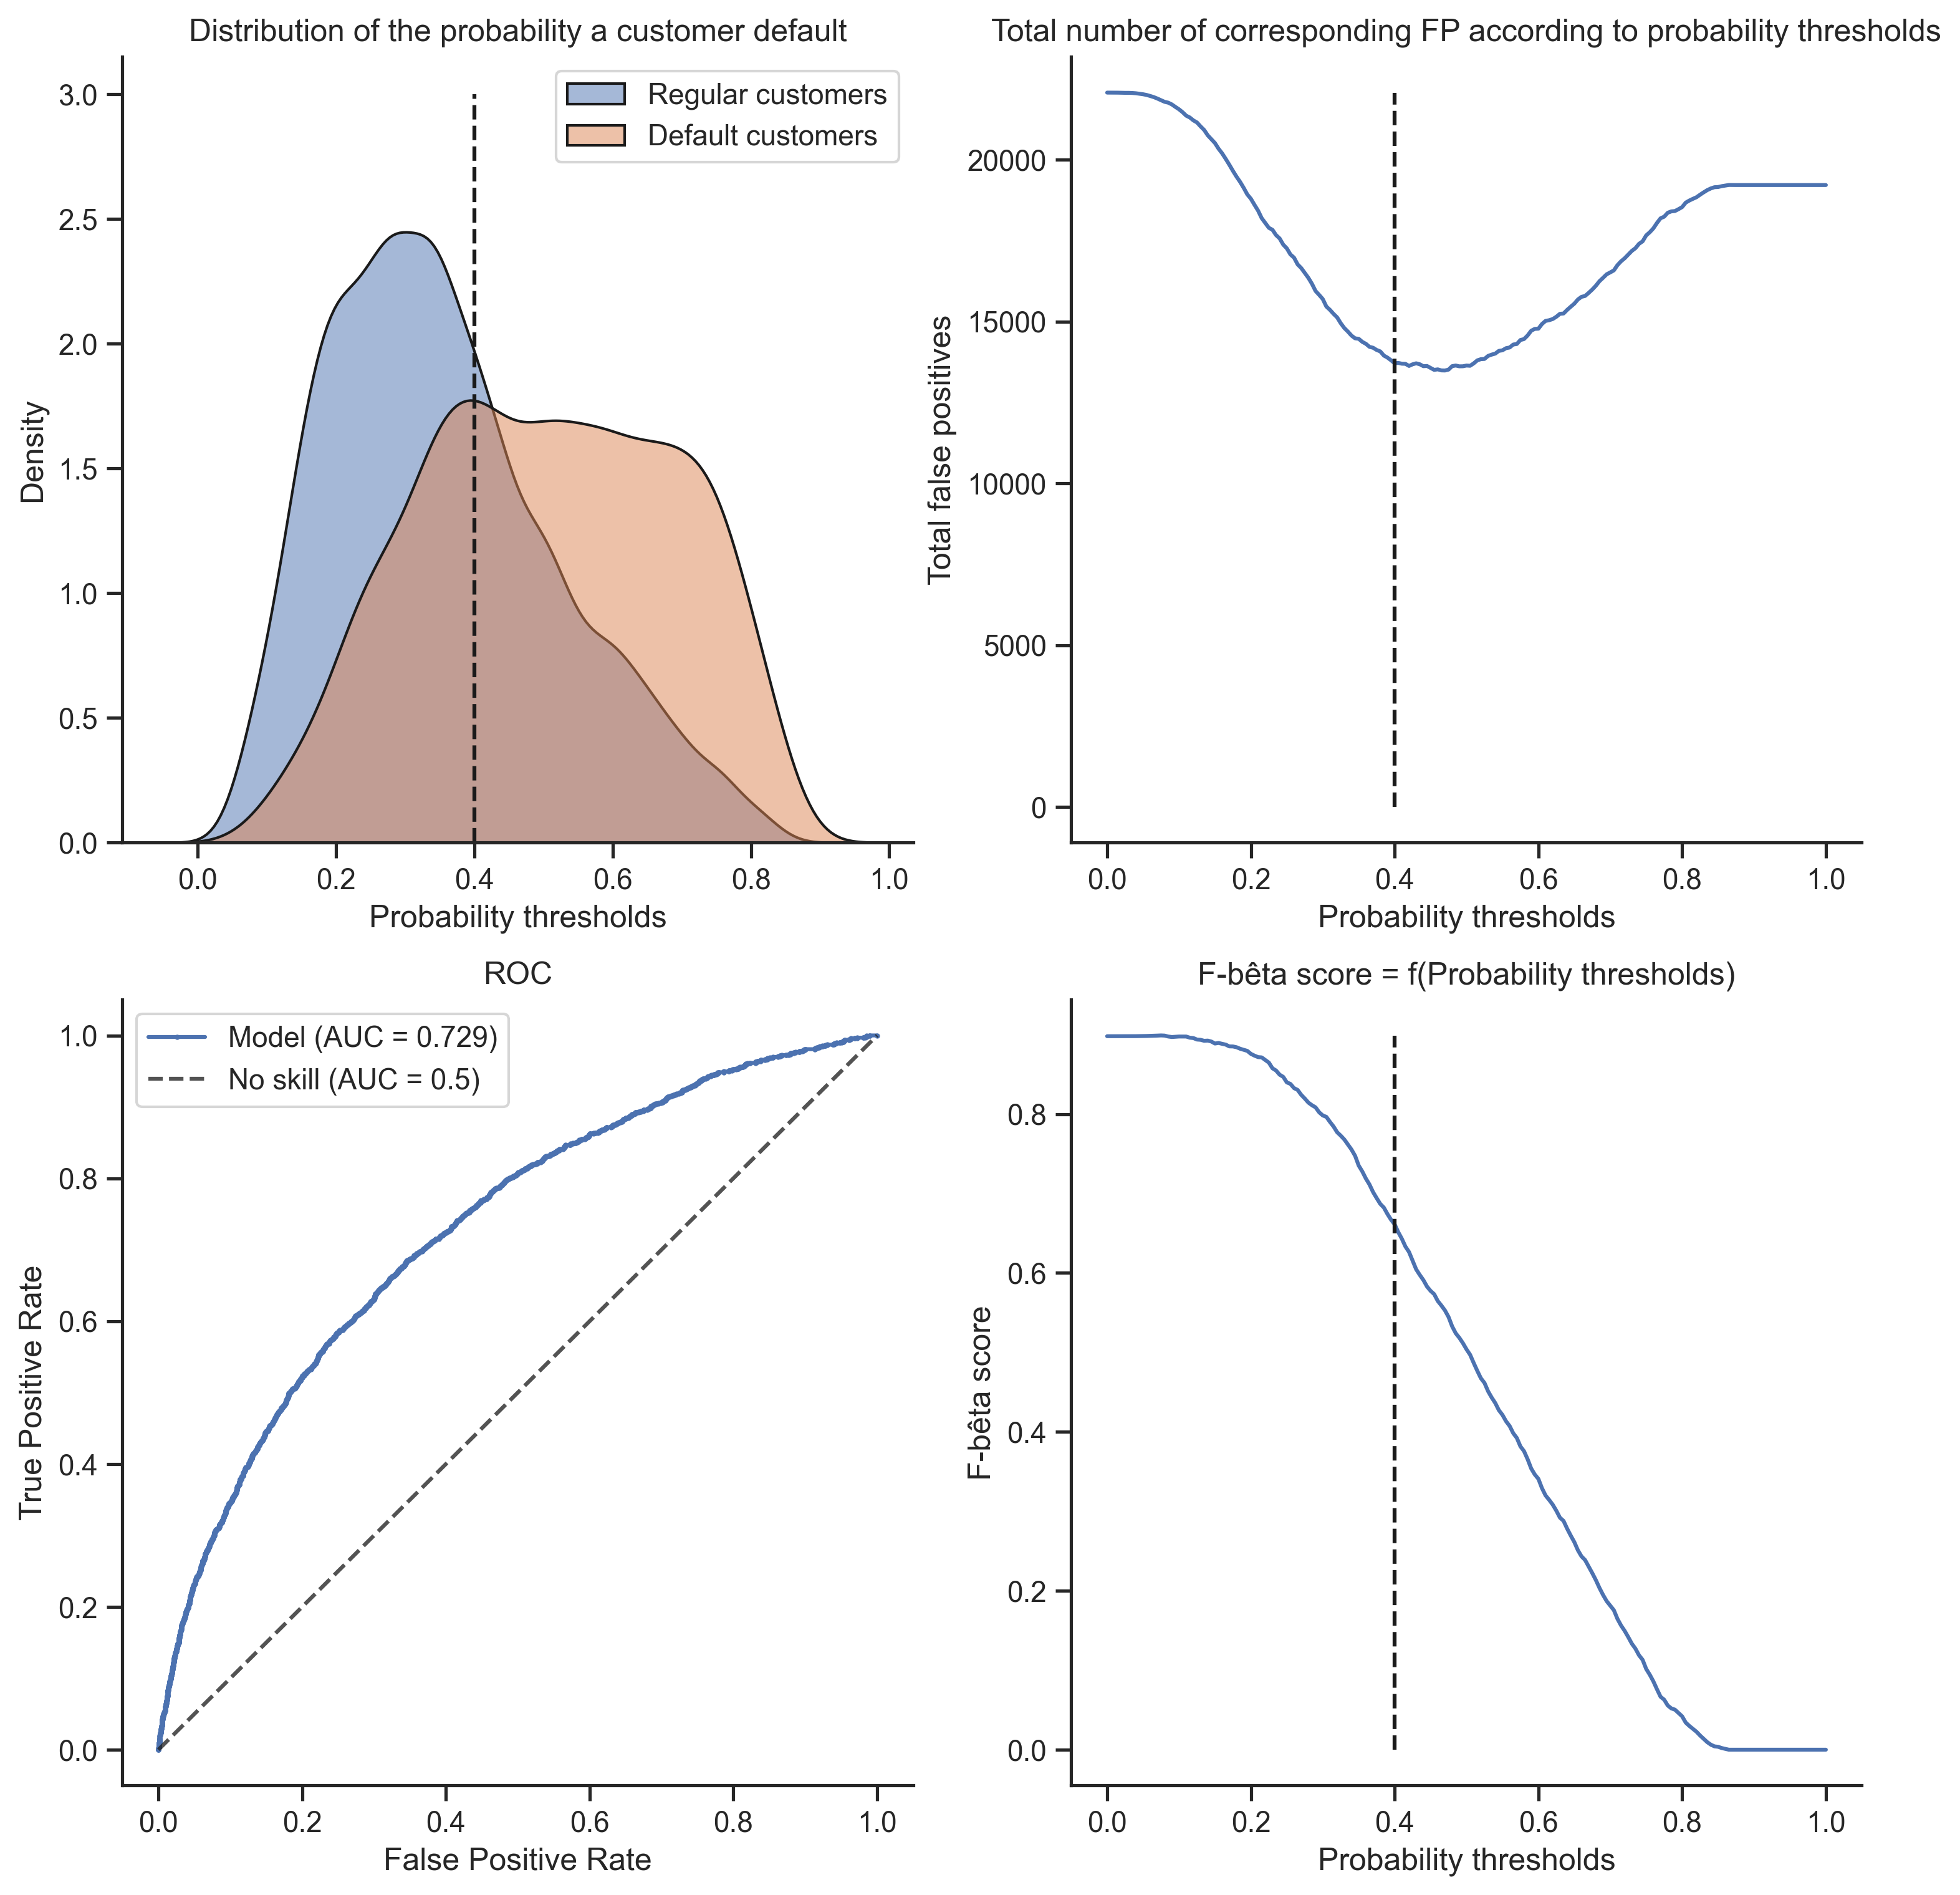


----------------------------------------------------------------------------------------------------

The new score is inferior to the one already saved.
Dataframe not saved.


Models   
Model_labels                                                      
dummy_clf                DummyClassifier(strategy='stratified')  \
logi_reg_opt  LogisticRegression(C=100.0, class_weight='bala...   
rf_clf_opt    (DecisionTreeClassifier(max_depth=10, max_feat...   
xgb_clf_opt   XGBClassifier(base_score=None, booster=None, c...   
lgbm_clf_opt  LGBMClassifier(class_weight='balanced', colsam...   

                                                     yhat_train   
Model_labels                                                      
dummy_clf     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.5950216861017936, 0.5400718415302808, 0.430...   
rf_clf_opt    [0.5443689719737853, 0.6585302236646584, 0.177...   
xgb_clf_opt   [0.5688134, 0.62018585, 0.15535076, 0.42749348...   
lgbm_clf_opt  [0.6142795453522419, 0.6490163088635007, 0.246...   

                                                      yhat_test   
Model_labels                                                      
dummy_clf     [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.34288296588972866, 0.4585440415379346, 0.56...   
rf_clf_opt    [0.40621306915551864, 0.32463278231053183, 0.1...   
xgb_clf_opt   [0.3637119, 0.47850734, 0.07989965, 0.32197857...   
lgbm_clf_opt  [0.5517143544597476, 0.38818625549996316, 0.16...   

              Best_proba_threshold_train Best_proba_threshold_test   
Model_labels                                                         
dummy_clf                          1.000                       1.0  \
logi_reg_opt                       0.475                     0.475   
rf_clf_opt                         0.400                      0.31   
xgb_clf_opt                        0.475                     0.465   
lgbm_clf_opt                       0.505                     0.485   

              Job_score_train Job_score_test  AUROC_scores_train   
Model_labels                                                       
dummy_clf            0.534591       0.534884            0.499999  \
logi_reg_opt         0.587815       0.581008            0.618610   
rf_clf_opt           0.668959       0.635465            0.727212   
xgb_clf_opt          0.684892         0.6625            0.741560   
lgbm_clf_opt         0.681817       0.651357            0.742423   

             AUROC_scores_test  F-bêta_score_train F-bêta_score_test   
Model_labels                                                           
dummy_clf             0.494565            0.078063          0.066694  \
logi_reg_opt          0.601764            0.897919          0.897778   
rf_clf_opt            0.698339            0.897898          0.900479   
xgb_clf_opt           0.706817            0.898201          0.897944   
lgbm_clf_opt          0.702991            0.898531          0.898577   

              Process_time_train (s) Process_time_test (s)  
Model_labels                                                
dummy_clf                   0.110721              0.019011  
logi_reg_opt                2.928672              0.345314  
rf_clf_opt                  7.106856              1.710559  
xgb_clf_opt                 3.163377              1.121018  
lgbm_clf_opt                1.303183              0.516469

CPU times: total: 16.5 s
Wall time: 15.4 s


In [50]:
%%time

# Initialize local variables.
model = rf_clf_opt
model_label = 'rf_clf_opt'
eval_dataset = 'valid_set'
get_csv_file = GET_CSV_FILE


# Train the model and get its predictions probabilities.
y_pred_proba_NP, process_time = model_fit_predict(model)


print('sklearn cross val score =', np.mean(cross_val_score(model, X_TRAIN, y_TRAIN, scoring='roc_auc', cv=SKF_5, n_jobs=-1)))

# Evaluate the model.
best_thr, g_norm, rocauc, fbeta = evaluate(y_pred_proba_NP[:,1], y_true=y_TRAIN)


# Store the relevant values in the model storage dataframe.
l_vars = [model_label, model, y_pred_proba_NP[:,1], best_thr, g_norm, rocauc, fbeta, process_time]

# Update the csv file if the main score is higher and the user allowed it.
print("\n" + "-" * 100 + "\n")
df_MODELS = update_sum_table(df_MODELS, l_vars, get_csv_file, eval_dataset)
                        
# Show the table.
display(df_MODELS)

#### iii. Generalization over the test set


ROC-AUC = 0.696335
F-Bêta score of the optimal threshold found = 0.594
Highest F-Bêta score = 0.901
Job score: 0.641

----------------------------------------------------------------------------------------------------



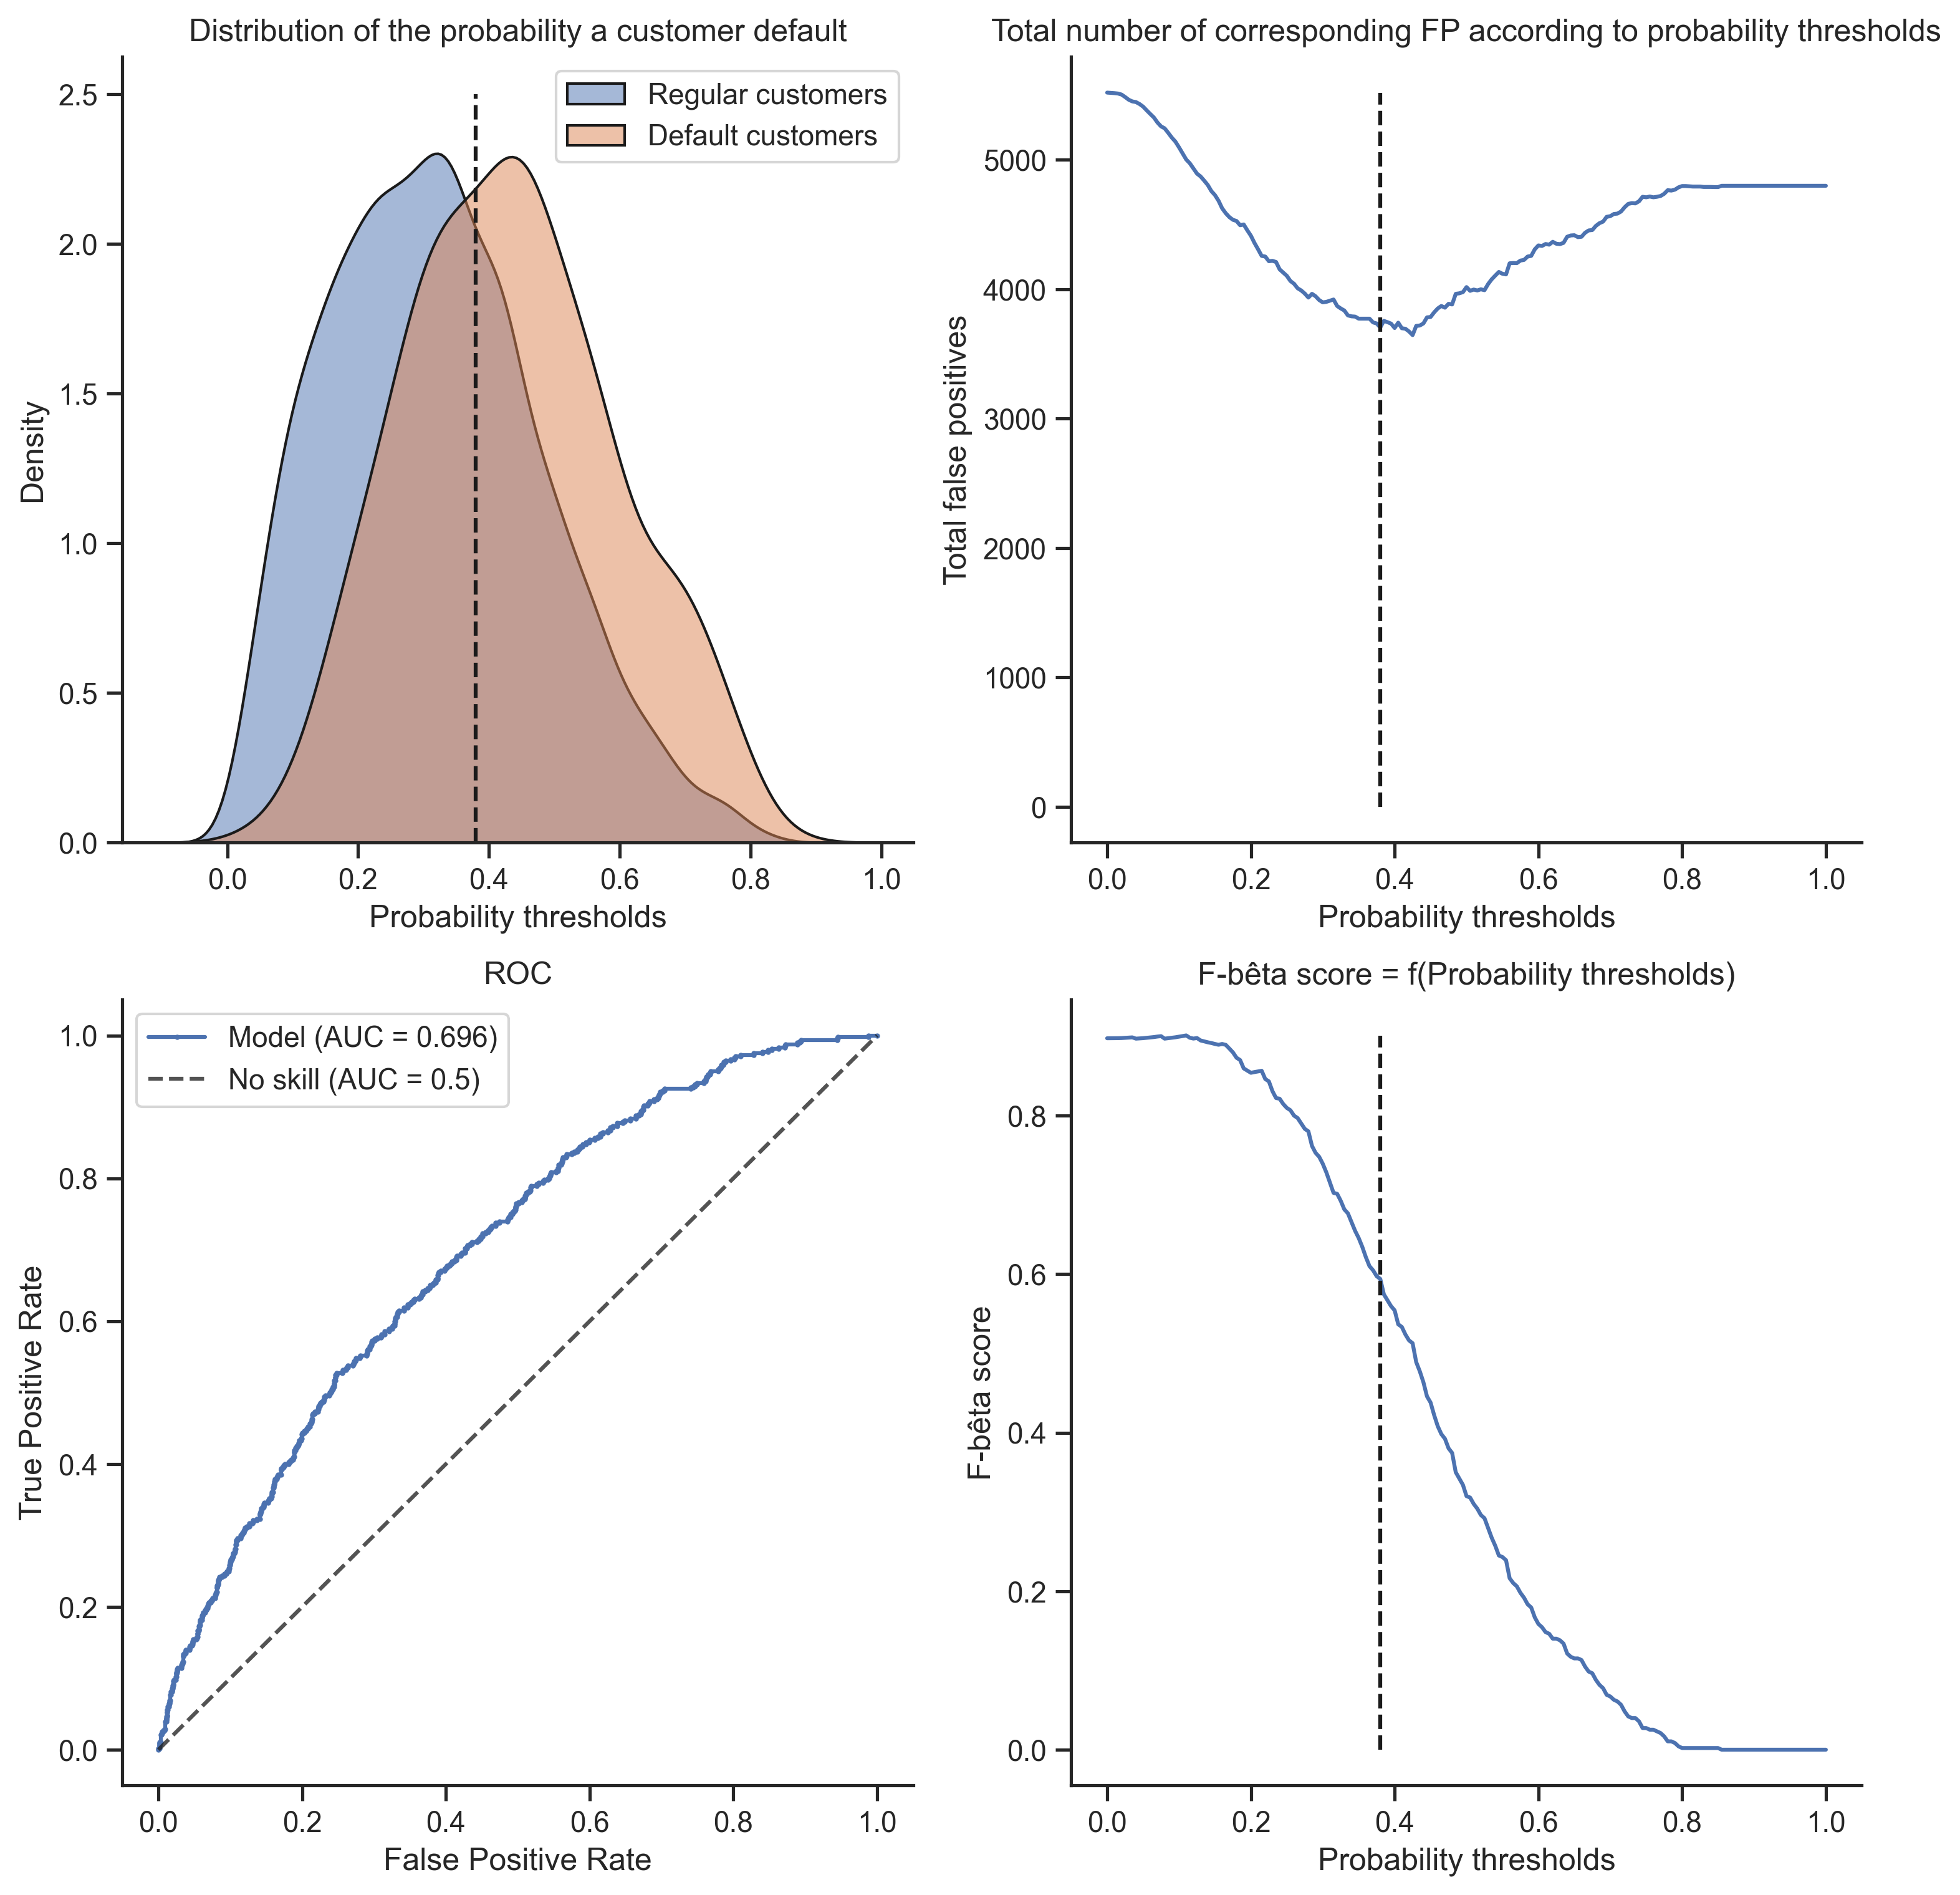


----------------------------------------------------------------------------------------------------

Updating entry...
Done!
The row have been updated.


Models   
Model_labels                                                      
dummy_clf                DummyClassifier(strategy='stratified')  \
logi_reg_opt  LogisticRegression(C=100.0, class_weight='bala...   
rf_clf_opt    (DecisionTreeClassifier(max_depth=10, max_feat...   
xgb_clf_opt   XGBClassifier(base_score=None, booster=None, c...   
lgbm_clf_opt  LGBMClassifier(class_weight='balanced', colsam...   

                                                     yhat_train   
Model_labels                                                      
dummy_clf     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.5950216861017936, 0.5400718415302808, 0.430...   
rf_clf_opt    [0.5443689719737853, 0.6585302236646584, 0.177...   
xgb_clf_opt   [0.5688134, 0.62018585, 0.15535076, 0.42749348...   
lgbm_clf_opt  [0.6142795453522419, 0.6490163088635007, 0.246...   

                                                      yhat_test   
Model_labels                                                      
dummy_clf     [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.34288296588972866, 0.4585440415379346, 0.56...   
rf_clf_opt    [0.42756610416750596, 0.5202812622906803, 0.13...   
xgb_clf_opt   [0.3637119, 0.47850734, 0.07989965, 0.32197857...   
lgbm_clf_opt  [0.5517143544597476, 0.38818625549996316, 0.16...   

              Best_proba_threshold_train Best_proba_threshold_test   
Model_labels                                                         
dummy_clf                          1.000                       1.0  \
logi_reg_opt                       0.475                     0.475   
rf_clf_opt                         0.400                      0.38   
xgb_clf_opt                        0.475                     0.465   
lgbm_clf_opt                       0.505                     0.485   

              Job_score_train Job_score_test  AUROC_scores_train   
Model_labels                                                       
dummy_clf            0.534591       0.534884            0.499999  \
logi_reg_opt         0.587815       0.581008            0.618610   
rf_clf_opt           0.668959       0.640988            0.727212   
xgb_clf_opt          0.684892         0.6625            0.741560   
lgbm_clf_opt         0.681817       0.651357            0.742423   

             AUROC_scores_test  F-bêta_score_train F-bêta_score_test   
Model_labels                                                           
dummy_clf             0.494565            0.078063          0.066694  \
logi_reg_opt          0.601764            0.897919          0.897778   
rf_clf_opt            0.696335            0.897898          0.901347   
xgb_clf_opt           0.706817            0.898201          0.897944   
lgbm_clf_opt          0.702991            0.898531          0.898577   

              Process_time_train (s) Process_time_test (s)  
Model_labels                                                
dummy_clf                   0.110721              0.019011  
logi_reg_opt                2.928672              0.345314  
rf_clf_opt                  7.106856               1.94677  
xgb_clf_opt                 3.163377              1.121018  
lgbm_clf_opt                1.303183              0.516469

CPU times: total: 7.98 s
Wall time: 4.89 s


In [51]:
%%time

# Initialize local variables.
model = rf_clf_opt
model_label = 'rf_clf_opt'
eval_dataset = 'test_set'
get_csv_file = GET_CSV_FILE


# Train the model and get its predictions probabilities.
y_pred_proba_NP, process_time = model_fit_predict(model, X=X_TEST, y=y_TEST)


#print('sklearn score =', model.score(X_TEST, y_TEST, scoring='roc_auc', cv=SKF_5, n_jobs=-1))

# Evaluate the model.
best_thr, g_norm, rocauc, fbeta = evaluate(y_pred_proba_NP[:,1], y_true=y_TEST)


# Store the relevant values in the model storage dataframe.
l_vars = [model_label, model, y_pred_proba_NP[:,1], best_thr, g_norm, rocauc, fbeta, process_time]

# Update the csv file if the main score is higher and the user allowed it.
print("\n" + "-" * 100 + "\n")
df_MODELS = update_sum_table(df_MODELS, l_vars, get_csv_file, eval_dataset)
                        
# Show the table.
display(df_MODELS)

### d) XGBoosting

In [52]:
import xgboost as xgb
from xgboost import XGBClassifier

print('XGBoost version:', xgb.__version__)

XGBoost version: 1.7.5


#### i. Hyperparameters tuning

In [53]:
# Initiliaze the model with its default values.
xgb_clf = XGBClassifier(objective='binary:logistic', scale_pos_weight=10, random_state=None)

In [54]:
# Get the list of the model's hyperparameters.
pprint(xgb_clf.get_params(), compact=True)

{'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'binary:logistic',
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 10,
 'subsample': None,
 'tree_method': None,
 'use_label_encoder': None,
 'validate_parameters': None,
 'verbosity': None}


In [55]:
### Get the optimal number of trees thanks to early stopping ###

# Set the number of runs to perform.
n_es_loop = 5

# Set the xgboost evaluation metric for the early stopping.
# NB: if more than one evaluation metric are given the last one is used for early stopping
xgb_clf.set_params(eval_metric='auc')

# Run the set amount of loops to get the most promising range of number of trees to get.
verbose = 0
l_n_iters = []
l_scores = []
l_n_trees = []
count = 0
for count in range(n_es_loop):
    xgb_clf.fit(X_TRAIN, y_TRAIN, early_stopping_rounds=50, eval_set=[(X_TEST, y_TEST)], verbose=verbose)
    l_scores.append(xgb_clf.best_score)
    l_n_iters.append(xgb_clf.best_iteration)
    l_n_trees.append(xgb_clf.best_ntree_limit)
    if verbose != 0:
        print()

# Show the results.    
print("Averages gotten on {0} loops. \
      \n Average score: {1}\n Average number of iterations: {2}\n Average number of trees: {3}".\
      format(n_es_loop, np.mean(l_scores), np.mean(l_n_iters), np.mean(l_n_trees)))

Averages gotten on 5 loops.       
 Average score: 0.709513134057971
 Average number of iterations: 12.0
 Average number of trees: 13.0


In [56]:
#from scipy.stats import uniform, randint

In [57]:
hyperparams_grid = {
    'n_estimators': [int(x) for x in np.linspace(50,100,6)],#0.8 * np.mean(l_n_trees), 1.2 * np.mean(l_n_trees), 6).astype(int)],
    'max_depth': [int(x) for x in np.linspace(2, 10, 5)],
    'colsample_bytree': [x for x in np.linspace(0.2, 1.0, 5)], #uniform(0.7, 0.3),
    'gamma': [x for x in np.linspace(0.0, 1.0, 6)], #uniform(0, 0.5),
    'learning_rate': [x for x in np.logspace(-4, 0, 5)], # default 0.1 
    'subsample': [x for x in np.linspace(0.2, 1.0, 5)] #uniform(0.6, 0.4)
}

# Show the hyperparameters list and their associated range of values to try.
print("Hyperameters tuning ranges:")
pprint(hyperparams_grid, compact=True)

Hyperameters tuning ranges:
{'colsample_bytree': [0.2, 0.4, 0.6000000000000001, 0.8, 1.0],
 'gamma': [0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
 'max_depth': [2, 4, 6, 8, 10],
 'n_estimators': [50, 60, 70, 80, 90, 100],
 'subsample': [0.2, 0.4, 0.6000000000000001, 0.8, 1.0]}


In [58]:
%%time

# True: Tune hyperparameters, False: Get the last tuned results stored.
tune = HT

# Tune the hyperparameters of the model.
if tune:
    model_grid = hyper_tune_rand_grid(xgb_clf, X_TRAIN, y_TRAIN, hyperparams_grid, g_norm_scorer, SKF_5,
                                      n_iter=100, grid_loop=1, range_precision=None, rand_state=None,
                                      verbose=10)

    # Get the model set with the best hyperparameters found.
    xgb_clf_opt = model_grid.best_estimator_

# Load the last values calculated for the hyperparameters.
else:
    df_MODELS = pd.read_pickle(os.path.join(EXPORTS_MODELS_DIR_PATH, PKL_MODELS_FILE))#.set_index('Model_labels')
    xgb_clf_opt = df_MODELS.loc['xgb_clf_opt', 'Models']
    
print()

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best estimator found:
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Best score found:
 score = 0.686

Best hyperparameters found:
 {'colsample_bytree': 1.0, 'gamma': 0.4, 'lea

#### ii. Evaluation of the optimized model performances

sklearn cross val score = 0.7414031946673767

ROC-AUC = 0.741279
F-Bêta score of the optimal threshold found = 0.623
Highest F-Bêta score = 0.898
Job score: 0.684

----------------------------------------------------------------------------------------------------



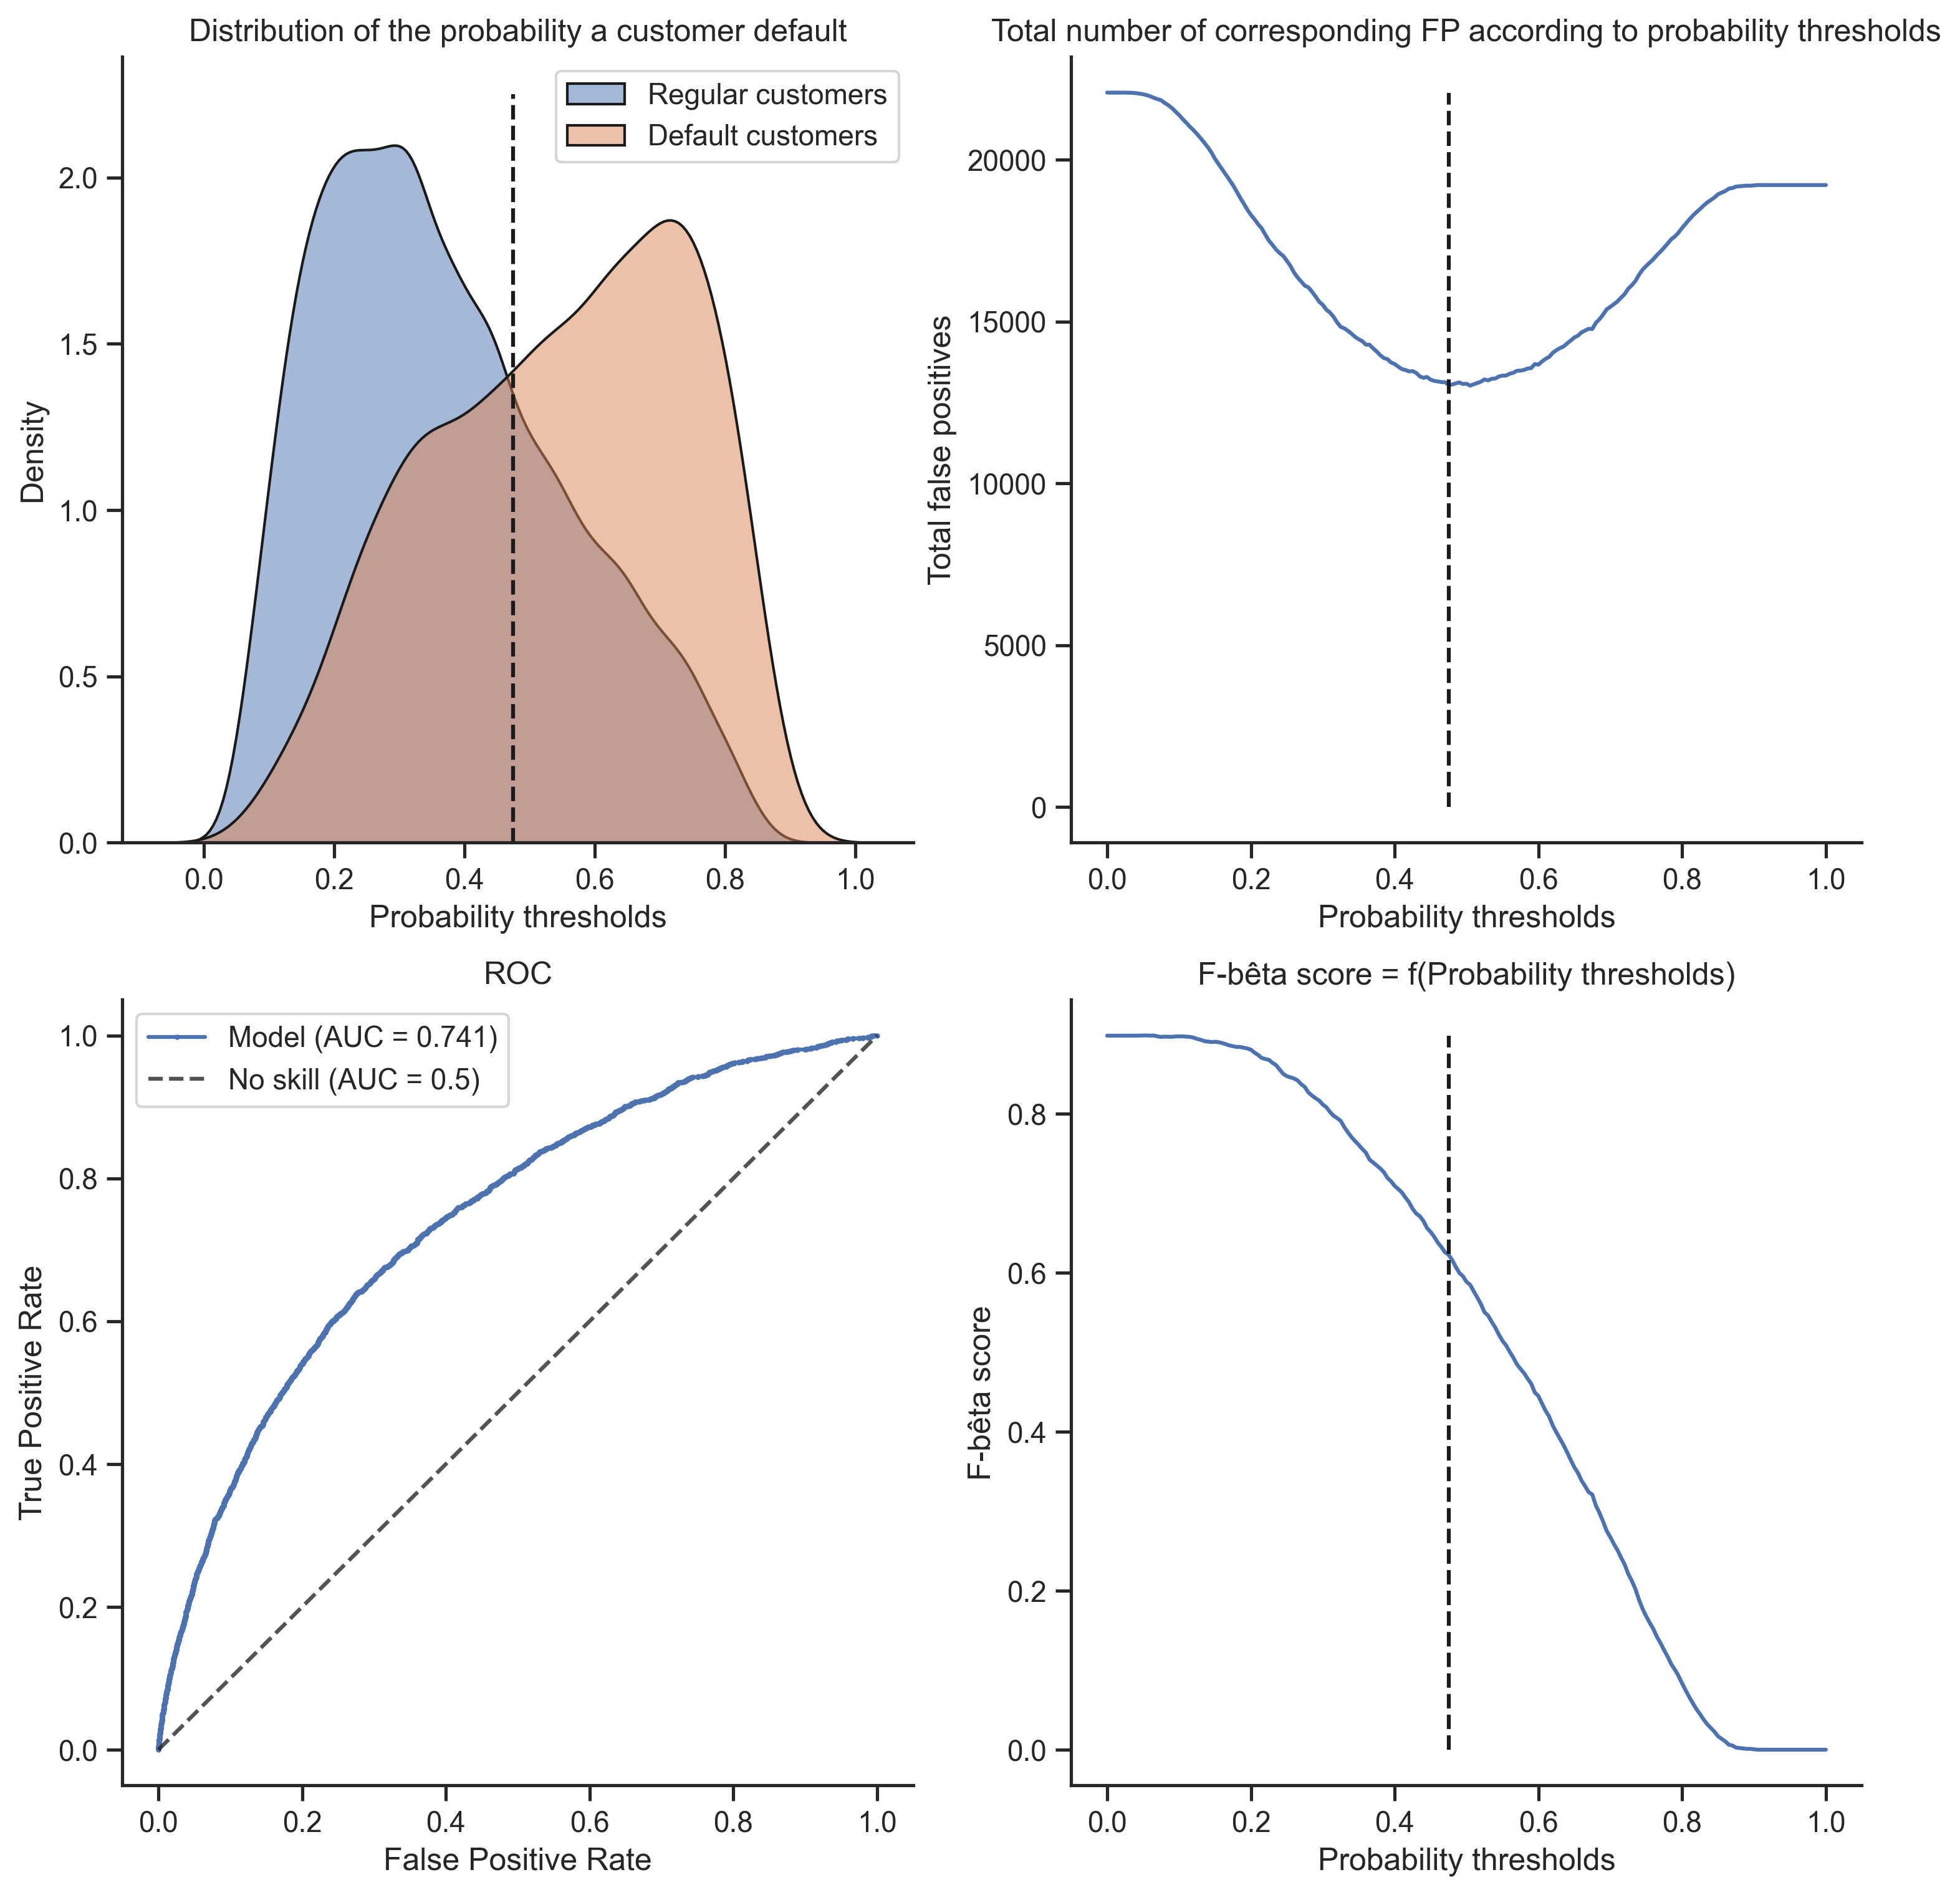


----------------------------------------------------------------------------------------------------

The new score is inferior to the one already saved.
Dataframe not saved.


Models   
Model_labels                                                      
dummy_clf                DummyClassifier(strategy='stratified')  \
logi_reg_opt  LogisticRegression(C=100.0, class_weight='bala...   
rf_clf_opt    (DecisionTreeClassifier(max_depth=10, max_feat...   
xgb_clf_opt   XGBClassifier(base_score=None, booster=None, c...   
lgbm_clf_opt  LGBMClassifier(class_weight='balanced', colsam...   

                                                     yhat_train   
Model_labels                                                      
dummy_clf     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.5950216861017936, 0.5400718415302808, 0.430...   
rf_clf_opt    [0.5443689719737853, 0.6585302236646584, 0.177...   
xgb_clf_opt   [0.5688134, 0.62018585, 0.15535076, 0.42749348...   
lgbm_clf_opt  [0.6142795453522419, 0.6490163088635007, 0.246...   

                                                      yhat_test   
Model_labels                                                      
dummy_clf     [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.34288296588972866, 0.4585440415379346, 0.56...   
rf_clf_opt    [0.42756610416750596, 0.5202812622906803, 0.13...   
xgb_clf_opt   [0.3637119, 0.47850734, 0.07989965, 0.32197857...   
lgbm_clf_opt  [0.5517143544597476, 0.38818625549996316, 0.16...   

              Best_proba_threshold_train Best_proba_threshold_test   
Model_labels                                                         
dummy_clf                          1.000                       1.0  \
logi_reg_opt                       0.475                     0.475   
rf_clf_opt                         0.400                      0.38   
xgb_clf_opt                        0.475                     0.465   
lgbm_clf_opt                       0.505                     0.485   

              Job_score_train Job_score_test  AUROC_scores_train   
Model_labels                                                       
dummy_clf            0.534591       0.534884            0.499999  \
logi_reg_opt         0.587815       0.581008            0.618610   
rf_clf_opt           0.668959       0.640988            0.727212   
xgb_clf_opt          0.684892         0.6625            0.741560   
lgbm_clf_opt         0.681817       0.651357            0.742423   

             AUROC_scores_test  F-bêta_score_train F-bêta_score_test   
Model_labels                                                           
dummy_clf             0.494565            0.078063          0.066694  \
logi_reg_opt          0.601764            0.897919          0.897778   
rf_clf_opt            0.696335            0.897898          0.901347   
xgb_clf_opt           0.706817            0.898201          0.897944   
lgbm_clf_opt          0.702991            0.898531          0.898577   

              Process_time_train (s) Process_time_test (s)  
Model_labels                                                
dummy_clf                   0.110721              0.019011  
logi_reg_opt                2.928672              0.345314  
rf_clf_opt                  7.106856               1.94677  
xgb_clf_opt                 3.163377              1.121018  
lgbm_clf_opt                1.303183              0.516469

CPU times: total: 58.9 s
Wall time: 13.7 s


In [59]:
%%time

# Initialize local variables.
model = xgb_clf_opt
model_label = 'xgb_clf_opt'
eval_dataset = 'valid_set'
get_csv_file = GET_CSV_FILE


# Train the model and get its predictions probabilities.
y_pred_proba_NP, process_time = model_fit_predict(model)


print('sklearn cross val score =', np.mean(cross_val_score(model, X_TRAIN, y_TRAIN, scoring='roc_auc', cv=SKF_5, n_jobs=-1)))

# Evaluate the model.
best_thr, g_norm, rocauc, fbeta = evaluate(y_pred_proba_NP[:,1], y_true=y_TRAIN)


# Store the relevant values in the model storage dataframe.
l_vars = [model_label, model, y_pred_proba_NP[:,1], best_thr, g_norm, rocauc, fbeta, process_time]

# Update the csv file if the main score is higher and the user allowed it.
print("\n" + "-" * 100 + "\n")
df_MODELS = update_sum_table(df_MODELS, l_vars, get_csv_file, eval_dataset)
                        
# Show the table.
display(df_MODELS)

#### iii. Generalization over the test set


ROC-AUC = 0.705211
F-Bêta score of the optimal threshold found = 0.706
Highest F-Bêta score = 0.898
Job score: 0.644

----------------------------------------------------------------------------------------------------



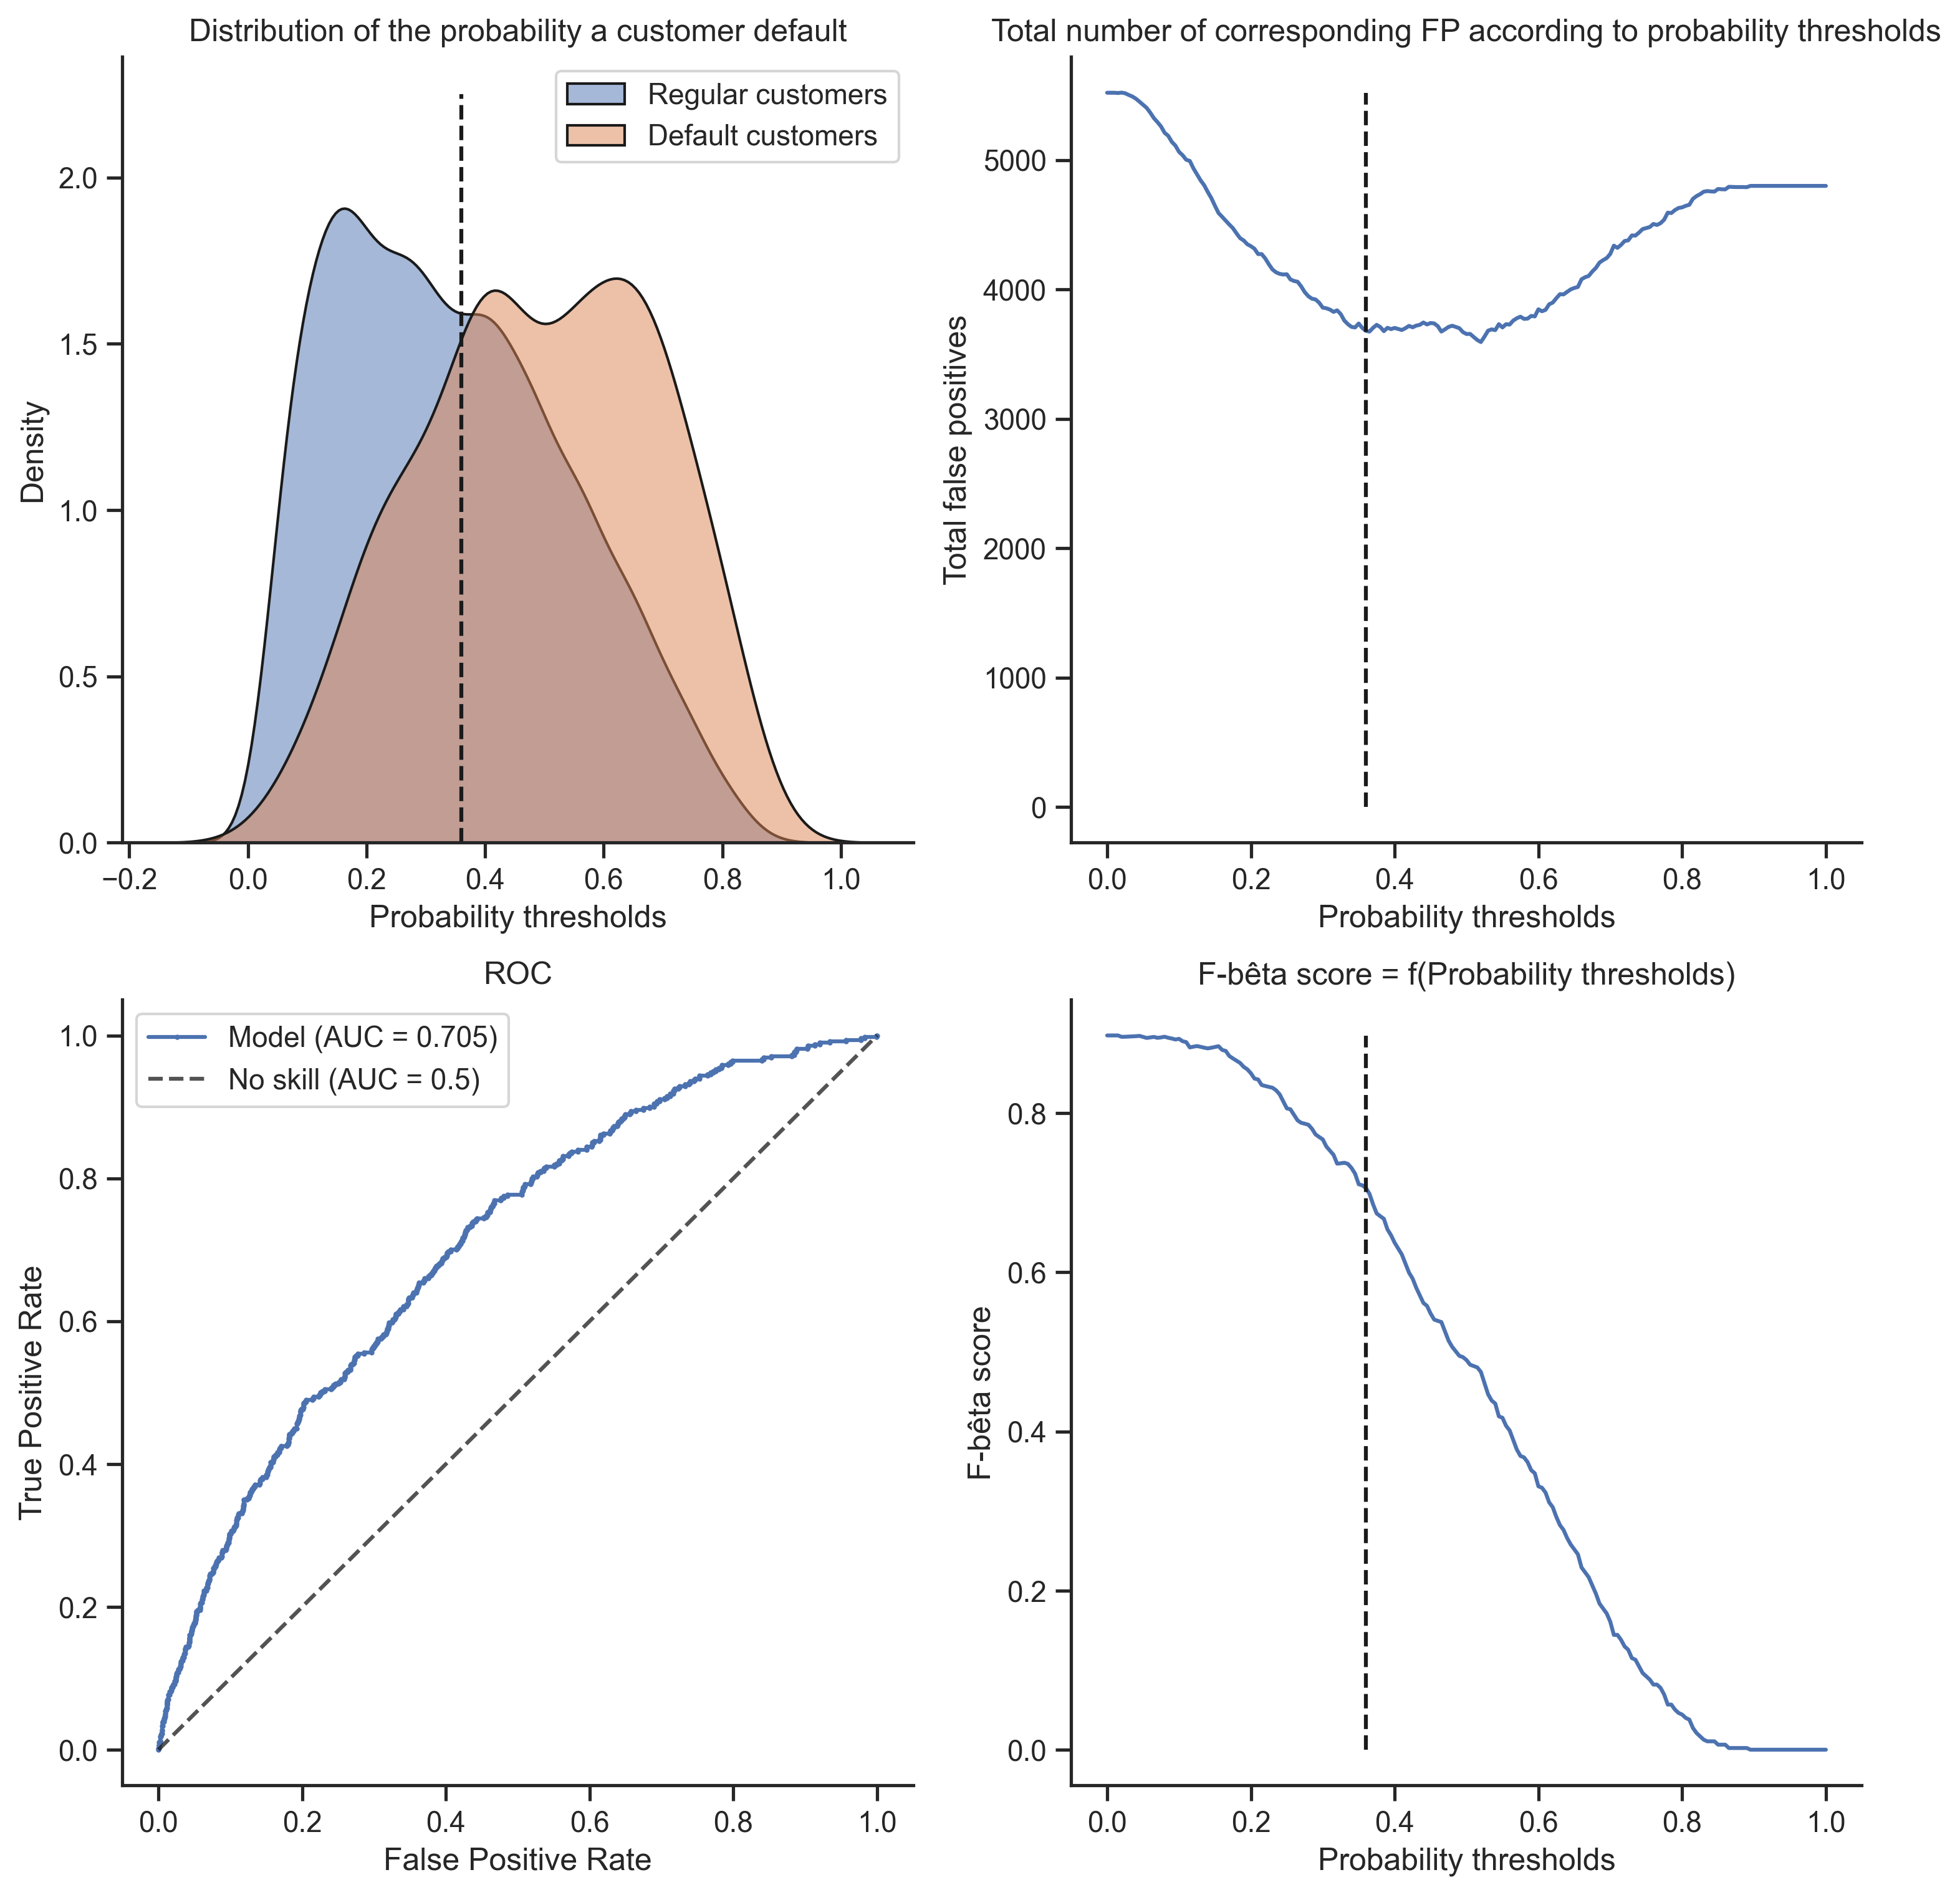


----------------------------------------------------------------------------------------------------

The new score is inferior to the one already saved.
Dataframe not saved.


Models   
Model_labels                                                      
dummy_clf                DummyClassifier(strategy='stratified')  \
logi_reg_opt  LogisticRegression(C=100.0, class_weight='bala...   
rf_clf_opt    (DecisionTreeClassifier(max_depth=10, max_feat...   
xgb_clf_opt   XGBClassifier(base_score=None, booster=None, c...   
lgbm_clf_opt  LGBMClassifier(class_weight='balanced', colsam...   

                                                     yhat_train   
Model_labels                                                      
dummy_clf     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.5950216861017936, 0.5400718415302808, 0.430...   
rf_clf_opt    [0.5443689719737853, 0.6585302236646584, 0.177...   
xgb_clf_opt   [0.5688134, 0.62018585, 0.15535076, 0.42749348...   
lgbm_clf_opt  [0.6142795453522419, 0.6490163088635007, 0.246...   

                                                      yhat_test   
Model_labels                                                      
dummy_clf     [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.34288296588972866, 0.4585440415379346, 0.56...   
rf_clf_opt    [0.42756610416750596, 0.5202812622906803, 0.13...   
xgb_clf_opt   [0.3637119, 0.47850734, 0.07989965, 0.32197857...   
lgbm_clf_opt  [0.5517143544597476, 0.38818625549996316, 0.16...   

              Best_proba_threshold_train Best_proba_threshold_test   
Model_labels                                                         
dummy_clf                          1.000                       1.0  \
logi_reg_opt                       0.475                     0.475   
rf_clf_opt                         0.400                      0.38   
xgb_clf_opt                        0.475                     0.465   
lgbm_clf_opt                       0.505                     0.485   

              Job_score_train Job_score_test  AUROC_scores_train   
Model_labels                                                       
dummy_clf            0.534591       0.534884            0.499999  \
logi_reg_opt         0.587815       0.581008            0.618610   
rf_clf_opt           0.668959       0.640988            0.727212   
xgb_clf_opt          0.684892         0.6625            0.741560   
lgbm_clf_opt         0.681817       0.651357            0.742423   

             AUROC_scores_test  F-bêta_score_train F-bêta_score_test   
Model_labels                                                           
dummy_clf             0.494565            0.078063          0.066694  \
logi_reg_opt          0.601764            0.897919          0.897778   
rf_clf_opt            0.696335            0.897898          0.901347   
xgb_clf_opt           0.706817            0.898201          0.897944   
lgbm_clf_opt          0.702991            0.898531          0.898577   

              Process_time_train (s) Process_time_test (s)  
Model_labels                                                
dummy_clf                   0.110721              0.019011  
logi_reg_opt                2.928672              0.345314  
rf_clf_opt                  7.106856               1.94677  
xgb_clf_opt                 3.163377              1.121018  
lgbm_clf_opt                1.303183              0.516469

CPU times: total: 23.9 s
Wall time: 4.26 s


In [60]:
%%time

# Initialize local variables.
model = xgb_clf_opt
model_label = 'xgb_clf_opt'
eval_dataset = 'test_set'
get_csv_file = GET_CSV_FILE


# Train the model and get its predictions probabilities.
y_pred_proba_NP, process_time = model_fit_predict(model, X=X_TEST, y=y_TEST)


#print('sklearn score =', model.score(X_TEST, y_TEST, scoring='roc_auc', cv=SKF_5, n_jobs=-1))

# Evaluate the model.
best_thr, g_norm, rocauc, fbeta = evaluate(y_pred_proba_NP[:,1], y_true=y_TEST)


# Store the relevant values in the model storage dataframe.
l_vars = [model_label, model, y_pred_proba_NP[:,1], best_thr, g_norm, rocauc, fbeta, process_time]

# Update the csv file if the main score is higher and the user allowed it.
print("\n" + "-" * 100 + "\n")
df_MODELS = update_sum_table(df_MODELS, l_vars, get_csv_file, eval_dataset)
                        
# Show the table.
display(df_MODELS)

### e) LightGBM

In [61]:
import lightgbm as lgbm
from lightgbm import LGBMClassifier

print('lightgbm version:', lgbm.__version__)

lightgbm version: 3.3.5


#### i. Hyperparameters tuning

In [62]:
# Initiliaze the model with its default values.
lgbm_clf = LGBMClassifier(objective='binary', class_weight = 'balanced', random_state=None, n_jobs = -1)

In [63]:
# Get the list of the model's hyperparameters.
pprint(lgbm_clf.get_params(), compact=True)

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}


In [64]:
hyperparams_grid = {
    'n_estimators': [int(x) for x in np.linspace(50,100,6)],#0.8 * np.mean(l_n_trees), 1.2 * np.mean(l_n_trees), 6).astype(int)],
    'max_depth': [int(x) for x in np.linspace(2, 10, 5)],
    'colsample_bytree': [x for x in np.linspace(0.2, 1.0, 5)], #uniform(0.7, 0.3),
    #'gamma': [x for x in np.linspace(0.0, 1.0, 6)], #uniform(0, 0.5),
    'learning_rate': [x for x in np.logspace(-4, 0, 5)], # default 0.1 
    'subsample': [x for x in np.linspace(0.2, 1.0, 5)] #uniform(0.6, 0.4)
}

# Show the hyperparameters list and their associated range of values to try.
print("Hyperameters tuning ranges:")
pprint(hyperparams_grid, compact=True)

Hyperameters tuning ranges:
{'colsample_bytree': [0.2, 0.4, 0.6000000000000001, 0.8, 1.0],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
 'max_depth': [2, 4, 6, 8, 10],
 'n_estimators': [50, 60, 70, 80, 90, 100],
 'subsample': [0.2, 0.4, 0.6000000000000001, 0.8, 1.0]}


In [65]:
%%time

# True: Tune hyperparameters, False: Get the last tuned results stored.
tune = HT

# Tune the hyperparameters of the model.
if tune:
    model_grid = hyper_tune_rand_grid(lgbm_clf, X_TRAIN, y_TRAIN, hyperparams_grid, g_norm_scorer, SKF_5,
                                      n_iter=100, grid_loop=1, range_precision=None, rand_state=None,
                                      verbose=10)

    # Get the model set with the best hyperparameters found.
    lgbm_clf_opt = model_grid.best_estimator_

# Load the last values calculated for the hyperparameters.
else:
    df_MODELS = pd.read_pickleread_csv(os.path.join(EXPORTS_MODELS_DIR_PATH, PKL_MODELS_FILE))#.set_index('Model_labels')
    lgbm_clf_opt = df_MODELS.loc['lgbm_clf_opt', 'Models']
    
print()

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best estimator found:
 LGBMClassifier(class_weight='balanced', colsample_bytree=0.6000000000000001,
               max_depth=2, n_estimators=70, objective='binary',
               subsample=0.6000000000000001)

Best score found:
 score = 0.682

Best hyperparameters found:
 {'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 70, 'subsample': 0.6000000000000001}

CPU times: total: 27.7 s
Wall time: 1min


#### ii. Evaluation of the optimized model performances

sklearn cross val score = 0.7418894896170867

ROC-AUC = 0.741680
F-Bêta score of the optimal threshold found = 0.681
Highest F-Bêta score = 0.899
Job score: 0.677

----------------------------------------------------------------------------------------------------



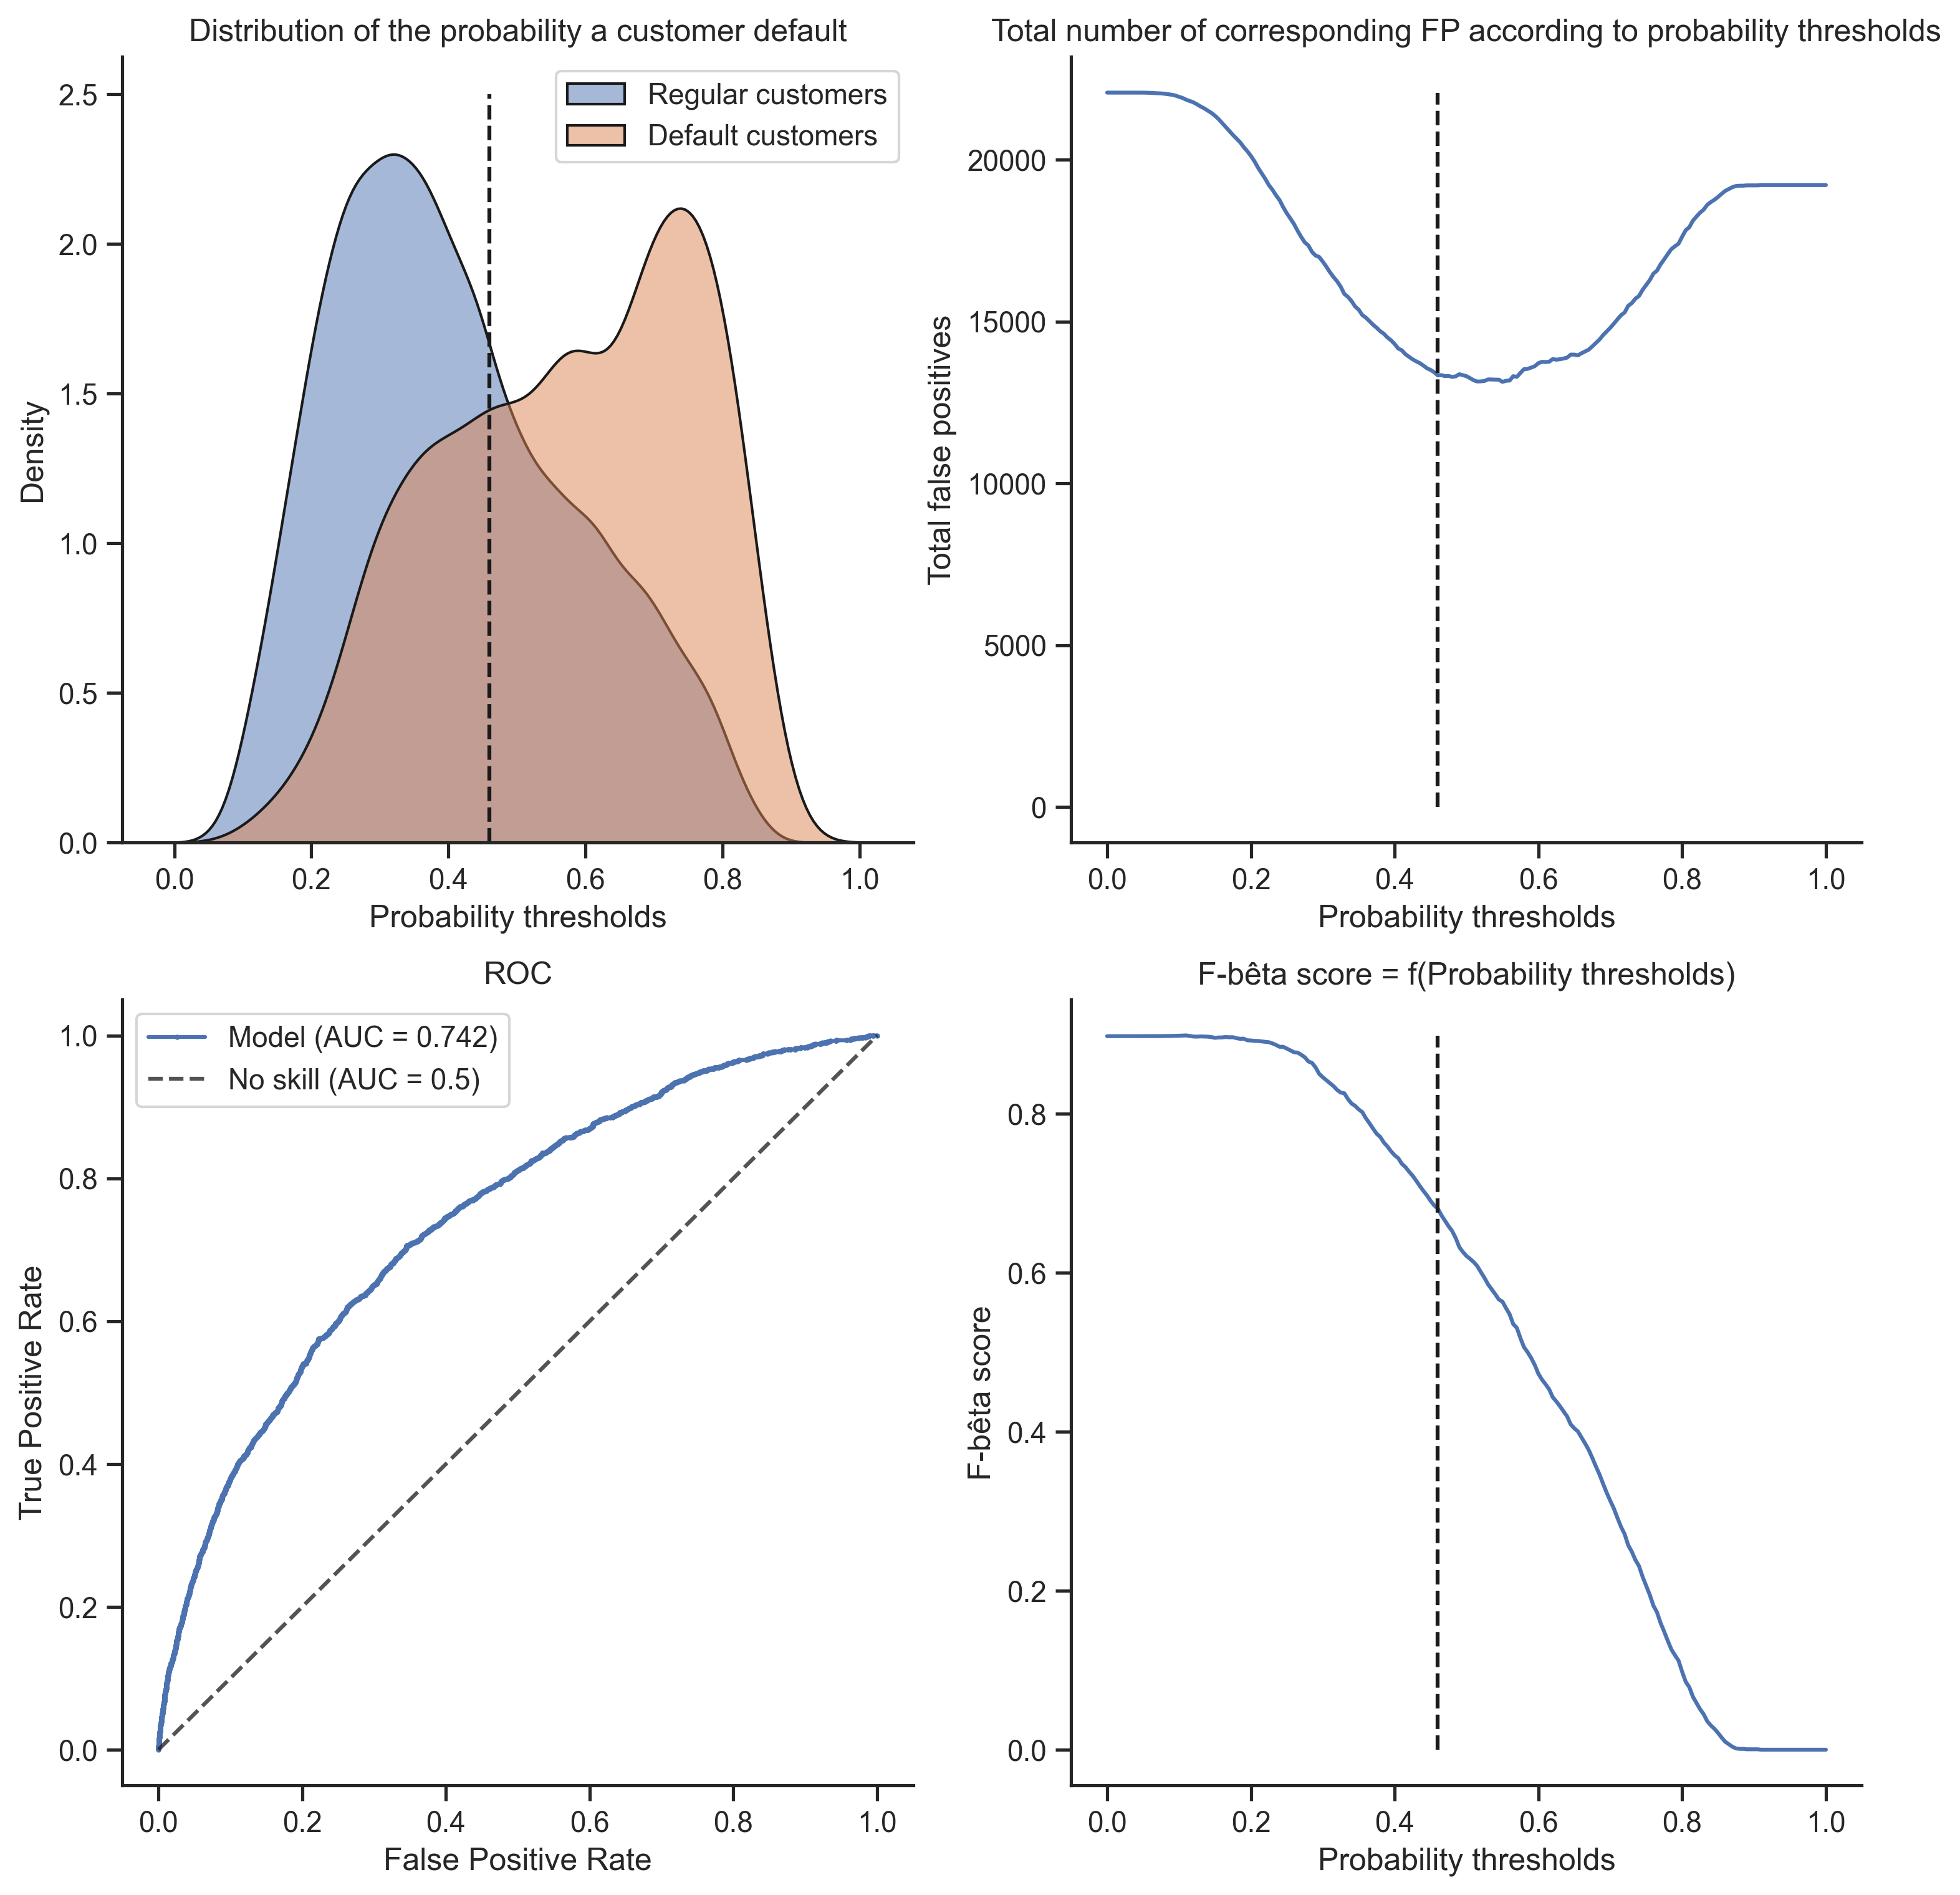


----------------------------------------------------------------------------------------------------

The new score is inferior to the one already saved.
Dataframe not saved.


Models   
Model_labels                                                      
dummy_clf                DummyClassifier(strategy='stratified')  \
logi_reg_opt  LogisticRegression(C=100.0, class_weight='bala...   
rf_clf_opt    (DecisionTreeClassifier(max_depth=10, max_feat...   
xgb_clf_opt   XGBClassifier(base_score=None, booster=None, c...   
lgbm_clf_opt  LGBMClassifier(class_weight='balanced', colsam...   

                                                     yhat_train   
Model_labels                                                      
dummy_clf     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.5950216861017936, 0.5400718415302808, 0.430...   
rf_clf_opt    [0.5443689719737853, 0.6585302236646584, 0.177...   
xgb_clf_opt   [0.5688134, 0.62018585, 0.15535076, 0.42749348...   
lgbm_clf_opt  [0.6142795453522419, 0.6490163088635007, 0.246...   

                                                      yhat_test   
Model_labels                                                      
dummy_clf     [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.34288296588972866, 0.4585440415379346, 0.56...   
rf_clf_opt    [0.42756610416750596, 0.5202812622906803, 0.13...   
xgb_clf_opt   [0.3637119, 0.47850734, 0.07989965, 0.32197857...   
lgbm_clf_opt  [0.5517143544597476, 0.38818625549996316, 0.16...   

              Best_proba_threshold_train Best_proba_threshold_test   
Model_labels                                                         
dummy_clf                          1.000                       1.0  \
logi_reg_opt                       0.475                     0.475   
rf_clf_opt                         0.400                      0.38   
xgb_clf_opt                        0.475                     0.465   
lgbm_clf_opt                       0.505                     0.485   

              Job_score_train Job_score_test  AUROC_scores_train   
Model_labels                                                       
dummy_clf            0.534591       0.534884            0.499999  \
logi_reg_opt         0.587815       0.581008            0.618610   
rf_clf_opt           0.668959       0.640988            0.727212   
xgb_clf_opt          0.684892         0.6625            0.741560   
lgbm_clf_opt         0.681817       0.651357            0.742423   

             AUROC_scores_test  F-bêta_score_train F-bêta_score_test   
Model_labels                                                           
dummy_clf             0.494565            0.078063          0.066694  \
logi_reg_opt          0.601764            0.897919          0.897778   
rf_clf_opt            0.696335            0.897898          0.901347   
xgb_clf_opt           0.706817            0.898201          0.897944   
lgbm_clf_opt          0.702991            0.898531          0.898577   

              Process_time_train (s) Process_time_test (s)  
Model_labels                                                
dummy_clf                   0.110721              0.019011  
logi_reg_opt                2.928672              0.345314  
rf_clf_opt                  7.106856               1.94677  
xgb_clf_opt                 3.163377              1.121018  
lgbm_clf_opt                1.303183              0.516469

CPU times: total: 27.5 s
Wall time: 7.51 s


In [66]:
%%time

# Initialize local variables.
model = lgbm_clf_opt
model_label = 'lgbm_clf_opt'
eval_dataset = 'valid_set'
get_csv_file = GET_CSV_FILE


# Train the model and get its predictions probabilities.
y_pred_proba_NP, process_time = model_fit_predict(model)


print('sklearn cross val score =', np.mean(cross_val_score(model, X_TRAIN, y_TRAIN, scoring='roc_auc', cv=SKF_5, n_jobs=-1)))

# Evaluate the model.
best_thr, g_norm, rocauc, fbeta = evaluate(y_pred_proba_NP[:,1], y_true=y_TRAIN)


# Store the relevant values in the model storage dataframe.
l_vars = [model_label, model, y_pred_proba_NP[:,1], best_thr, g_norm, rocauc, fbeta, process_time]

# Update the csv file if the main score is higher and the user allowed it.
print("\n" + "-" * 100 + "\n")
df_MODELS = update_sum_table(df_MODELS, l_vars, get_csv_file, eval_dataset)
                        
# Show the table.
display(df_MODELS)

#### iii. Generalization over the test set


ROC-AUC = 0.703648
F-Bêta score of the optimal threshold found = 0.658
Highest F-Bêta score = 0.898
Job score: 0.644

----------------------------------------------------------------------------------------------------



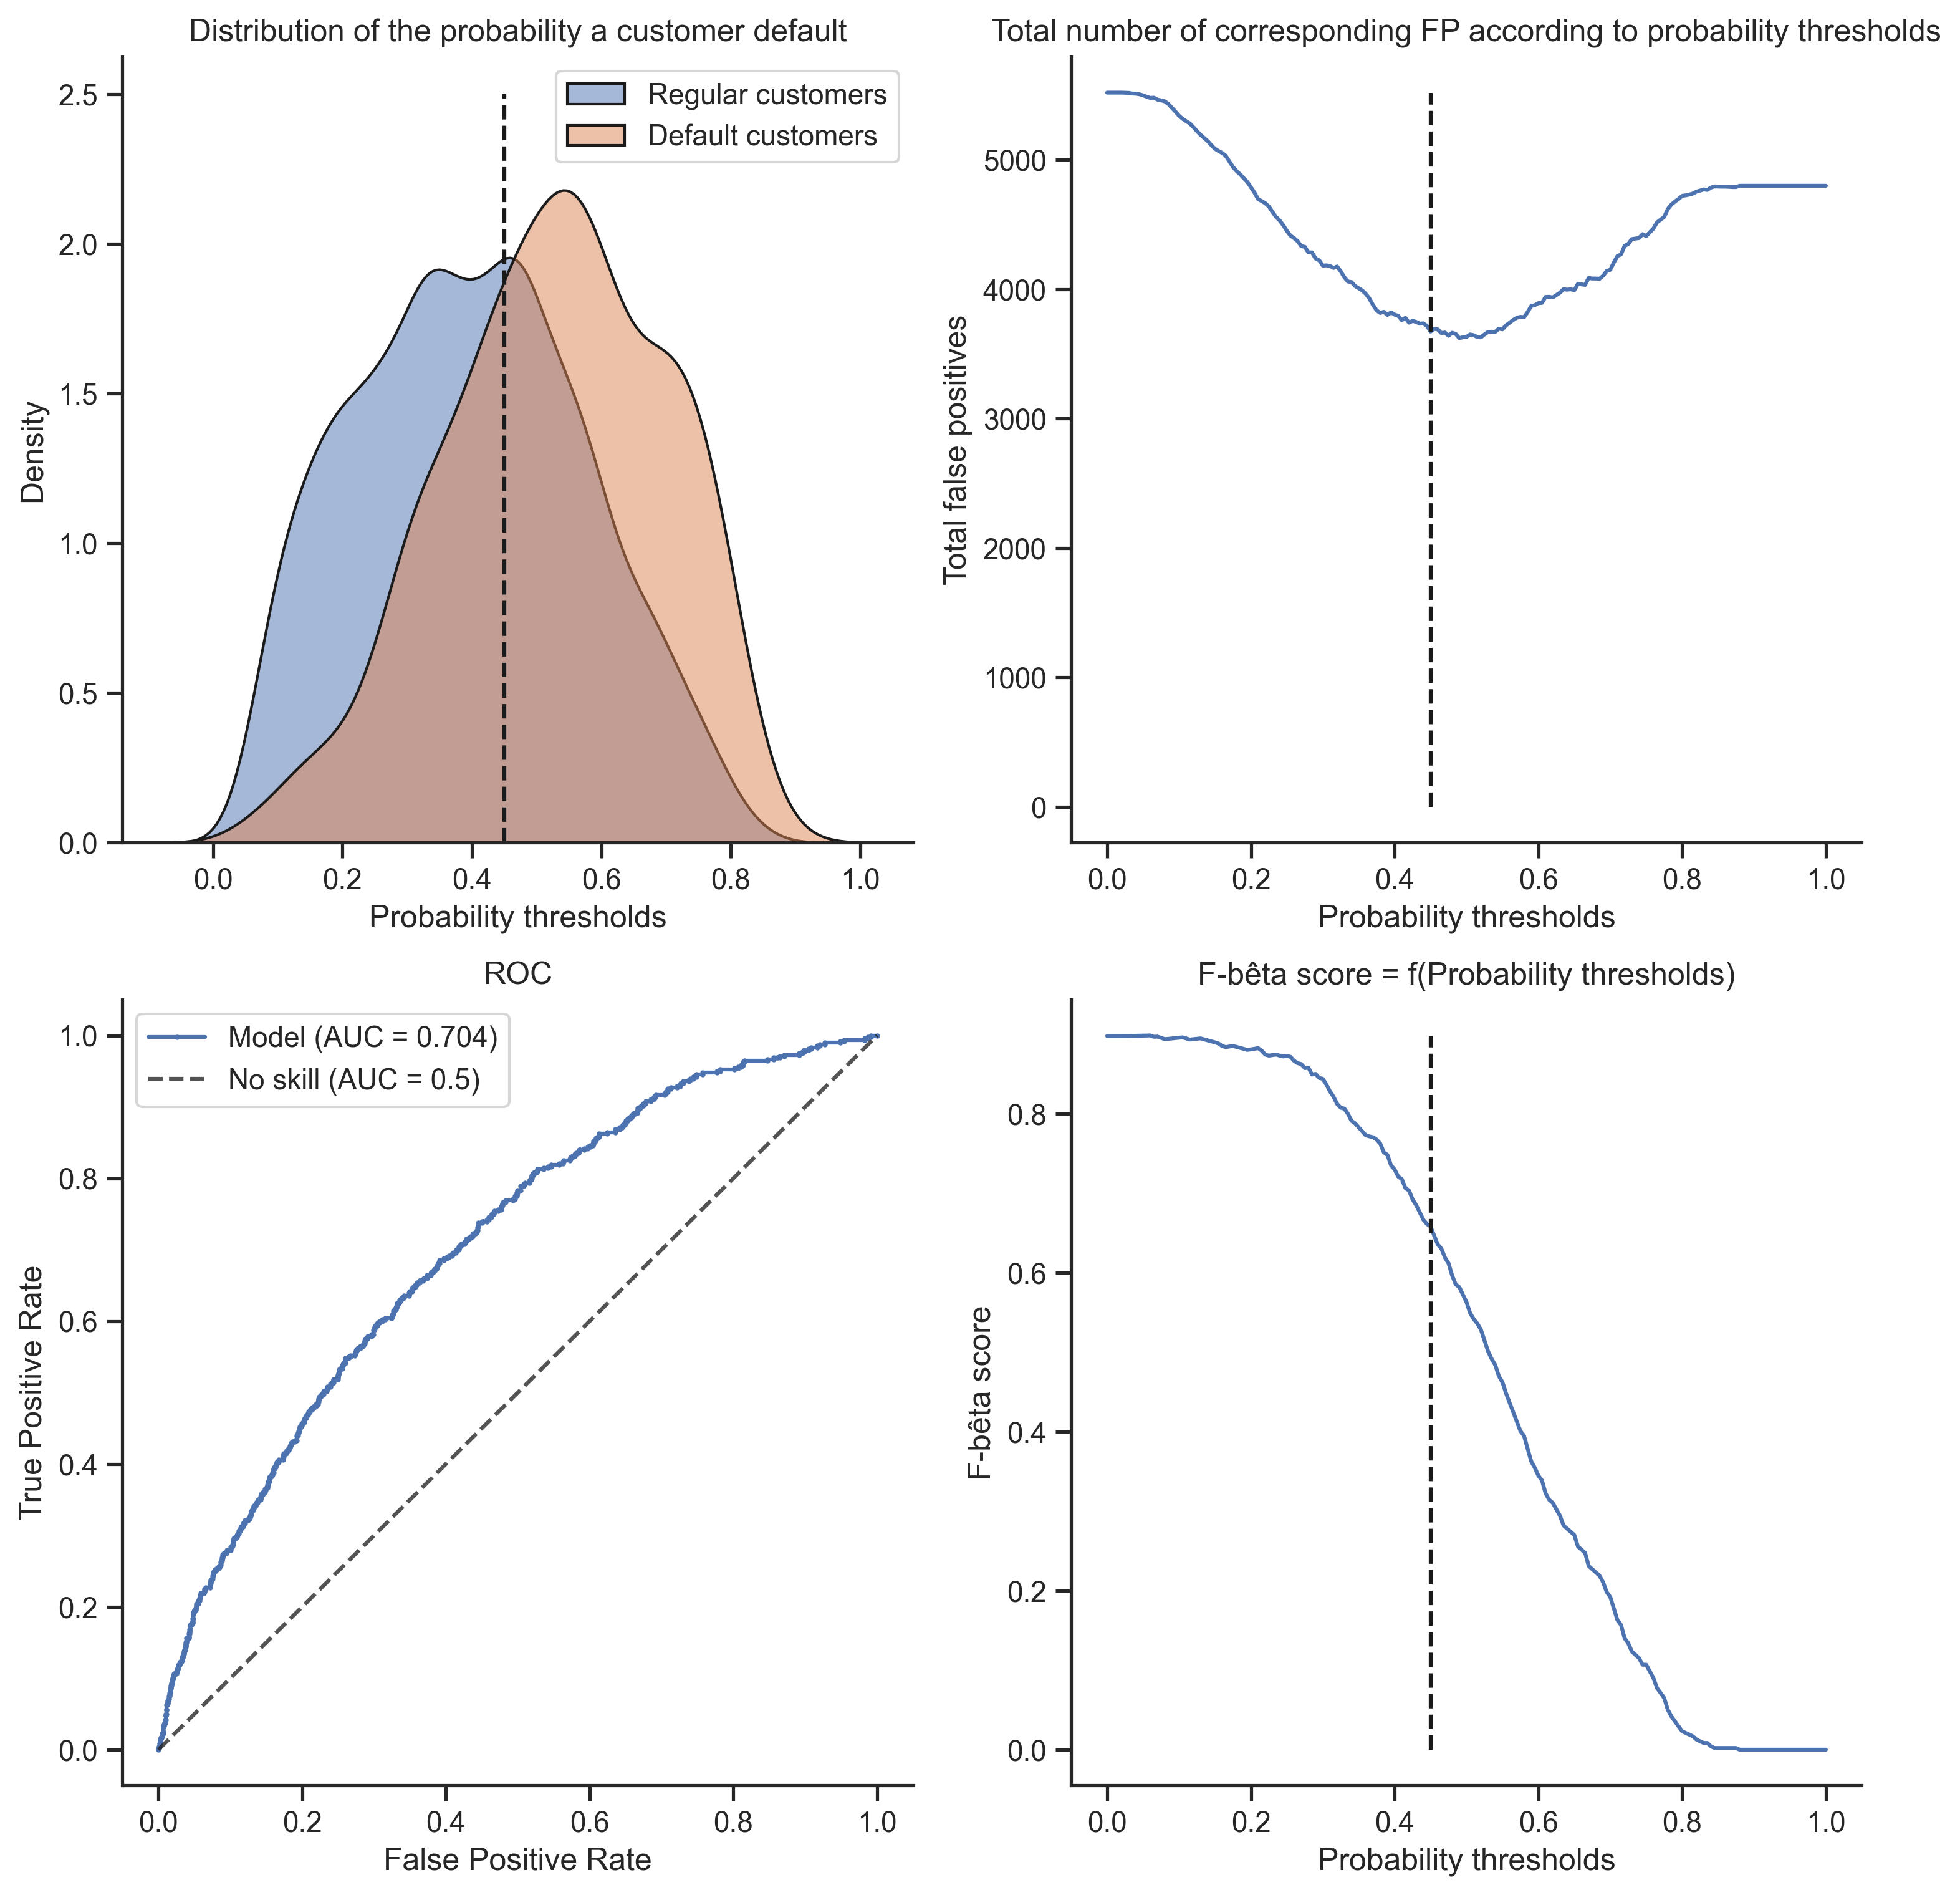


----------------------------------------------------------------------------------------------------

The new score is inferior to the one already saved.
Dataframe not saved.


Models   
Model_labels                                                      
dummy_clf                DummyClassifier(strategy='stratified')  \
logi_reg_opt  LogisticRegression(C=100.0, class_weight='bala...   
rf_clf_opt    (DecisionTreeClassifier(max_depth=10, max_feat...   
xgb_clf_opt   XGBClassifier(base_score=None, booster=None, c...   
lgbm_clf_opt  LGBMClassifier(class_weight='balanced', colsam...   

                                                     yhat_train   
Model_labels                                                      
dummy_clf     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.5950216861017936, 0.5400718415302808, 0.430...   
rf_clf_opt    [0.5443689719737853, 0.6585302236646584, 0.177...   
xgb_clf_opt   [0.5688134, 0.62018585, 0.15535076, 0.42749348...   
lgbm_clf_opt  [0.6142795453522419, 0.6490163088635007, 0.246...   

                                                      yhat_test   
Model_labels                                                      
dummy_clf     [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  \
logi_reg_opt  [0.34288296588972866, 0.4585440415379346, 0.56...   
rf_clf_opt    [0.42756610416750596, 0.5202812622906803, 0.13...   
xgb_clf_opt   [0.3637119, 0.47850734, 0.07989965, 0.32197857...   
lgbm_clf_opt  [0.5517143544597476, 0.38818625549996316, 0.16...   

              Best_proba_threshold_train Best_proba_threshold_test   
Model_labels                                                         
dummy_clf                          1.000                       1.0  \
logi_reg_opt                       0.475                     0.475   
rf_clf_opt                         0.400                      0.38   
xgb_clf_opt                        0.475                     0.465   
lgbm_clf_opt                       0.505                     0.485   

              Job_score_train Job_score_test  AUROC_scores_train   
Model_labels                                                       
dummy_clf            0.534591       0.534884            0.499999  \
logi_reg_opt         0.587815       0.581008            0.618610   
rf_clf_opt           0.668959       0.640988            0.727212   
xgb_clf_opt          0.684892         0.6625            0.741560   
lgbm_clf_opt         0.681817       0.651357            0.742423   

             AUROC_scores_test  F-bêta_score_train F-bêta_score_test   
Model_labels                                                           
dummy_clf             0.494565            0.078063          0.066694  \
logi_reg_opt          0.601764            0.897919          0.897778   
rf_clf_opt            0.696335            0.897898          0.901347   
xgb_clf_opt           0.706817            0.898201          0.897944   
lgbm_clf_opt          0.702991            0.898531          0.898577   

              Process_time_train (s) Process_time_test (s)  
Model_labels                                                
dummy_clf                   0.110721              0.019011  
logi_reg_opt                2.928672              0.345314  
rf_clf_opt                  7.106856               1.94677  
xgb_clf_opt                 3.163377              1.121018  
lgbm_clf_opt                1.303183              0.516469

CPU times: total: 13.2 s
Wall time: 3.39 s


In [67]:
%%time

# Initialize local variables.
model = lgbm_clf_opt
model_label = 'lgbm_clf_opt'
eval_dataset = 'test_set'
get_csv_file = GET_CSV_FILE


# Train the model and get its predictions probabilities.
y_pred_proba_NP, process_time = model_fit_predict(model, X=X_TEST, y=y_TEST)


#print('sklearn score =', model.score(X_TEST, y_TEST, scoring='roc_auc', cv=SKF_5, n_jobs=-1))

# Evaluate the model.
best_thr, g_norm, rocauc, fbeta = evaluate(y_pred_proba_NP[:,1], y_true=y_TEST)


# Store the relevant values in the model storage dataframe.
l_vars = [model_label, model, y_pred_proba_NP[:,1], best_thr, g_norm, rocauc, fbeta, process_time]

# Update the csv file if the main score is higher and the user allowed it.
print("\n" + "-" * 100 + "\n")
df_MODELS = update_sum_table(df_MODELS, l_vars, get_csv_file, eval_dataset)
                        
# Show the table.
display(df_MODELS)

### f) Models comparison

#### i. Functions

In [266]:
def figure_barplot (df, x_labels = 'Model_labels', y_label = 'Score', title = None):
    
    # Rearrange the df such as it fits the seaborn.barplot() data format.
    tidy = df.reset_index().melt(id_vars=x_labels, value_name=y_label, var_name='')
    
    # Plot the figure.
    ax = sns.barplot(data=tidy, y=x_labels, x=y_label, hue='', orient='h', edgecolor='k')
    
    plt.ylabel = ' '
    
    # Set the figure title.
    plt.title(title)
    
    #return ax

#### ii. Figures

*__- ROCs comparison__*

CPU times: total: 46.9 ms
Wall time: 56.1 ms


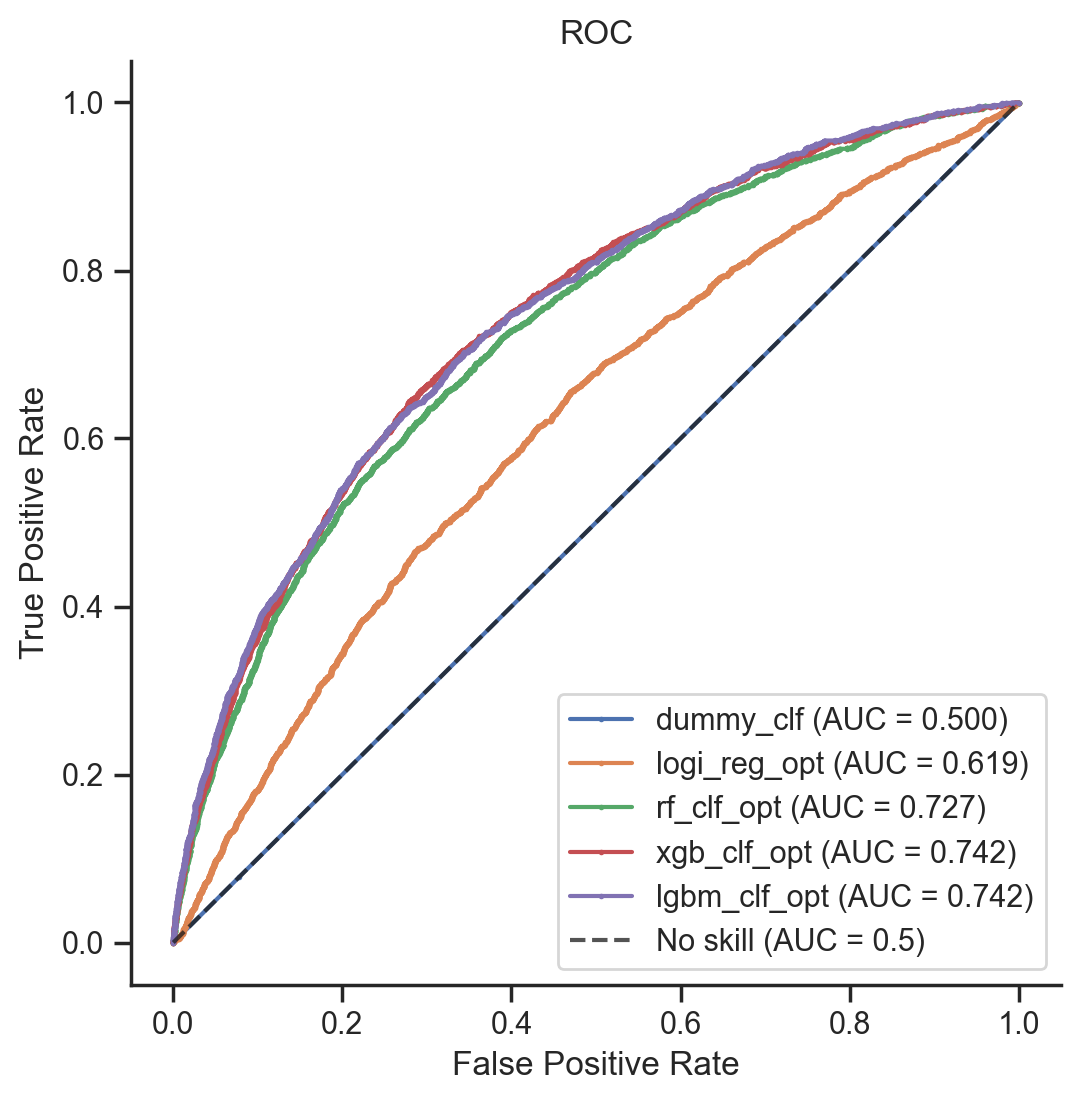

In [250]:
%%time

# Draw the ROCs.
figure_roc(y_TRAIN, df_MODELS['yhat_train'], df_MODELS.index)

*__- Scores and processing times comparisons__*

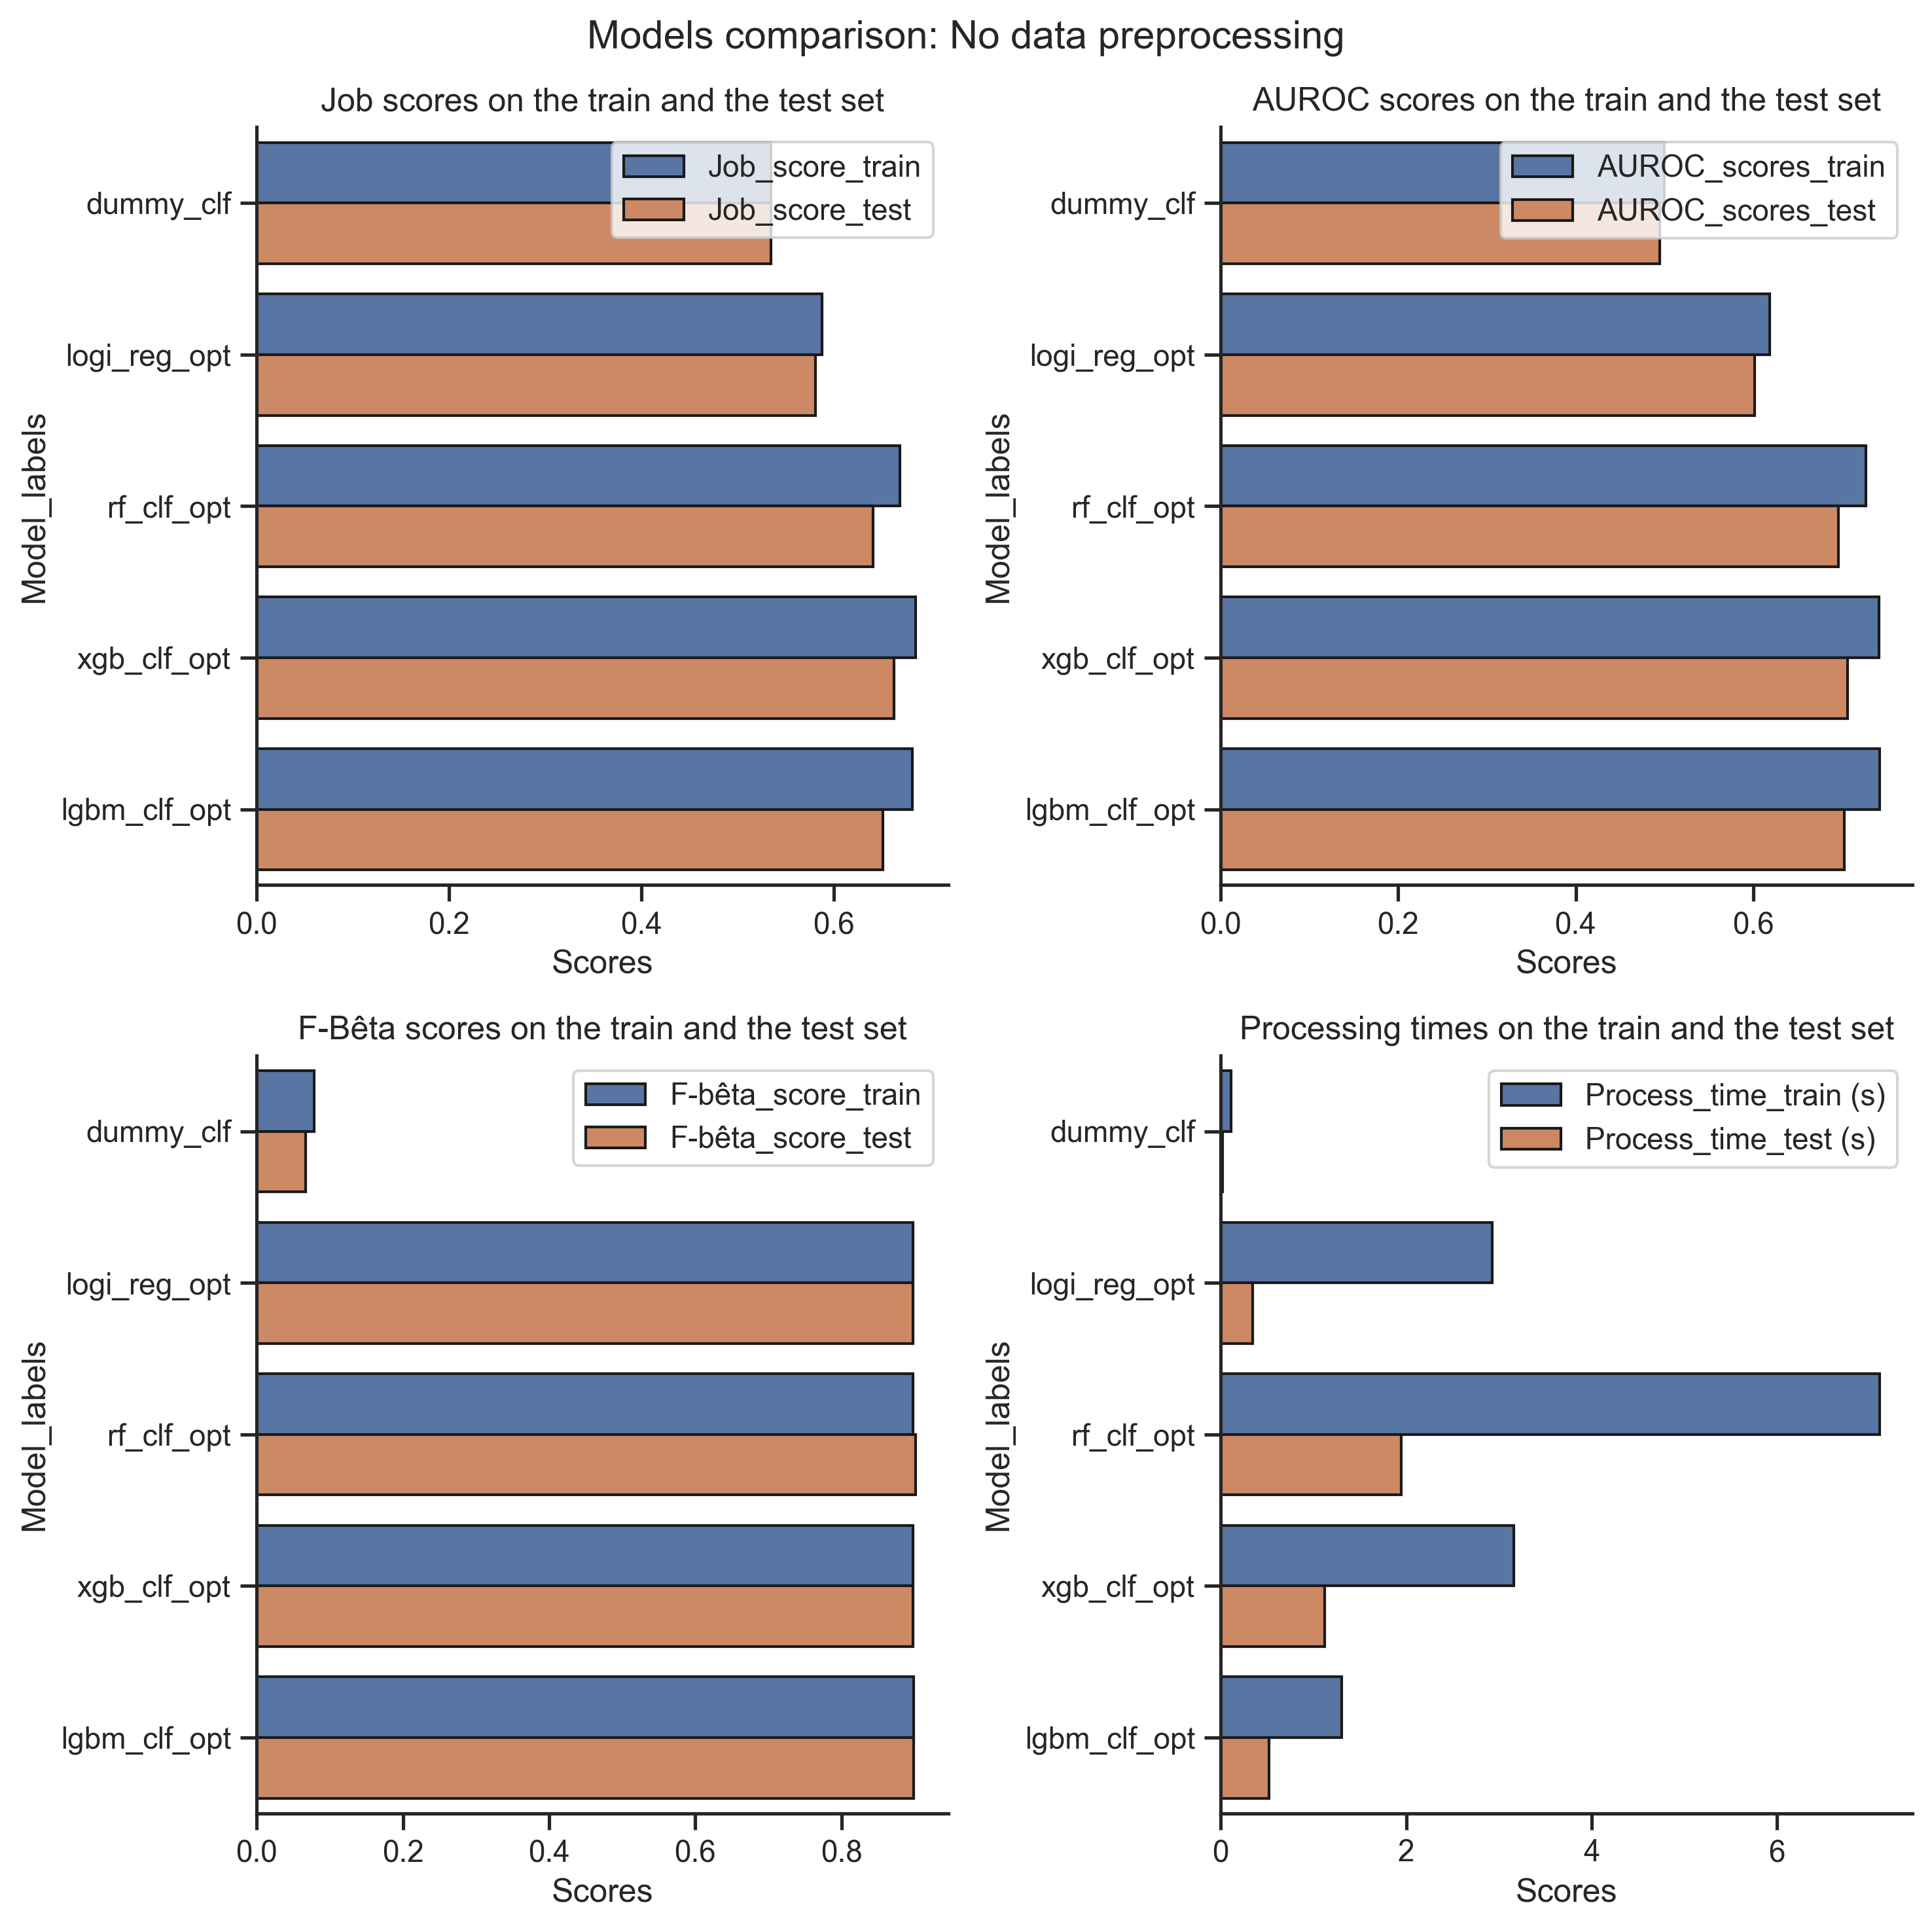

CPU times: total: 844 ms
Wall time: 839 ms


In [277]:
%%time

### Configuration ###

# Select the columns to compare.
l_features_peers = [
                    ['Job_score_train', 'Job_score_test'],
                    ['AUROC_scores_train', 'AUROC_scores_test'],
                    ['F-bêta_score_train', 'F-bêta_score_test'],
                    ['Process_time_train (s)', 'Process_time_test (s)']
                   ]

# Set each subplot titles.
l_subplot_titles = ["Job scores on the train and the test set",
                    "AUROC scores on the train and the test set",
                    "F-Bêta scores on the train and the test set",
                    "Processing times on the train and the test set"]

# Set the figure environment.
fig = plt.figure(figsize=(10,10), dpi=300)

# Set the whole figure title.
fig.suptitle("Models comparison: No data sampling")

# Initialize the subplot grid (2 lines x 2 columns).
l, c = int(len(l_features_peers) / 2), 2


### Plotting ###

# Run the loop to drw and position each subplot on the figure's subplot grid.
i = 0
for i in range(len(l_features_peers)):

    # Get the columns and the subplot title to plot.
    features_peer = l_features_peers[i]
    subplot_title = l_subplot_titles[i]
    
    # Set the position of the subplot.
    p = i + 1
    plt.subplot(l, c, p)
    
    # Plot the subplot.
    figure_barplot(df_MODELS[features_peer],
                   x_labels = 'Model_labels', y_label = 'Scores',
                   title = subplot_title)
    

### Drawing ###

# Arrange the subplots such as they are not superimposing each others. 
plt.tight_layout()

# Draw the figure.
plt.show()

In [ ]:

STOP

## 4) Data balancing

*NB: SMOTE should be applied on the train set only.*

In [ ]:
from imblearn.pipeline import Pipeline # NB: imbalearn.pipeline.Pipeline allows to properly deal the SMOTE on the train set and avoid the validation/test sets.
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC # NB: SMOTENC can manage categorial features while SMOTE cannot.
from pprint import pprint

#from numba import jit, cuda

In [ ]:
display_EZ(X_TRAIN.head())

In [ ]:
X_TRAIN.info()

In [ ]:
l_CAT_COLS = []
l_CAT_COLS_MASK = []
for col in X_TRAIN.columns:
    col_type = X_TRAIN[col].dtypes
    if col_type != object:
        if str(col_type)[:3] == 'int':
            l_CAT_COLS.append(col)
            l_CAT_COLS_MASK.append(True)
        else:
            l_CAT_COLS_MASK.append(False)

print("List of names of the %i categorical features:\n %s" % (len(l_CAT_COLS), l_CAT_COLS))

In [ ]:
# Create the models.
smote_nc = SMOTENC(categorical_features=l_CAT_COLS_MASK)
logi_reg = LogisticRegression()

# Create the model's pipeline.
imba_pipe = Pipeline([('scaler', StandardScaler(copy=True)),
                      ('resampler', smote_nc),
                      ('model', logi_reg)]
                    )

In [ ]:
pprint(smote_nc.get_params(), compact=True)
print()
pprint(logi_reg.get_params(), compact=True)

In [ ]:
# SMOTE NC hyperparameters.
k_neighbors = [int(x) for x in np.linspace(start=3, stop=20, num=5)]
sampling_strategy = [round(x, 2) for x in np.linspace(start=0.2, stop=1.0, num=5)]

# Model hypermarameters.
C = [x for x in np.logspace(start=-5, stop=0, num=5)]


# Create the hypermeters' dictionary.
para_grid = {'resampler__k_neighbors': k_neighbors,
             'resampler__sampling_strategy': sampling_strategy,
             'model__C': C,
             }

print("Hyperameters tune ranges:\n")
pprint(para_grid, compact=True)

In [ ]:
%%time

#best_results_grid = hyper_tune_rand_grid_v4(imba_pipe, X_TRAIN, y_TRAIN, 2, para_grid, n_iter=10, grid_loop=1, rand_state=0)

# knn = 3, sp_strat=0.2, C = 0.00331, cv=5, n_iter=100, 22 min.

In [ ]:
STOP

In [ ]:
#%%time

#@jit(target_backend='cuda')
# Définition de l'instance SMOTE
#sm = SMOTENC(k_neighbors=3, sampling_strategy=0.75, categorical_features=l_CAT_COLS_MASK)

# Application du SMOTE aux données
#X_SMOTE, y_SMOTE = sm.fit_resample(X_TRAIN, y_TRAIN)

#print("X_train shape:", X_TRAIN.shape)
#print("X_smote shape:", X_SMOTE.shape)
#print()
#print("Check categorical features sampling:")
#display_EZ(X_TRAIN[l_CAT_COLS].head(3))